<a href="https://colab.research.google.com/github/MilerDiazZevallos/Arequipa-Covid-19/blob/master/Sala_Situacional_Arequipa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import curve_fit

! pip install empiricaldist
from empiricaldist import Pmf, Cdf

  Created wheel for empiricaldist: filename=empiricaldist-0.3.10-cp36-none-any.whl size=10186 sha256=7468b6a225011c25ebde26d86479704b5dbc43a0730d5ab55cfc29d31c9c5014
  Stored in directory: /root/.cache/pip/wheels/c7/07/a3/5fb101329516f5209276247b9d44d163eb485798dcf7419721
Successfully built empiricaldist


In [2]:
from google.colab import auth
auth.authenticate_user()
 
import gspread
from oauth2client.client import GoogleCredentials
 
gc = gspread.authorize(GoogleCredentials.get_application_default())

# R Function
### References:
### https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

### https://medium.com/@rburhum/el-martillazo-y-el-huayno-278716f49938

In [3]:
#@title
# general imports
import numpy as np
import datetime as dt
 
from joblib import Parallel, delayed
 
# matplotlib
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
 
# scipy specifics
from scipy import stats as sps
from scipy.interpolate import interp1d
 
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
#print(len(r_t_range))
# best sigma for Perú (prior hyperparameters)
#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
OPTIMAL_SIGMA = 0.30
#OPTIMAL_SIGMA = 0.05
 
# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7
 
#@title
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
 
    #print(smoothed_cases.to_csv('smoothed_cases'))
 
    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    #print(len(zeros))
    
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
        #print(last_zero)
        #print(idx_start)
 
    
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    #print(smoothed_cases.head())
    #print(original.head())
 
    #print('End smoothed')
    return original, smoothed_cases
    
 
def calculate_posteriors(sr, sigma=0.15):
 
    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    # (1) Calculate Lambda
    #print(sr[:-1].tail())
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    #print('lam shape', lam.shape)
    
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    #print('likelihoods shape', likelihoods.shape)
 
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    #print('process_matrix shape', process_matrix.shape)
 
    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    #print('process_matrix shape', process_matrix.shape)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()
    #print('prior0 shape', prior0.shape)
 
    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    #print('posteriors shape', posteriors.shape)
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0
 
    #print(sr.index[:-1])
    #print(sr.index[1:])
    
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):
 
        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood
    
 
def highest_density_interval(pmf, p=.9):
 
    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    #print(cumsum.shape)
    
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()
 
    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])
 
    return interval
    
 
def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
    ax.set_title(f"{state_name}")
 
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    #ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=cmap(color_mapped(values)), edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-05-01'), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)
 
    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.25, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(pd.Timestamp('2020-05-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
 
    for i,j in zip(index,values):
        if i in mondays:
            ax.annotate(str(round(j, 2)),xy=(i,j+0.1), arrowprops=dict(facecolor='black', shrink=0.05),) 
 
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """
 
 
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)
 
    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.7,.7,.7],
                  ecolor=[.3,.3,.3],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
 
 
    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
 
 
    fig.set_facecolor('w')
    return fig, ax
 
def run_full_model(cases, sigma=OPTIMAL_SIGMA):
    # initializing result dict
    result = {''}
 
    # smoothing series
    new, smoothed = smooth_new_cases(cases)
    #smooth_new_cases(cases)
 
    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)
    #calculate_posteriors(smoothed, sigma=sigma)
 
    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)
    #highest_density_interval(posteriors, p=.9)
 
    return result

# Doubling-time Function
### References:
### https://github.com/COVID-19-AI-Research-Project/AI-Data-Analysis/blob/master/Projects/1/Prediction_Covid_19_WorldWide.ipynb

###### A large doubling time is good.
###### A constant doubling time - means the measures being taken are effective in controlling the spread
###### An increasing doubling time means - the battle is on winning side
###### A decreasing doubling time-- well danger zone ahead. Do something fast

### https://www.npr.org/sections/health-shots/2020/04/10/829167659/are-we-flattening-the-curve-states-keep-watch-on-coronavirus-doubling-times

In [4]:
def prediction_country2(df1, tipo, plot=True):
    df_final = df1.copy()
    df_country = df_final
    df_country.reset_index(inplace=True)
    
    x=np.array(range(df_country.shape[0]))
    y=df_country[tipo].values
    #print(x)
 
    def func(x,a,b):
        return a*2**(x/b)
 
    def func1(x, a, b):
        return np.exp(b*(x-a))
  
  
    list_coeff = ['Arequipa']  
    for i in range(10, len(x)+1, 1):
        xdata = x[:i]
        ydata = y[:i]

        popt, pcov = curve_fit(func1,xdata=xdata,ydata=ydata,maxfev=1000)
        """
        try:
            popt, pcov = curve_fit(func1,xdata=xdata,ydata=ydata)
        except:
            popt = np.array([0,0])"""
        
        #print(i, xdata, ydata, popt)
        
        popt_aux = popt[1]
        popt[1] = np.log(2.)/popt[1]
        list_coeff.append(popt)
  
    if plot:
        fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
 
        #perc = np.diff(ydata) / ydata[:-1]
        #yfit = popt[0]*2**(xdata/popt[1])
        #perc_fit = np.diff(yfit) / yfit[:-1]
 
        #tdbl1 = np.log(2.)/popt[1]
        #print('popt1 =', popt, ', doubling time = {:.1f} days\n'.format(tdbl1))
 
        ax1.set_ylabel('Total infected in '+ 'Arequipa',fontsize=20)
        #ax1.set_yscale('log')
        ax1.plot(df_country[tipo],'--o',ms=10,label='Real Data')
        #ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
        ax1.plot(xdata,func1(xdata, popt[0], popt_aux),'-',label=f'Exponential fit np.exp({popt[1]}*(t-{popt[0]})), \n doubling time = {popt[1]} days')
        ax1.legend(fontsize=15)
        plt.show()
 
    return list_coeff
 
def get_country_double(df,country):
    df_coeff2 = df[country].str[-1]
    df_coeff1 = df[country].str[0]
    df_coeff2.dropna(inplace=True)
    df_coeff1.dropna(inplace=True)
    #df_coeff2 = np.log(2.)/df_coeff2.astype(str).astype(float)
    df_coeff2 = df_coeff2.astype(str).astype(float)
    df_coeff1 = df_coeff1.astype(str).astype(float)
    df_double = pd.concat([df_coeff1, df_coeff2], axis=1, join='outer')
    df_double.columns = ['Coeff1','Doubling Time in Days']
    return df_double

# Funciones Auxiliares

In [5]:
url_minsa = 'https://www.datosabiertos.gob.pe/node/6447/download/positivos_covid.csv'
#url_minsa = 'positivos_covid.csv'
datos_minsa = pd.read_csv(url_minsa, encoding = "ISO-8859-1", sep=";")

In [91]:
url_sinadef="https://cloud.minsa.gob.pe/s/NctBnHXDnocgWAg/download?path=%2F&files=SINADEF_DATOS_ABIERTOS_10122020.xlsx&downloadStartSecret=b9n0l9odbvq"
#url_sinadef="SINADEF_DATOS_ABIERTOS_02112020.xlsx"
datos_sinadef_raw = pd.read_excel(url_sinadef, sheet_name='Tabla_SINADEF', skiprows=range(3), skipfooter=0)

In [7]:
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-11'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-05-25'), \
           pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-08'), pd.to_datetime('2020-06-15'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-06-29'), \
           pd.to_datetime('2020-07-06'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-20'), pd.to_datetime('2020-07-27'), \
           pd.to_datetime('2020-08-03'), pd.to_datetime('2020-08-10'), pd.to_datetime('2020-08-17'), pd.to_datetime('2020-08-24'),  pd.to_datetime('2020-08-31'), \
           pd.to_datetime('2020-09-07'), pd.to_datetime('2020-09-14'), pd.to_datetime('2020-09-21'), pd.to_datetime('2020-09-28'), \
           pd.to_datetime('2020-10-05'), pd.to_datetime('2020-10-12'), pd.to_datetime('2020-10-19'), pd.to_datetime('2020-10-26'), \
           pd.to_datetime('2020-11-02'), pd.to_datetime('2020-11-09'), pd.to_datetime('2020-11-16'), pd.to_datetime('2020-11-23'), pd.to_datetime('2020-11-30'), \
           pd.to_datetime('2020-12-07'), pd.to_datetime('2020-12-12')]

In [71]:
semana_sinadef = 49
dia_sinadef = '12-09'

In [9]:
def plots(ax, type, data, labelx, labely, datax = '', datay = '', label = ''):
    if type == 'line_plt':
        ax.plot(data[datax],'--o',ms=10,label=labely)
        ax.plot(data[datax].rolling(7).mean(),'--o',ms=10,label=labely + ' promedio 7 días')
        ax.tick_params(labelsize=28)
        ax.set_xlabel(labelx,fontsize=28)
    elif type == 'reg_sns':
        ax = sns.regplot(x=datax, y=datay, data=data, order=3, label=labely, ax=ax)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        ax.tick_params(labelsize=28)
    elif type == 'bar_sns':
        ax = sns.barplot(x=data.index, y=datay, data=data, ax=ax)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
        ax.tick_params(labelsize=28)
    elif type == 'bar_stacked_plt':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.tick_params(labelsize=28)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
    elif type == 'bar_stacked_plt_uci':
        ax.bar(data.index, data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' positivos')
        ax.bar(data.index, data[datay+'_sospechosos'], bottom=data[datay+'_positivos'], edgecolor='white', width=1, label=labely+' sospechosos')
        ax.bar(data.index, data['trauma_shock'], bottom=data[datay+'_positivos'] + data[datay+'_sospechosos'], edgecolor='white', width=1, label='trauma shock')
        ax.tick_params(labelsize=28)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
    elif type == 'line_reg_stacked_sns':
        ax = sns.regplot(x=datax, y=datay+'_positivos', data=data, order=3, label=labely+' positivos', ax=ax)
        ax = sns.regplot(x=datax, y=datay+'_sospechosos', data=data, order=3, label=labely+' sospechosos', ax=ax)
        ax.tick_params(labelsize=28)
        ax.set_xlabel(labelx,fontsize=28)
        ax.set_ylabel(labely,fontsize=28)
    ax.legend(fontsize=20)

# Load Data

In [10]:
worksheet = gc.open('DatosArequipa').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
datos_arequipa_raw = pd.DataFrame.from_records(rows)

datos_arequipa_raw.columns = datos_arequipa_raw.iloc[0]

In [11]:
datos_arequipa = datos_arequipa_raw.drop([0]).reset_index(drop=True)
display(datos_arequipa.tail())
display(datos_arequipa.shape)

0          date total_muestras  ... defunciones_domicilio defunciones_sanidades
221  2020-12-08        1027730  ...                   123                    42
222  2020-12-09        1029030  ...                   123                    42
223  2020-12-10        1033562  ...                   123                    42
224  2020-12-11        1037631  ...                   123                    42
225  2020-12-12        1042534  ...                   123                    42

[5 rows x 17 columns]

(226, 17)

# Data Cleaning

In [12]:
datos_arequipa['dia'] = datos_arequipa.index
datos_arequipa['date'] = pd.to_datetime(datos_arequipa['date'])
datos_arequipa['weekday'] = datos_arequipa['date'].dt.weekday
datos_arequipa['week'] = datos_arequipa['date'].dt.week
datos_arequipa['year'] = datos_arequipa['date'].dt.year
datos_arequipa.set_index('date', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [13]:
datos_arequipa.index

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10',
               ...
               '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06',
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-12'],
              dtype='datetime64[ns]', name='date', length=226, freq=None)

In [14]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2020-05-01 to 2020-12-12
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   total_muestras              226 non-null    object
 1   casos_positivos             226 non-null    object
 2   casos_negativos             226 non-null    object
 3   espera_resultado            226 non-null    object
 4   defunciones                 226 non-null    object
 5   recuperados                 226 non-null    object
 6   hospitalizados_positivos    226 non-null    object
 7   hospitalizados_sospechosos  226 non-null    object
 8   uci_positivos               226 non-null    object
 9   uci_sospechosos             226 non-null    object
 10  trauma_shock                226 non-null    object
 11  defunciones_minsa           226 non-null    object
 12  defunciones_essalud         226 non-null    object
 13  defunciones_clinicas        226

None

In [15]:
for column in datos_arequipa.columns:
    datos_arequipa[column] = datos_arequipa[column].astype(int)

In [16]:
display(datos_arequipa.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2020-05-01 to 2020-12-12
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   total_muestras              226 non-null    int64
 1   casos_positivos             226 non-null    int64
 2   casos_negativos             226 non-null    int64
 3   espera_resultado            226 non-null    int64
 4   defunciones                 226 non-null    int64
 5   recuperados                 226 non-null    int64
 6   hospitalizados_positivos    226 non-null    int64
 7   hospitalizados_sospechosos  226 non-null    int64
 8   uci_positivos               226 non-null    int64
 9   uci_sospechosos             226 non-null    int64
 10  trauma_shock                226 non-null    int64
 11  defunciones_minsa           226 non-null    int64
 12  defunciones_essalud         226 non-null    int64
 13  defunciones_clinicas        226 non-null    in

None

# Data Pre-processing


In [17]:
datos_arequipa['muestras_diarias'] = datos_arequipa['total_muestras'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['confirmados_diarios'] = datos_arequipa['casos_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['fallecidos_diarios'] = datos_arequipa['defunciones'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['recuperados_diarios'] = datos_arequipa['recuperados'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['hospitalizados_positivos_diarios'] = datos_arequipa['hospitalizados_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['uci_positivos_diarios'] = datos_arequipa['uci_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['positividad'] = (datos_arequipa['confirmados_diarios'] / datos_arequipa['muestras_diarias'] * 100).fillna(0).astype(int)
datos_arequipa['mesdia'] = datos_arequipa.index.strftime('%m-%d')
datos_arequipa['activos'] = datos_arequipa.casos_positivos - \
                            datos_arequipa.defunciones - \
                            datos_arequipa.recuperados 
 
datos_arequipa.tail(8)

0           total_muestras  casos_positivos  ...  mesdia  activos
date                                         ...                 
2020-12-05         1021704           144816  ...   12-05     3679
2020-12-06         1024792           144996  ...   12-06     3610
2020-12-07         1025580           145045  ...   12-07     3659
2020-12-08         1027730           145172  ...   12-08     3572
2020-12-09         1029030           145207  ...   12-09     3409
2020-12-10         1033562           145505  ...   12-10     3507
2020-12-11         1037631           145709  ...   12-11     3524
2020-12-12         1042534           145958  ...   12-12     3566

[8 rows x 29 columns]

# Plots - Test, Confirmados, Fallecidos

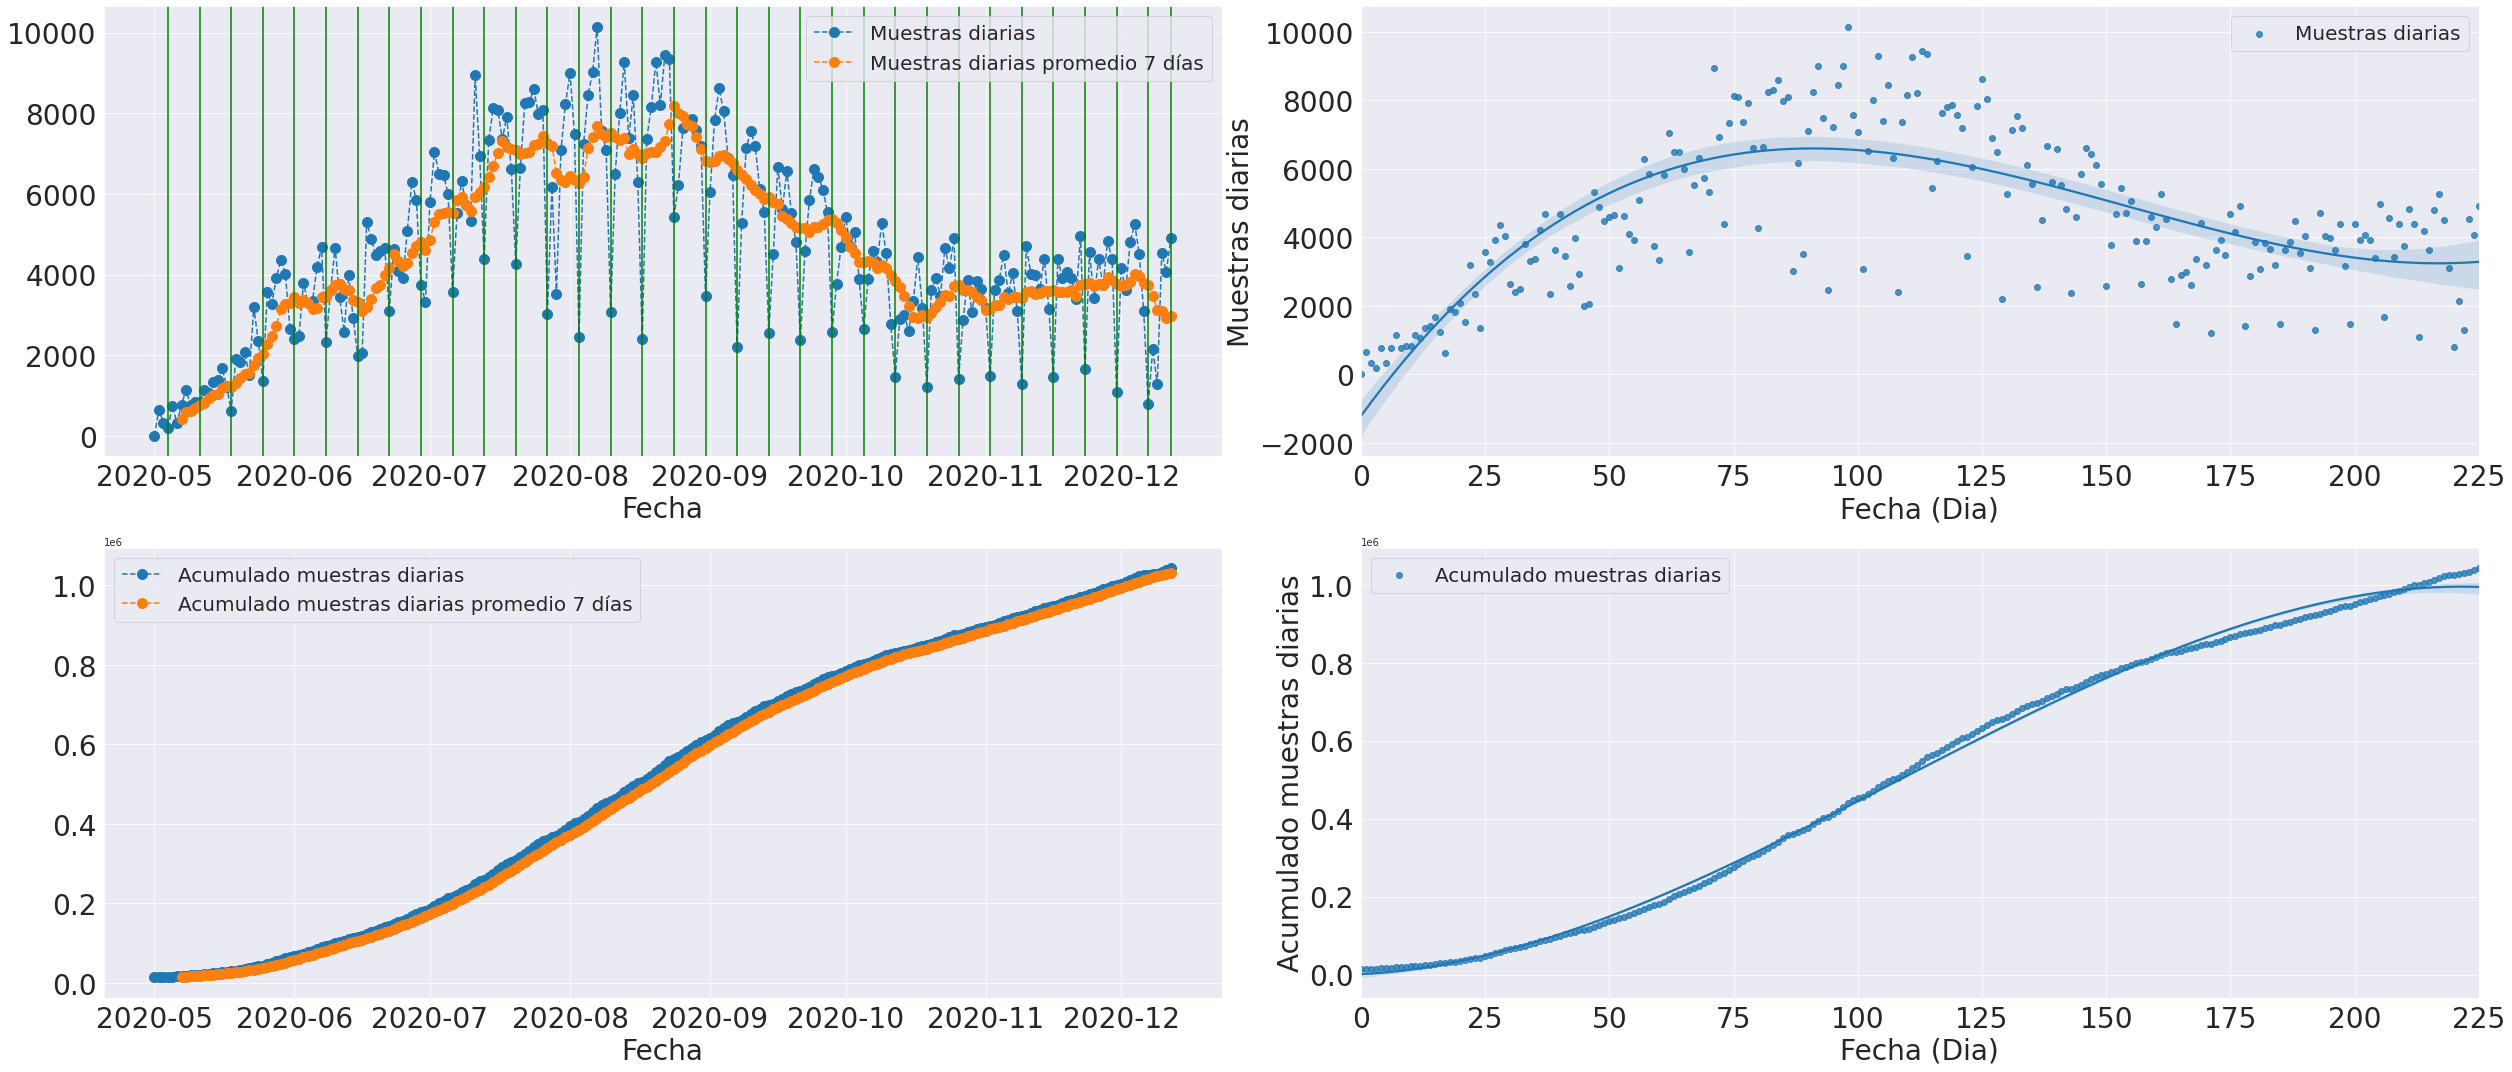

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))
 
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Muestras diarias', 'muestras_diarias')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Muestras diarias', 'dia', 'muestras_diarias')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Acumulado muestras diarias', 'total_muestras')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Acumulado muestras diarias', 'dia', 'total_muestras')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
plt.savefig('image_1.png')
plt.show()

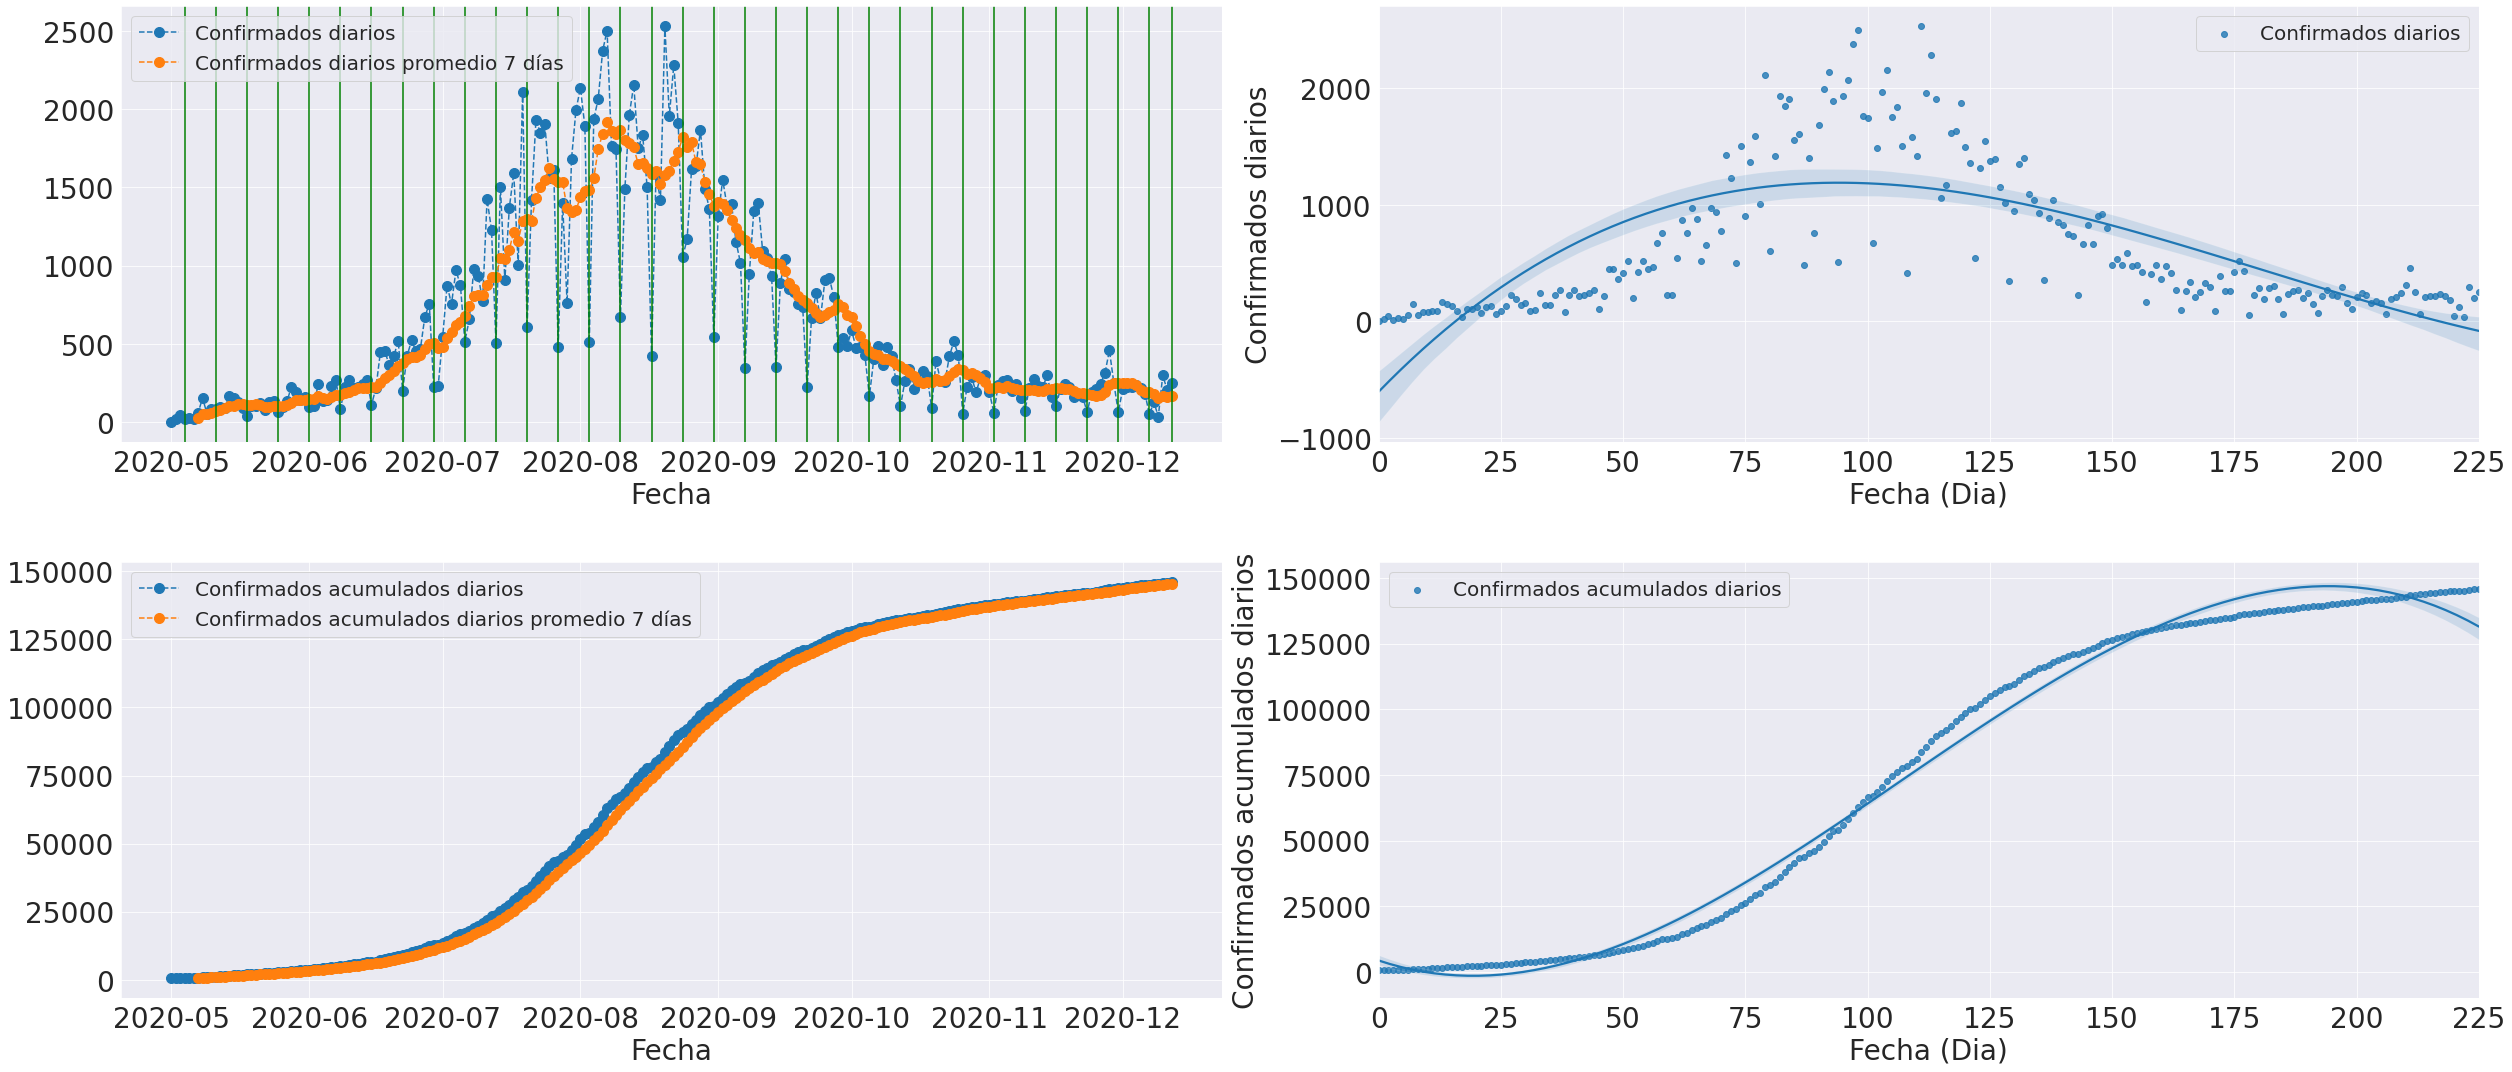

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados diarios', 'confirmados_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados diarios', 'dia', 'confirmados_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados acumulados diarios', 'casos_positivos')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados acumulados diarios', 'dia', 'casos_positivos')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
plt.savefig('image_2.png')
plt.show()

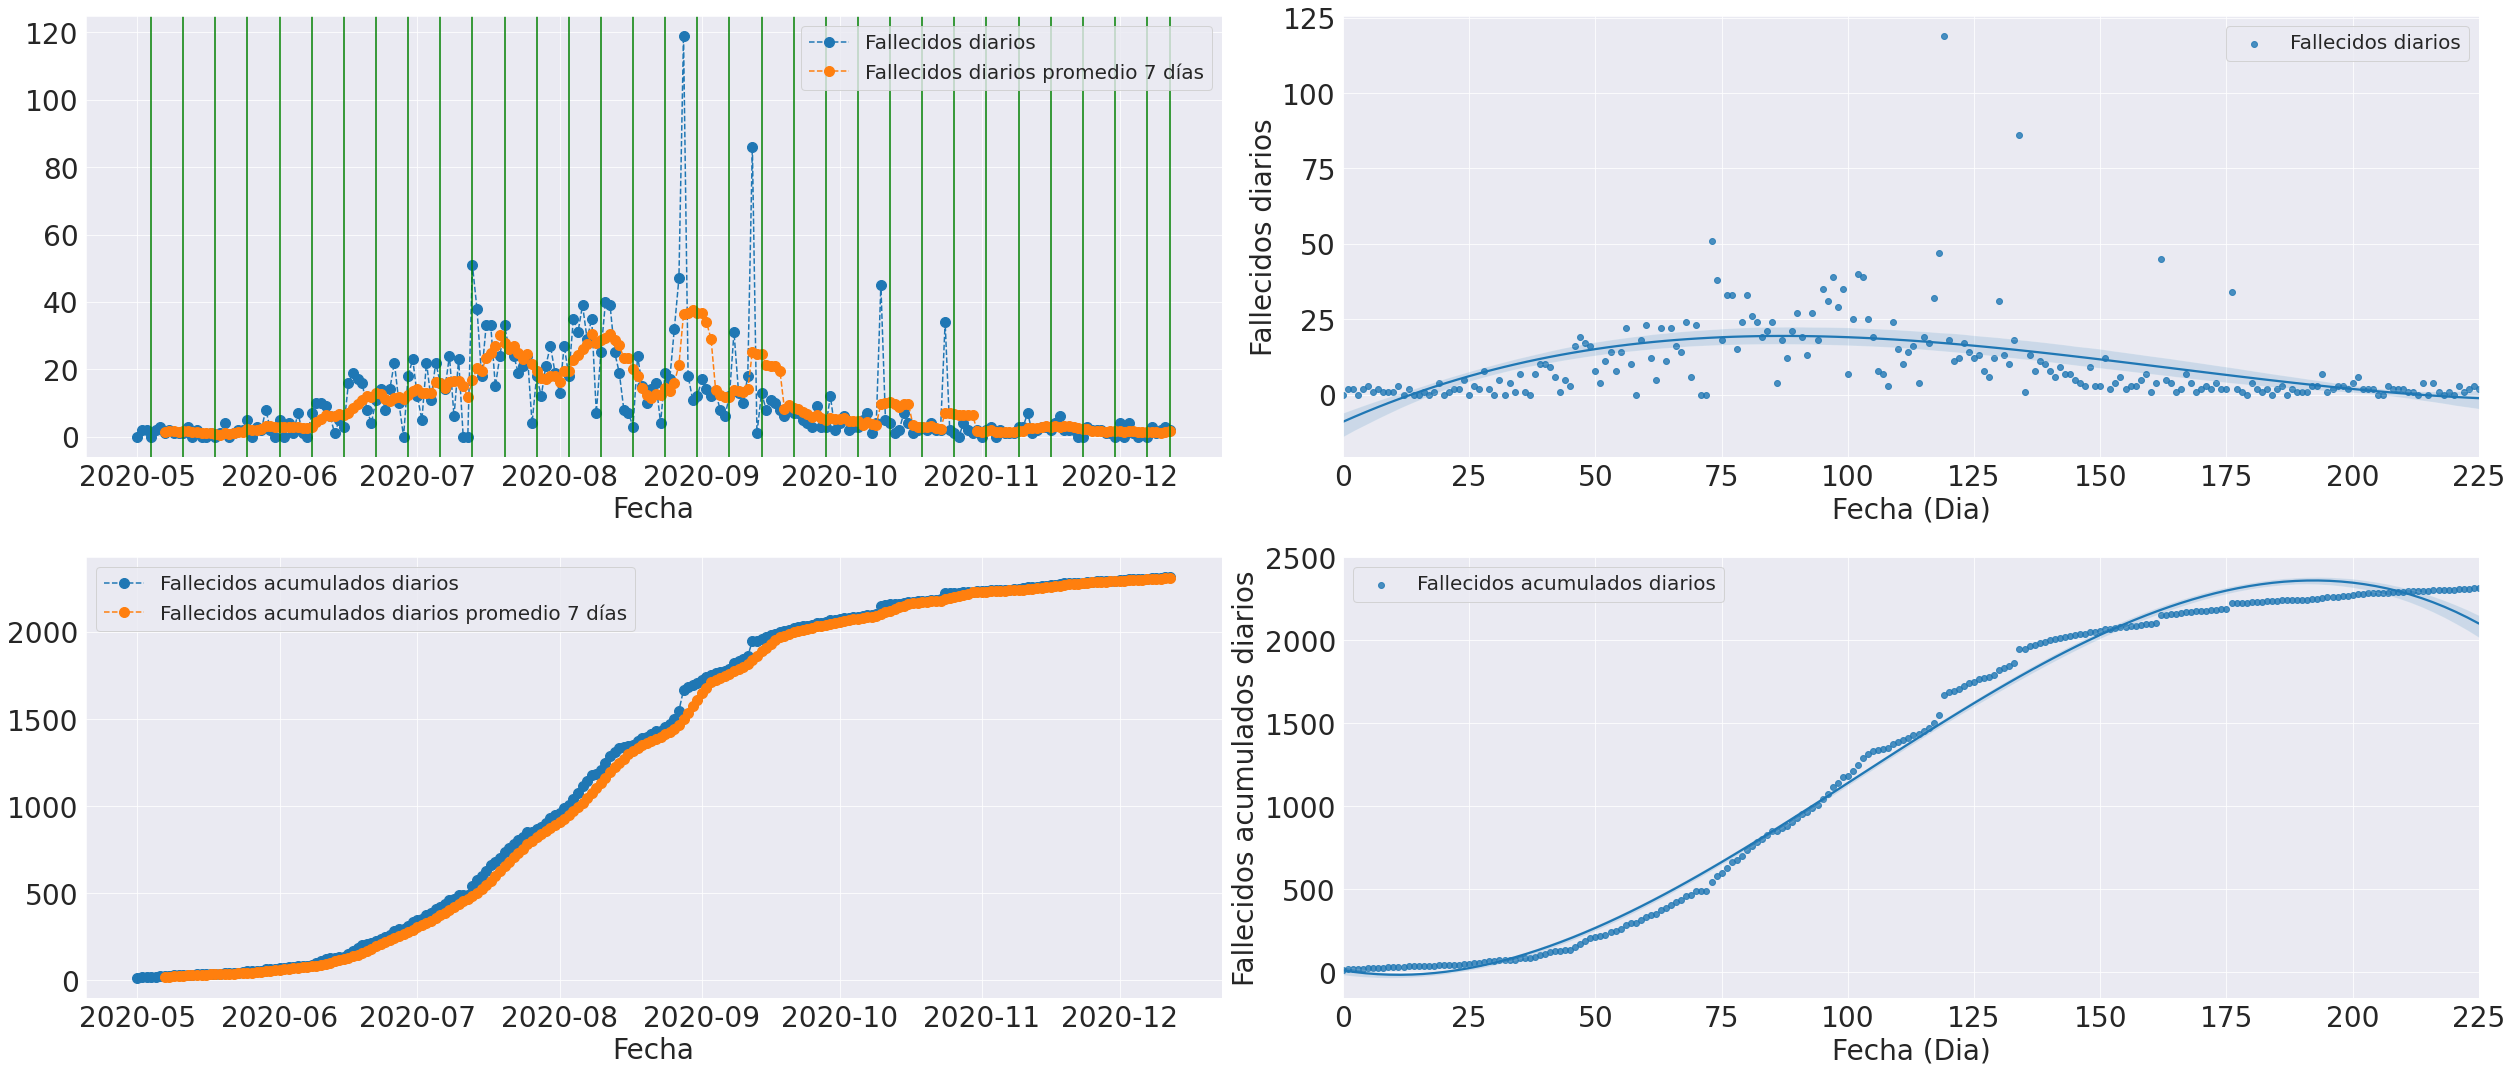

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos diarios', 'fallecidos_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos diarios', 'dia', 'fallecidos_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos acumulados diarios', 'defunciones')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos acumulados diarios', 'dia', 'defunciones')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
plt.savefig('image_3.png')
plt.show()

# Positividad

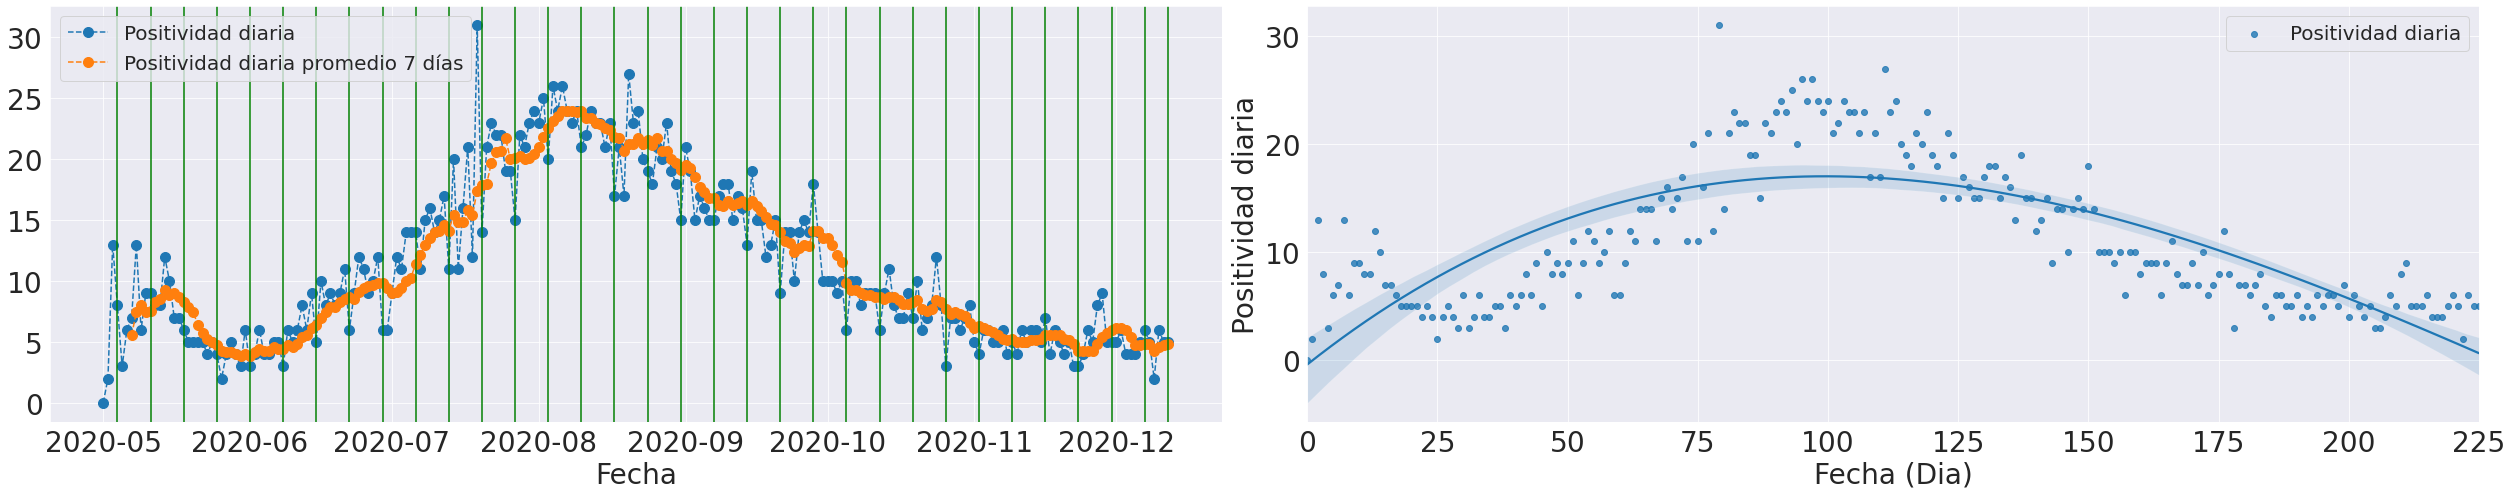

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))
 
plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Positividad diaria', 'positividad')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Positividad diaria', 'dia', 'positividad')
 
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
plt.savefig('image_4.png')
plt.savefig('AQP_Positividad.pdf')
plt.show()

# Factor Salud - Hospitalizados y UCI

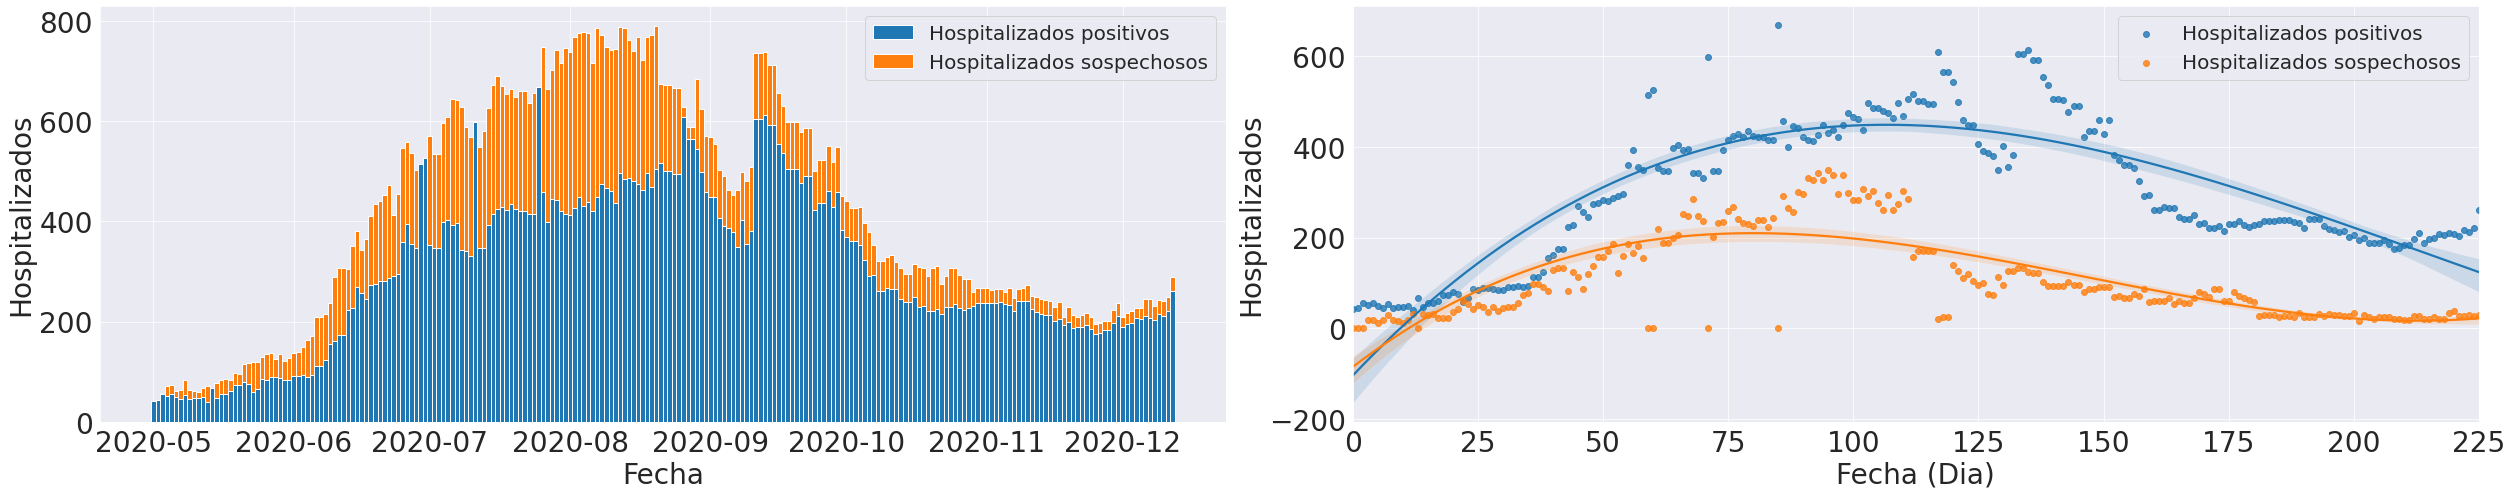

<Figure size 432x288 with 0 Axes>

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))
 
plots(ax1, 'bar_stacked_plt', datos_arequipa, 'Fecha', 'Hospitalizados', 'index', 'hospitalizados')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'Hospitalizados', 'dia', 'hospitalizados')
 
fig.tight_layout()
plt.savefig('image_5.png')
plt.show()
plt.clf()

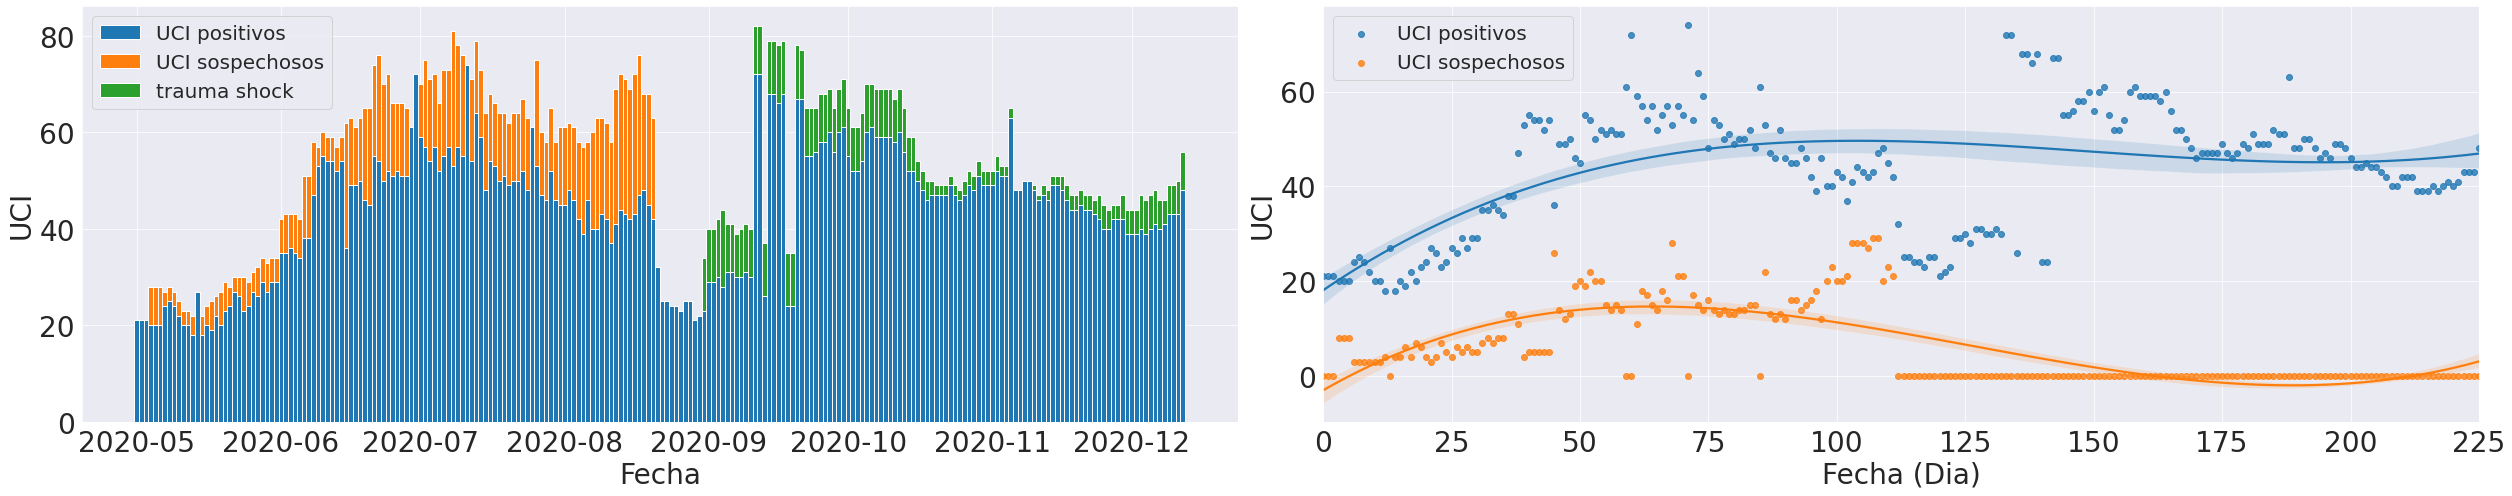

<Figure size 432x288 with 0 Axes>

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))
 
plots(ax1, 'bar_stacked_plt_uci', datos_arequipa, 'Fecha', 'UCI', 'index', 'uci')
plots(ax2, 'line_reg_stacked_sns', datos_arequipa, 'Fecha (Dia)', 'UCI', 'dia', 'uci')
 
fig.tight_layout()
plt.savefig('image_6.png')
plt.show()
plt.clf()

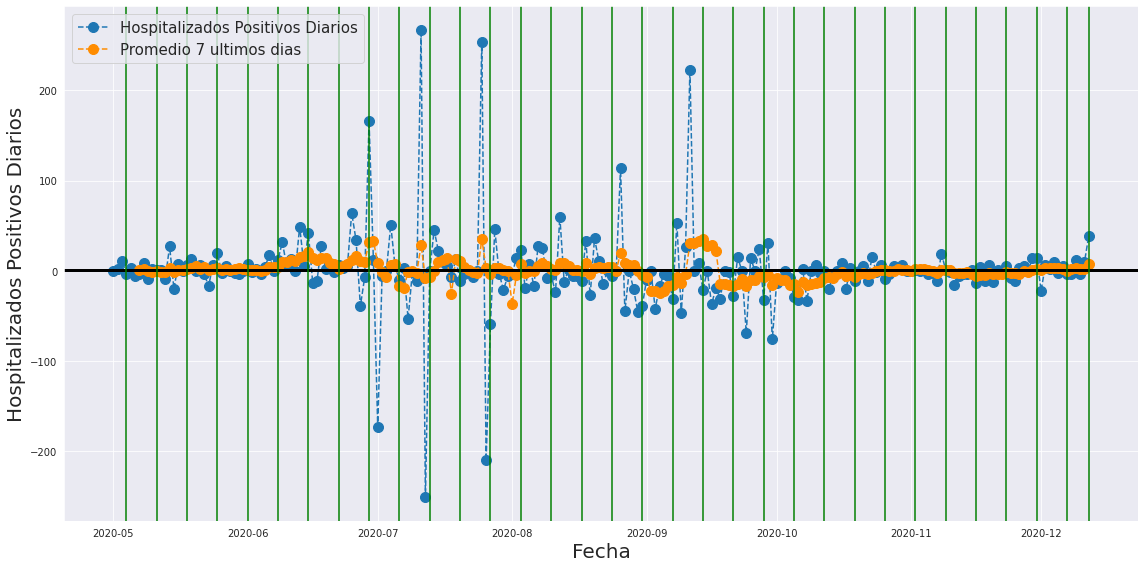

In [24]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Hospitalizados Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'],'--o',ms=10,label='Hospitalizados Positivos Diarios')
ax1.plot(datos_arequipa['hospitalizados_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
 
plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
plt.savefig('image_7.png')
plt.show()

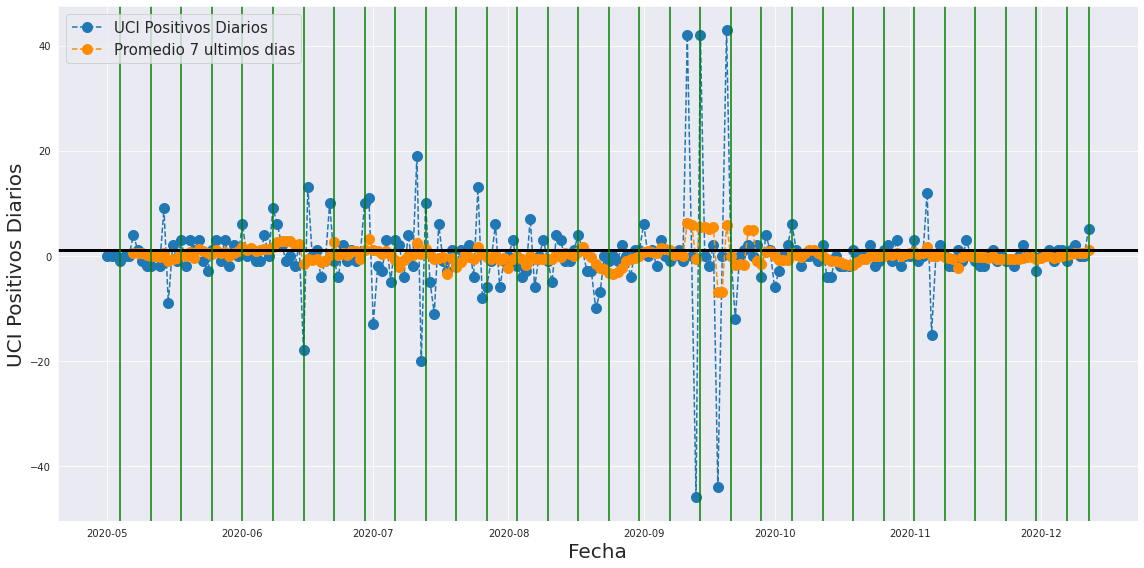

In [25]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
 
ax1.set_ylabel('UCI Positivos Diarios',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
ax1.plot(datos_arequipa['uci_positivos_diarios'],'--o',ms=10,label='UCI Positivos Diarios')
ax1.plot(datos_arequipa['uci_positivos_diarios'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
 
plt.axhline(1, color='k',lw=3)
for date in mondays:
    ax1.axvline(date, color='g')
 
fig.tight_layout()
plt.savefig('image_8.png')
plt.show()

# R Factor - Confirmados

In [26]:
r_confirmados_arequipa = datos_arequipa.loc[:,['confirmados_diarios']]
r_confirmados_arequipa['state'] = 'AREQUIPA'
r_confirmados_arequipa = r_confirmados_arequipa.set_index([r_confirmados_arequipa.index, 'state'])
r_confirmados_arequipa = r_confirmados_arequipa['confirmados_diarios']
display(r_confirmados_arequipa.tail())
r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.01)
#r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.30)
display(r_confirmados.tail())
r_confirmados.to_csv('Rt_Arequipa.csv')

date        state   
2020-12-08  AREQUIPA    127
2020-12-09  AREQUIPA     35
2020-12-10  AREQUIPA    298
2020-12-11  AREQUIPA    204
2020-12-12  AREQUIPA    249
Name: confirmados_diarios, dtype: int64

ML  Low_90  High_90
date       state                          
2020-12-08 AREQUIPA  0.86    0.75     0.98
2020-12-09 AREQUIPA  0.87    0.76     0.99
2020-12-10 AREQUIPA  0.89    0.78     1.01
2020-12-11 AREQUIPA  0.91    0.80     1.03
2020-12-12 AREQUIPA  0.92    0.81     1.04

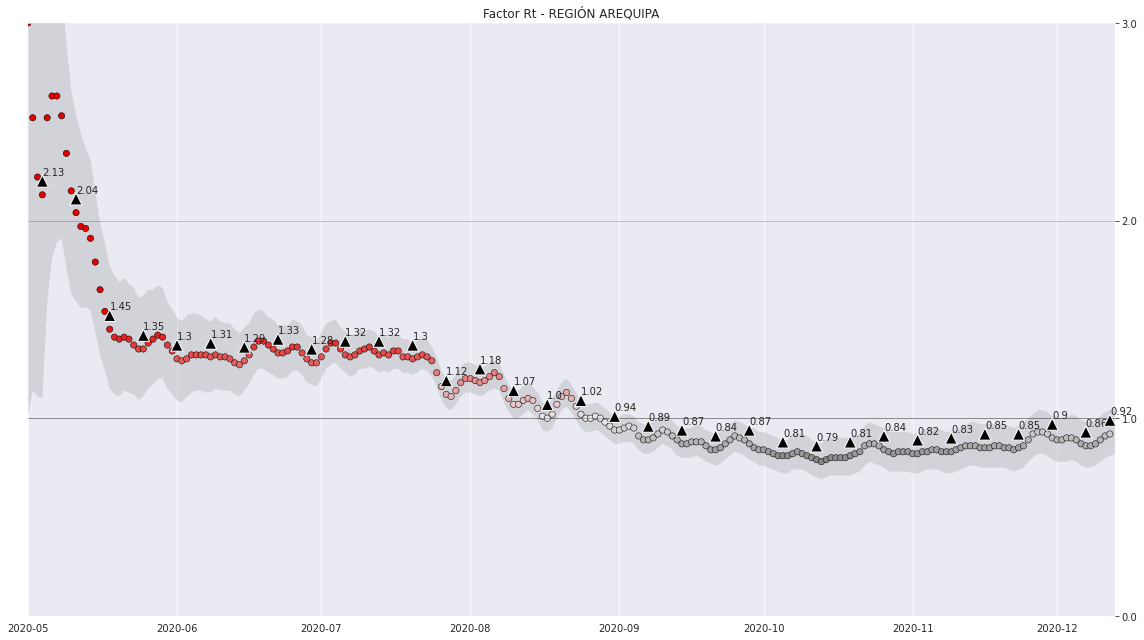

<Figure size 432x288 with 0 Axes>

In [27]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_confirmados, ax, 'Factor Rt - REGIÓN AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.savefig('image_9.png')
plt.savefig('Rt_Arequipa.pdf')
plt.show()
plt.clf()

# R Factor - Fallecidos

In [28]:
r_fallecidos_arequipa = datos_arequipa.loc[:,['fallecidos_diarios']]
r_fallecidos_arequipa['state'] = 'AREQUIPA'
r_fallecidos_arequipa = r_fallecidos_arequipa.set_index([r_fallecidos_arequipa.index, 'state'])
r_fallecidos_arequipa = r_fallecidos_arequipa['fallecidos_diarios']
 
r_fallecidos = run_full_model(r_fallecidos_arequipa, sigma=0.01)

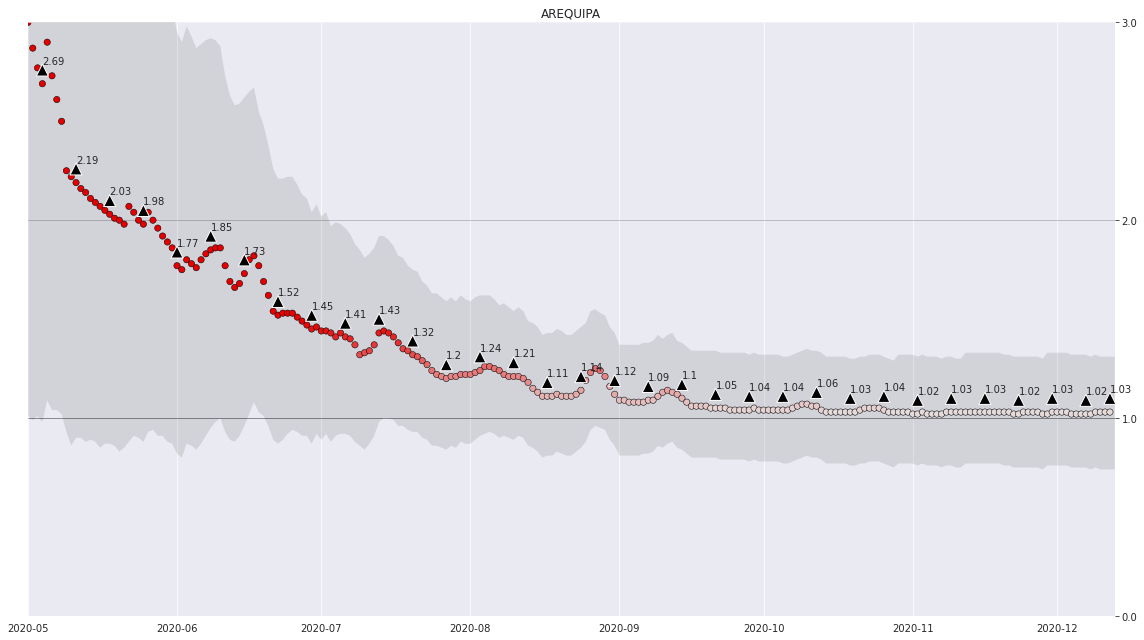

<Figure size 432x288 with 0 Axes>

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_fallecidos, ax, 'AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()

# Plot doubling-time: Casos Positivos

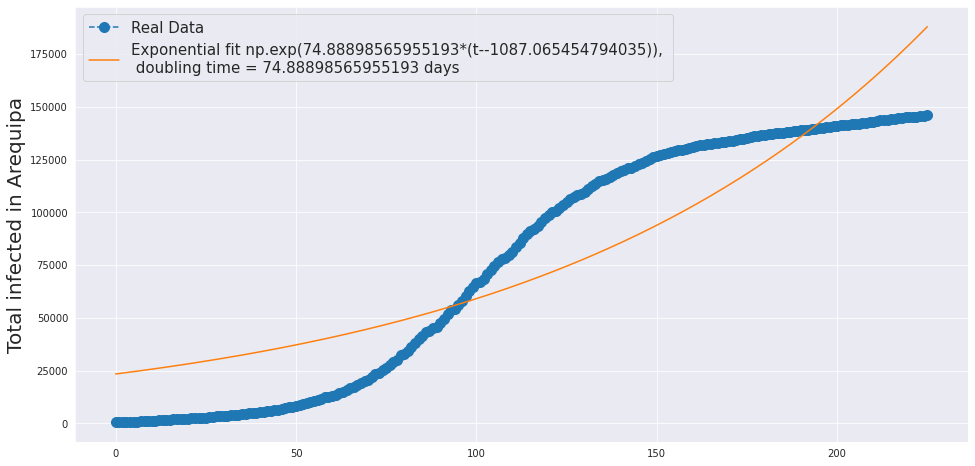

In [30]:
List = []
coeff = prediction_country2(datos_arequipa,'casos_positivos',plot=True)
List.append(coeff)

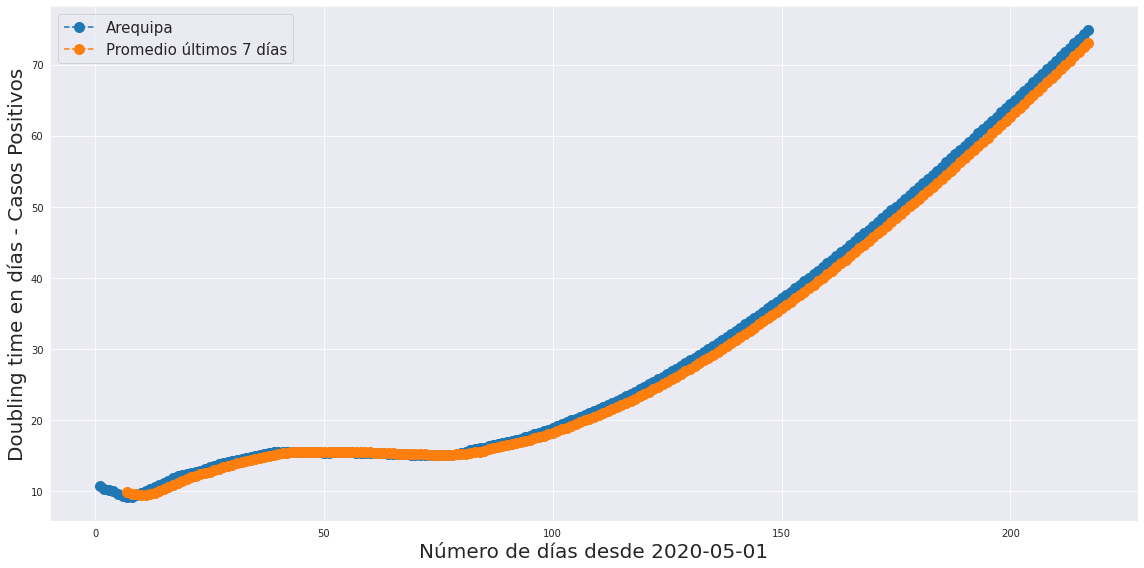

In [31]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')

fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - Casos Positivos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
fig.tight_layout()
plt.savefig('image_10.png')
plt.show()

# Plot doubling-time: Fallecidos

In [32]:
List = []
coeff = prediction_country2(datos_arequipa,'defunciones',plot=False)
List.append(coeff)

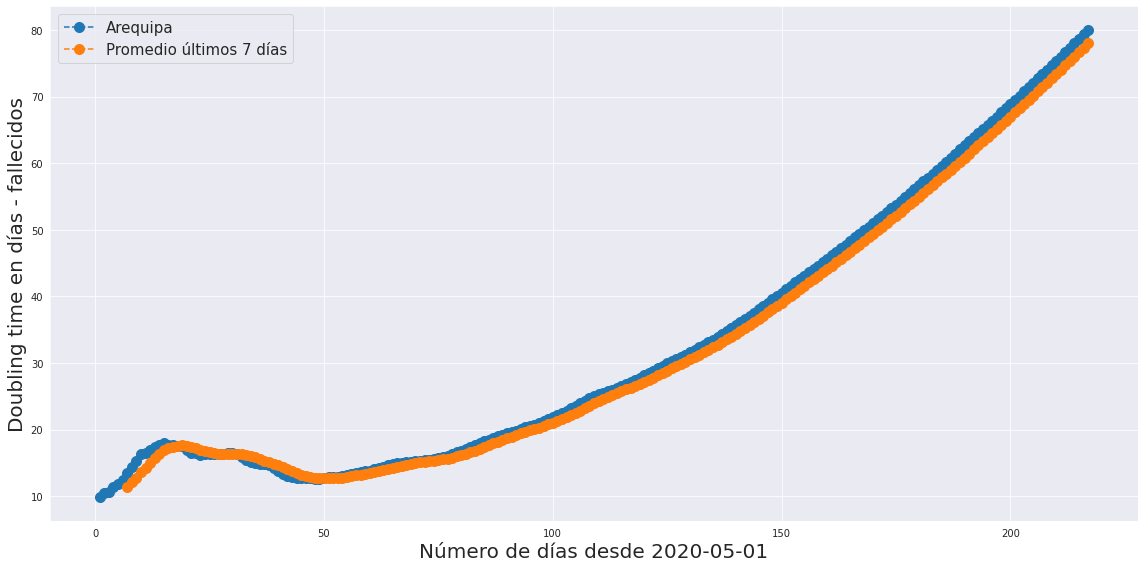

In [33]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - fallecidos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
fig.tight_layout()
plt.savefig('image_11.png')
plt.show()

# Plots - Defunciones, Activos, Recuperados

In [34]:
data_map_arequipa = datos_arequipa.loc[:,['casos_positivos', 'defunciones','recuperados','activos','dia']]
data_map_arequipa['hito1'] = data_map_arequipa['defunciones']
data_map_arequipa['hito2'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos']
data_map_arequipa['hito3'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos'] + data_map_arequipa['recuperados']
data_map_arequipa.tail()

0           casos_positivos  defunciones  recuperados  ...  hito1  hito2   hito3
date                                                   ...                      
2020-12-08           145172         2308       139292  ...   2308   5880  145172
2020-12-09           145207         2309       139489  ...   2309   5718  145207
2020-12-10           145505         2311       139687  ...   2311   5818  145505
2020-12-11           145709         2314       139871  ...   2314   5838  145709
2020-12-12           145958         2316       140076  ...   2316   5882  145958

[5 rows x 8 columns]

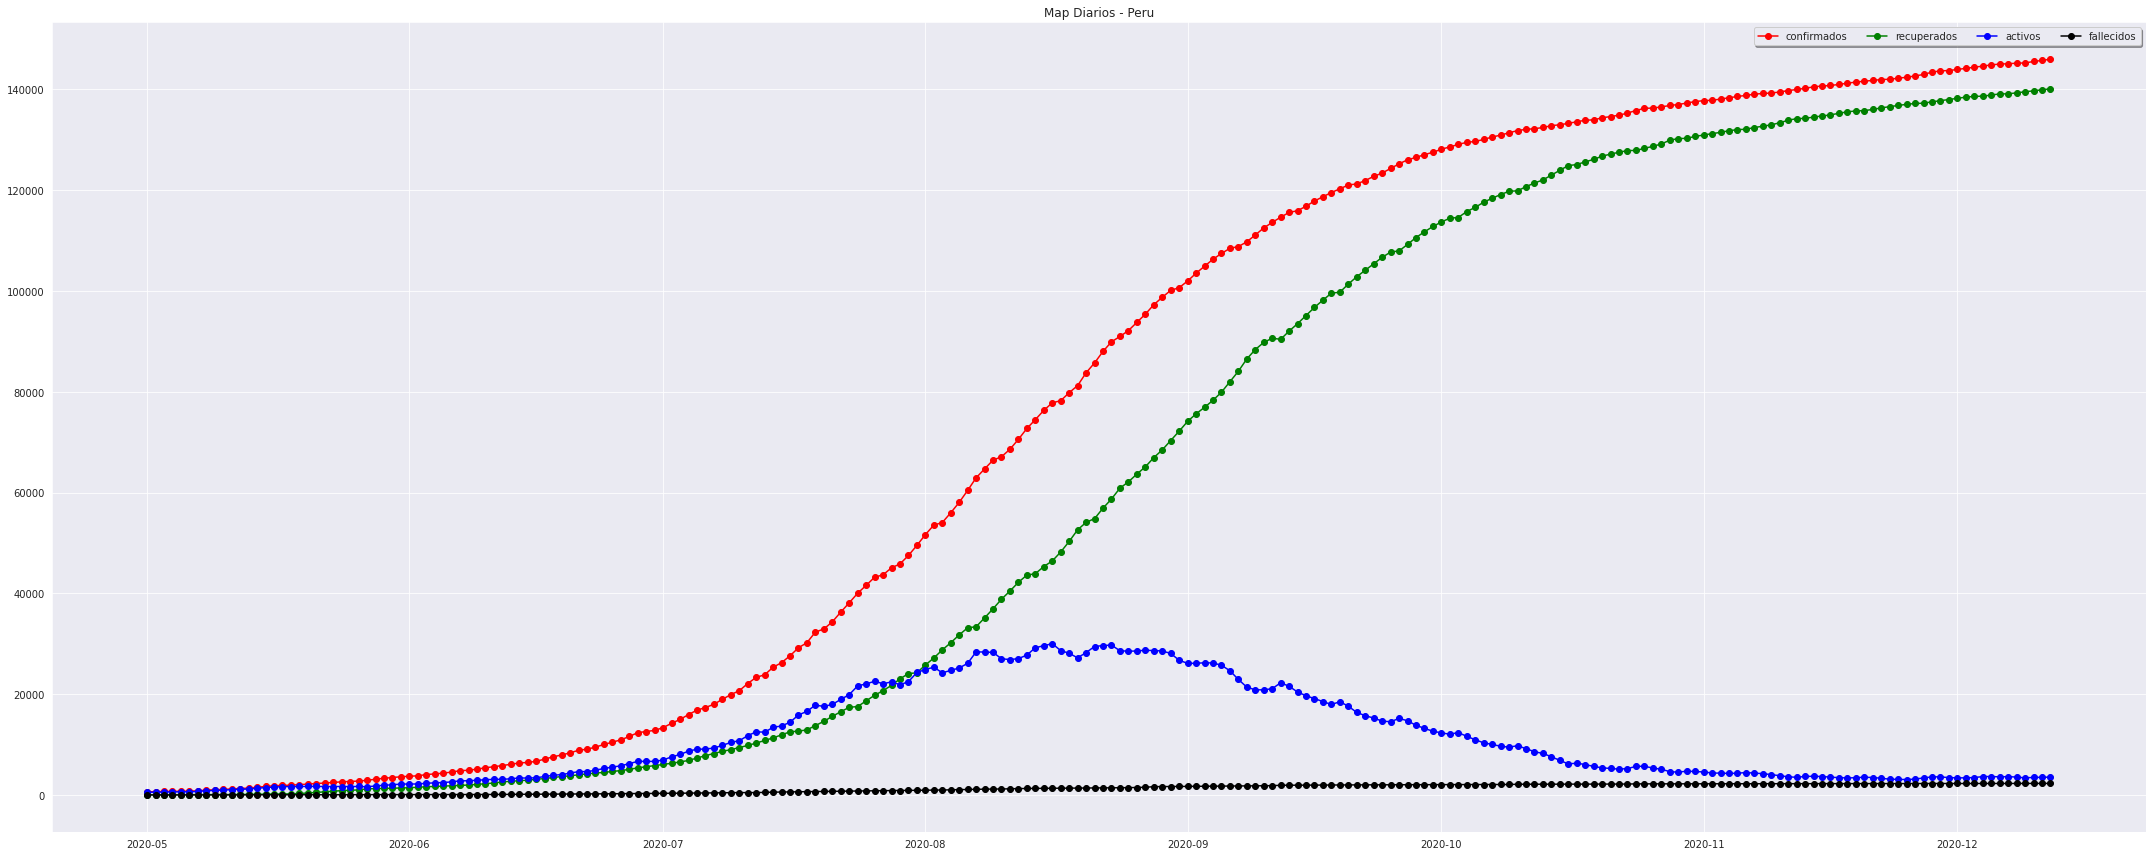

<Figure size 432x288 with 0 Axes>

In [35]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

colors = ['red', 'green', 'blue', 'black']
labels = ['confirmados', 'recuperados', 'activos', 'fallecidos']

ax1.plot_date(data_map_arequipa.index, data_map_arequipa['casos_positivos'], color=colors[0], label=labels[0], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['recuperados'], color=colors[1], label=labels[1], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['activos'], color=colors[2], label=labels[2], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['defunciones'], color=colors[3], label=labels[3], linestyle="-")

ax1.set(title='Map Diarios - Peru')

ax1.legend(fancybox=True, shadow=True, ncol=4)

fig.tight_layout()
plt.savefig('image_12.png')
plt.show()
plt.clf()

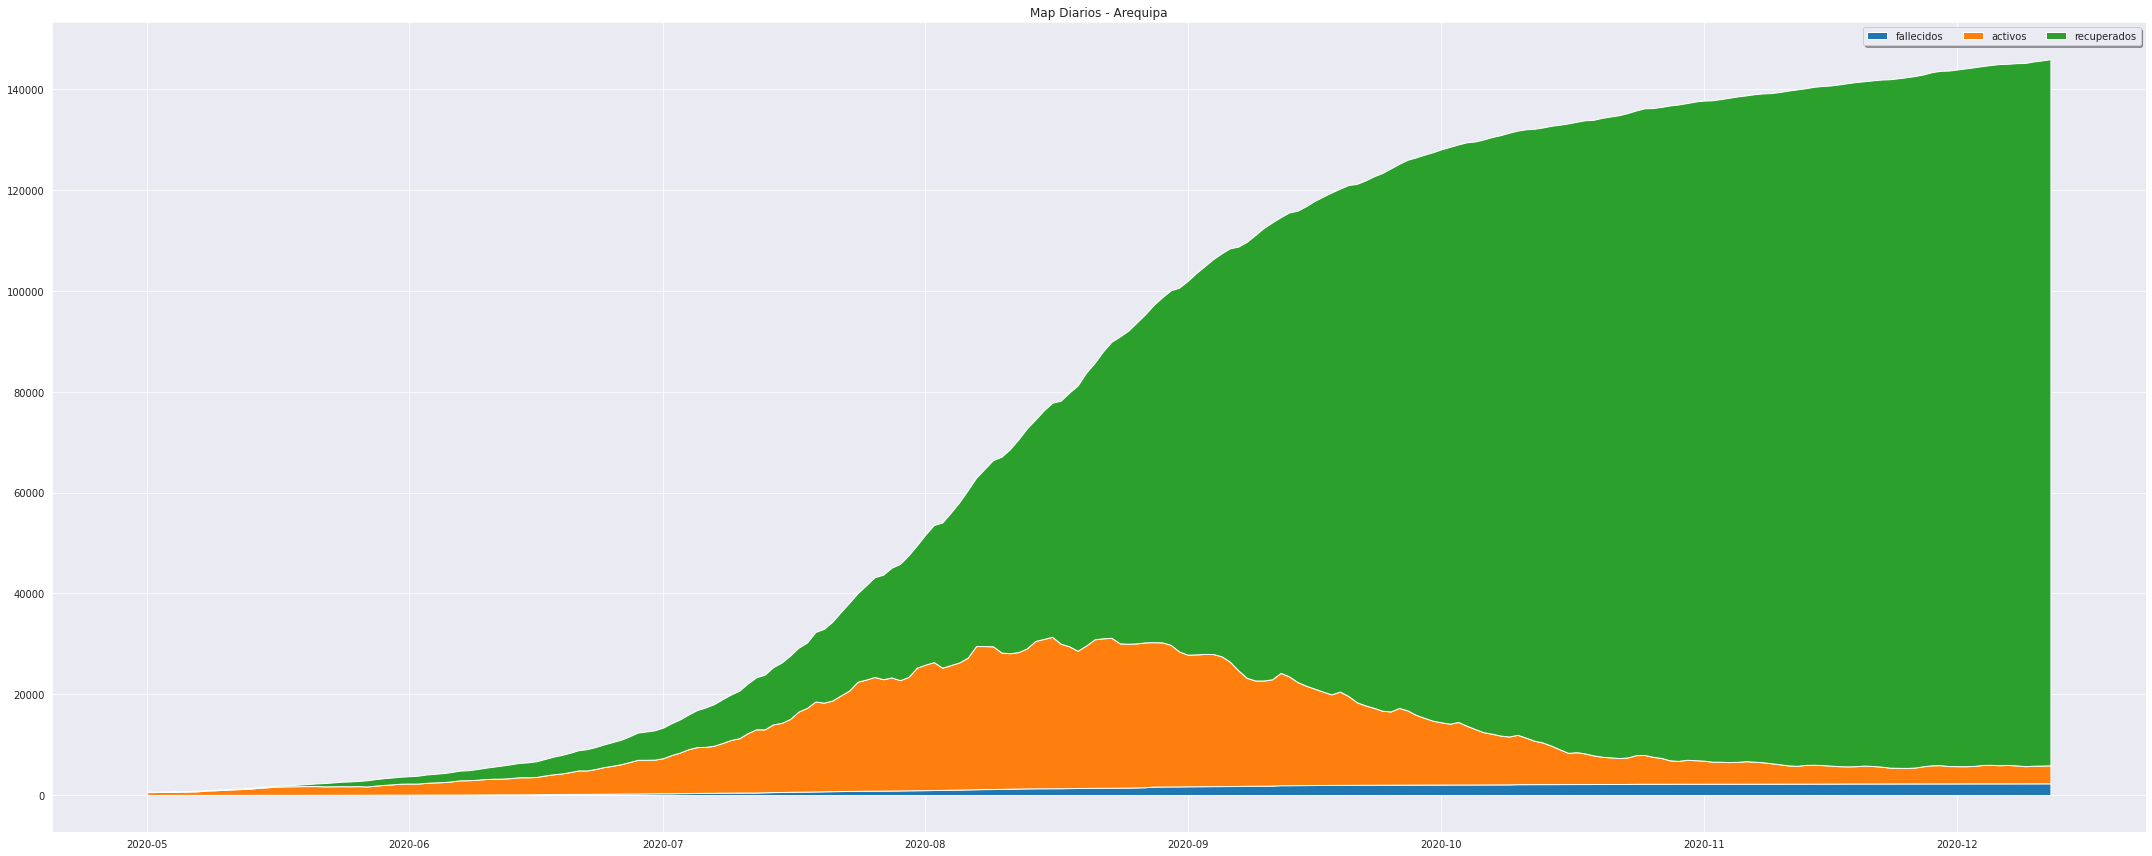

<Figure size 432x288 with 0 Axes>

In [36]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

x1 = data_map_arequipa.index
x2 = data_map_arequipa['hito1']
x3 = data_map_arequipa['hito2']
x4 = data_map_arequipa['hito3']

ax1.fill_between(x1, 0, x2, label='fallecidos')
ax1.fill_between(x1, x2, x3, label='activos')
ax1.fill_between(x1, x3, x4, label='recuperados')

ax1.set(title='Map Diarios - Arequipa')

ax1.legend(fancybox=True, shadow=True, ncol=4)

fig.tight_layout()
plt.savefig('image_13.png')
plt.show()
plt.clf()

#Plots - Confirmados diarios vs Recuperados diarios

In [37]:
daily_confirmados_vs_recuperados = datos_arequipa.loc[:,['confirmados_diarios','recuperados_diarios']]
daily_confirmados_vs_recuperados['diario_c_vs_r'] = daily_confirmados_vs_recuperados.recuperados_diarios / \
                                                    daily_confirmados_vs_recuperados.confirmados_diarios

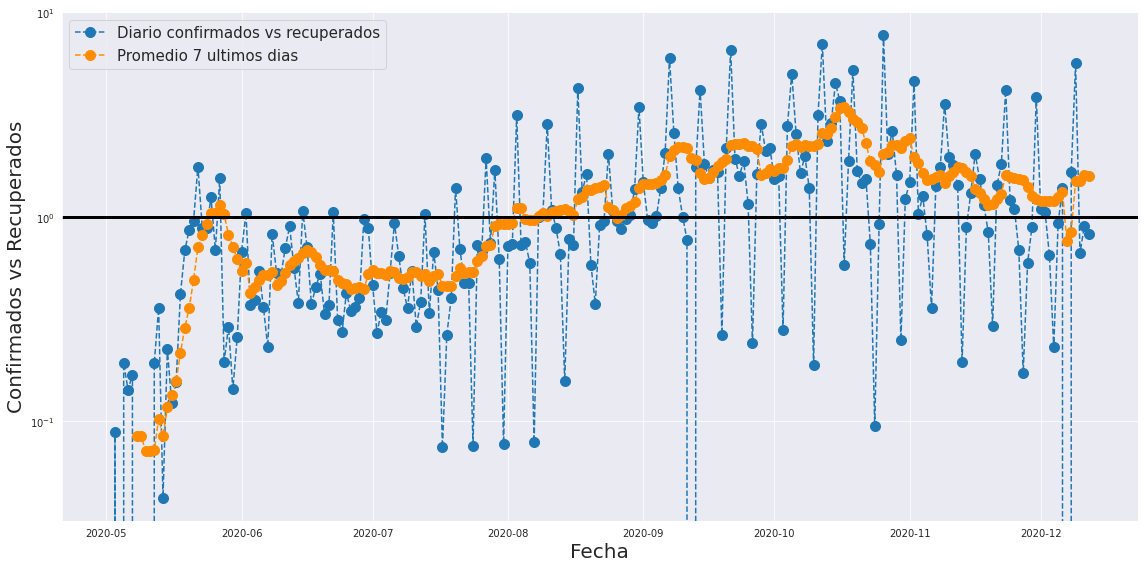

In [38]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Confirmados vs Recuperados',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
#ax1.bar(daily_confirmados_vs_recuperados.index, daily_confirmados_vs_recuperados['diario_c_vs_r'],label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'],'--o',ms=10,label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='darkorange')
ax1.legend(fontsize=15)
ax1.set_yscale('log')

plt.axhline(1, color='k',lw=3)
fig.tight_layout()
plt.savefig('image_14.png')
plt.show()

# SIR Function

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10',
               ...
               '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06',
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-12'],
              dtype='datetime64[ns]', name='date', length=226, freq=None)


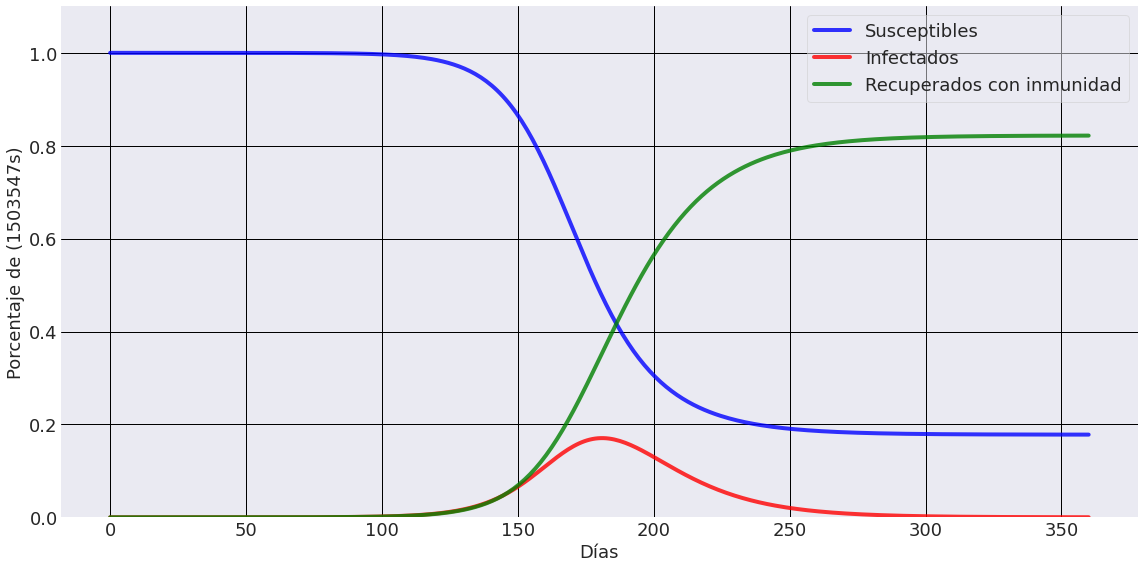

In [39]:
from scipy.integrate import odeint

# Total population, Arequipa
N = 1503547
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.15, 1/14    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 360, 360)
print(datos_arequipa.index)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(16,8))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.8, lw=4, label='Susceptibles')
ax.plot(t, I/N, 'r', alpha=0.8, lw=4, label='Infectados')
ax.plot(t, R/N, 'g', alpha=0.8, lw=4, label='Recuperados con inmunidad')
ax.set_xlabel('Días',fontsize=18)
ax.set_ylabel('Porcentaje de ('+str(N)+'s)',fontsize=18)
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0,labelsize=18)
ax.xaxis.set_tick_params(length=0,labelsize=18)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend(fontsize=18)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
fig.tight_layout()
plt.savefig('image_15.png')
plt.savefig('SIR_Model.pdf')

plt.show()

# Análisis por días de contagio


***Para realizar este estudio utilizaremos los datos del MINSA (Ministerio de Salud), recordando siempre que existen un deficit en el total de contagios reales vs reportados a esta institución***

In [40]:
datos_minsa

ï»¿FECHA_CORTE  ... FECHA_RESULTADO
0             20201209  ...      20200527.0
1             20201209  ...      20200511.0
2             20201209  ...      20200411.0
3             20201209  ...      20200411.0
4             20201209  ...      20200415.0
...                ...  ...             ...
979106        20201209  ...      20201120.0
979107        20201209  ...      20201127.0
979108        20201209  ...      20201129.0
979109        20201209  ...      20201129.0
979110        20201209  ...      20201128.0

[979111 rows x 9 columns]

In [41]:
# Si el archivo fue descargado ejecutar esta celda y comentar la tercera linea de la celda siguiente
########################################################################
datos_minsa.sort_values('FECHA_RESULTADO', inplace=True)
datos_minsa.dropna(inplace=True)
datos_minsa['FECHA_RESULTADO'] = datos_minsa['FECHA_RESULTADO'].astype(str)
datos_minsa.reset_index(drop=True, inplace=True)
datos_minsa['FECHA_RESULTADO'] = pd.to_datetime(datos_minsa['FECHA_RESULTADO'].apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:8]))

In [42]:
datos_minsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978205 entries, 0 to 978204
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ï»¿FECHA_CORTE   978205 non-null  int64         
 1   UUID             978205 non-null  object        
 2   DEPARTAMENTO     978205 non-null  object        
 3   PROVINCIA        978205 non-null  object        
 4   DISTRITO         978205 non-null  object        
 5   METODODX         978205 non-null  object        
 6   EDAD             978205 non-null  float64       
 7   SEXO             978205 non-null  object        
 8   FECHA_RESULTADO  978205 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 67.2+ MB


In [43]:
datos_minsa['EDAD'] = datos_minsa['EDAD'].fillna(0)
datos_minsa['EDAD'] = datos_minsa['EDAD'].astype('int')

datos_minsa['ï»¿FECHA_CORTE'] = datos_minsa['ï»¿FECHA_CORTE'].fillna(0)
datos_minsa['ï»¿FECHA_CORTE'] = datos_minsa['ï»¿FECHA_CORTE'].astype('int')
#datos_minsa['FECHA_RESULTADO'] = pd.to_datetime(datos_minsa['FECHA_RESULTADO'], dayfirst=True)

#datos_minsa = datos_minsa.apply(lambda x: x.str.upper() if x.dtype == "object" else x)  
datos_minsa['UUID'] = datos_minsa['UUID'].str.upper()
datos_minsa['DEPARTAMENTO'] = datos_minsa['DEPARTAMENTO'].str.upper()
datos_minsa['PROVINCIA'] = datos_minsa['PROVINCIA'].str.upper()
datos_minsa['DISTRITO'] = datos_minsa['DISTRITO'].str.upper()
datos_minsa['METODODX'] = datos_minsa['METODODX'].str.upper()
datos_minsa['SEXO'] = datos_minsa['SEXO'].str.upper()

In [44]:
display(datos_minsa.info())
display(datos_minsa.sort_values('FECHA_RESULTADO'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978205 entries, 0 to 978204
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ï»¿FECHA_CORTE   978205 non-null  int64         
 1   UUID             978205 non-null  object        
 2   DEPARTAMENTO     978205 non-null  object        
 3   PROVINCIA        978205 non-null  object        
 4   DISTRITO         978205 non-null  object        
 5   METODODX         978205 non-null  object        
 6   EDAD             978205 non-null  int64         
 7   SEXO             978205 non-null  object        
 8   FECHA_RESULTADO  978205 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 67.2+ MB


None

ï»¿FECHA_CORTE  ... FECHA_RESULTADO
0             20201209  ...      2020-03-06
1             20201209  ...      2020-03-07
2             20201209  ...      2020-03-07
3             20201209  ...      2020-03-07
4             20201209  ...      2020-03-07
...                ...  ...             ...
977677        20201209  ...      2020-12-09
977678        20201209  ...      2020-12-09
977679        20201209  ...      2020-12-09
977681        20201209  ...      2020-12-09
978204        20201209  ...      2020-12-09

[978205 rows x 9 columns]

In [45]:
datos_minsa_cut = datos_minsa.query('FECHA_RESULTADO >= \"2020-03-29\"')

In [46]:
datos_minsa_cut = datos_minsa_cut.reset_index(drop=True)
display(datos_minsa_cut.info())
display(datos_minsa_cut.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977411 entries, 0 to 977410
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ï»¿FECHA_CORTE   977411 non-null  int64         
 1   UUID             977411 non-null  object        
 2   DEPARTAMENTO     977411 non-null  object        
 3   PROVINCIA        977411 non-null  object        
 4   DISTRITO         977411 non-null  object        
 5   METODODX         977411 non-null  object        
 6   EDAD             977411 non-null  int64         
 7   SEXO             977411 non-null  object        
 8   FECHA_RESULTADO  977411 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 67.1+ MB


None

ï»¿FECHA_CORTE  ... FECHA_RESULTADO
977406        20201209  ...      2020-12-09
977407        20201209  ...      2020-12-09
977408        20201209  ...      2020-12-09
977409        20201209  ...      2020-12-09
977410        20201209  ...      2020-12-09

[5 rows x 9 columns]

In [47]:
display(datos_minsa_cut['FECHA_RESULTADO'].min())
display(datos_minsa_cut['FECHA_RESULTADO'].max())

Timestamp('2020-03-29 00:00:00')

Timestamp('2020-12-09 00:00:00')

In [48]:
df_arequipa_dep = datos_minsa_cut[datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA']
df_arequipa_dep['WEEKDAY'] = df_arequipa_dep['FECHA_RESULTADO'].dt.weekday
df_arequipa_dep = df_arequipa_dep.reset_index(drop=True)
display(df_arequipa_dep.shape)
display(df_arequipa_dep.tail())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(46872, 10)

ï»¿FECHA_CORTE  ... WEEKDAY
46867        20201209  ...       2
46868        20201209  ...       2
46869        20201209  ...       2
46870        20201209  ...       2
46871        20201209  ...       2

[5 rows x 10 columns]

PROVINCIA          SEXO     
AREQUIPA           MASCULINO    20903
                   FEMENINO     19476
ISLAY              MASCULINO      877
CAYLLOMA           MASCULINO      874
ISLAY              FEMENINO       869
CAYLLOMA           FEMENINO       844
CAMANA             MASCULINO      550
                   FEMENINO       506
CARAVELI           MASCULINO      380
                   FEMENINO       336
CASTILLA           MASCULINO      282
                   FEMENINO       252
EN INVESTIGACIÃN  FEMENINO       216
                   MASCULINO      212
CONDESUYOS         MASCULINO      165
                   FEMENINO        74
LA UNION           MASCULINO       31
                   FEMENINO        25
Name: UUID, dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0, flags=flags)


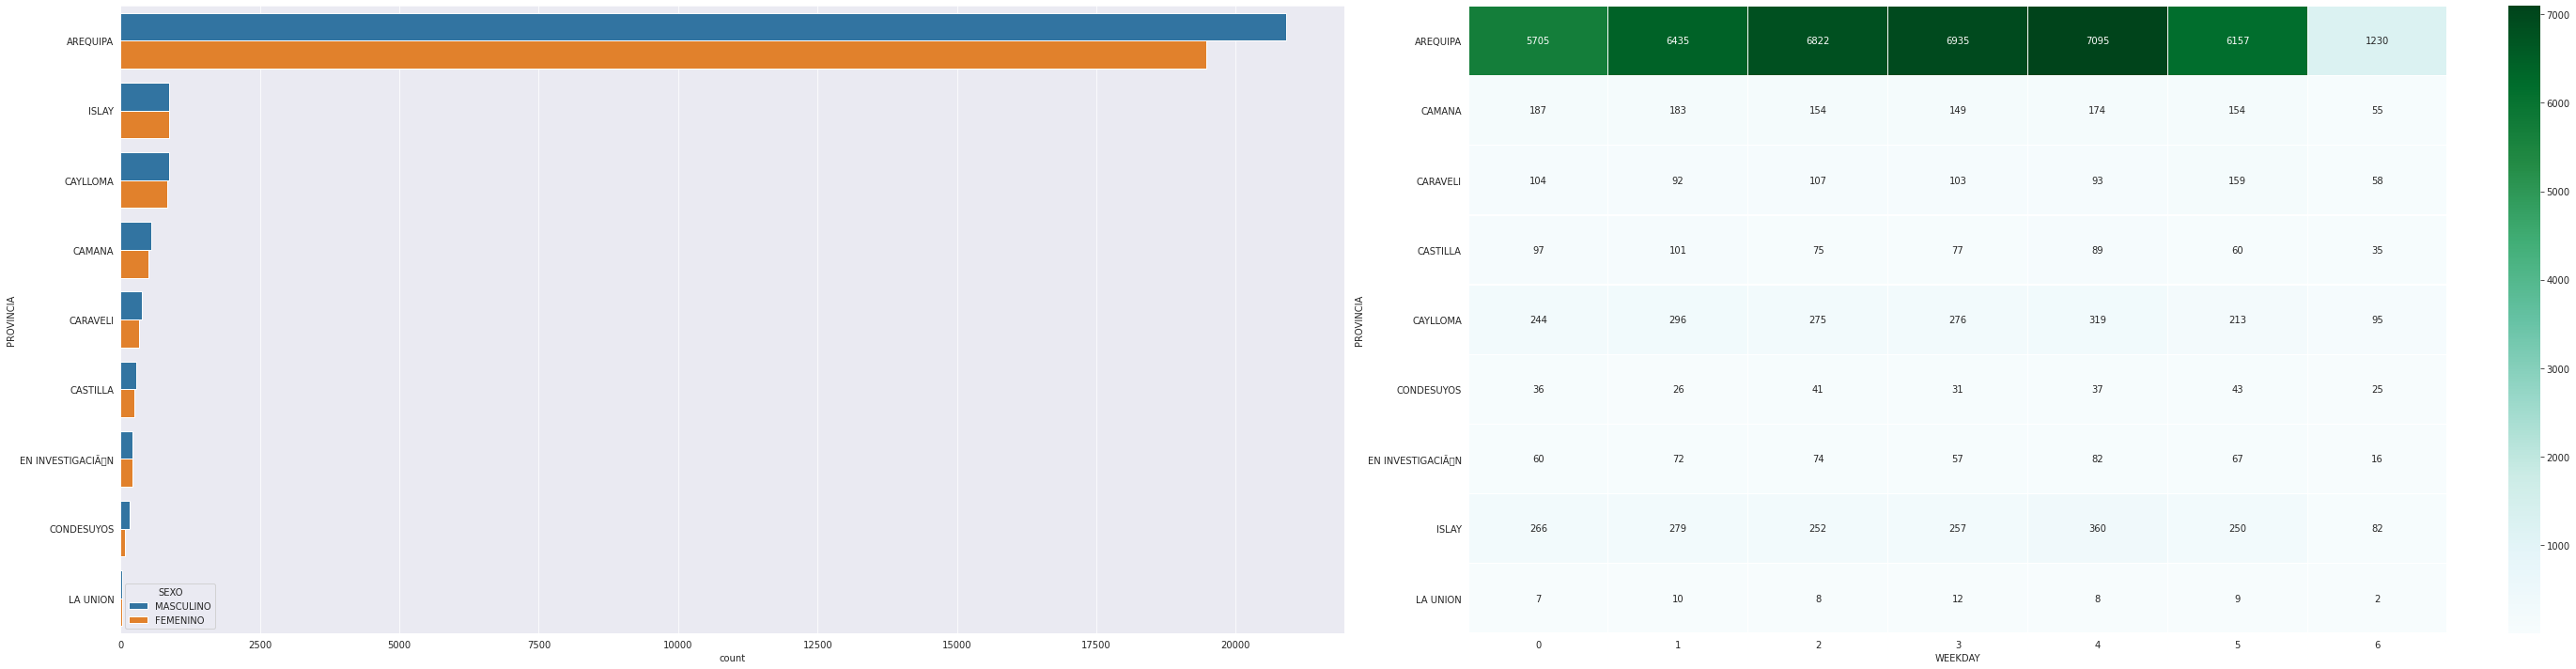

In [49]:
pd_arequipa_dep_crosstab = pd.crosstab(df_arequipa_dep["PROVINCIA"], df_arequipa_dep["WEEKDAY"])

display(df_arequipa_dep.groupby(['PROVINCIA', 'SEXO'])['UUID'].count().sort_values(ascending=False))

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_dep, y='PROVINCIA', order = df_arequipa_dep['PROVINCIA'].value_counts().index, hue='SEXO', ax = ax1)
sns.heatmap(pd_arequipa_dep_crosstab, cmap="BuGn", linewidths=0.3, annot=True, fmt="d", ax = ax2)
fig.tight_layout()
plt.savefig('image_16.png')
plt.show()

In [50]:
df_arequipa_pro = datos_minsa_cut[(datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA') & (datos_minsa_cut['PROVINCIA'] == 'AREQUIPA')].reset_index(drop=True)
df_arequipa_pro['WEEKDAY'] = df_arequipa_pro['FECHA_RESULTADO'].dt.weekday
display(df_arequipa_pro.shape)
display(df_arequipa_pro.tail())

(40379, 10)

ï»¿FECHA_CORTE  ... WEEKDAY
40374        20201209  ...       2
40375        20201209  ...       2
40376        20201209  ...       2
40377        20201209  ...       2
40378        20201209  ...       2

[5 rows x 10 columns]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 145 missing from current font.
  font.set_text(s, 0, flags=flags)


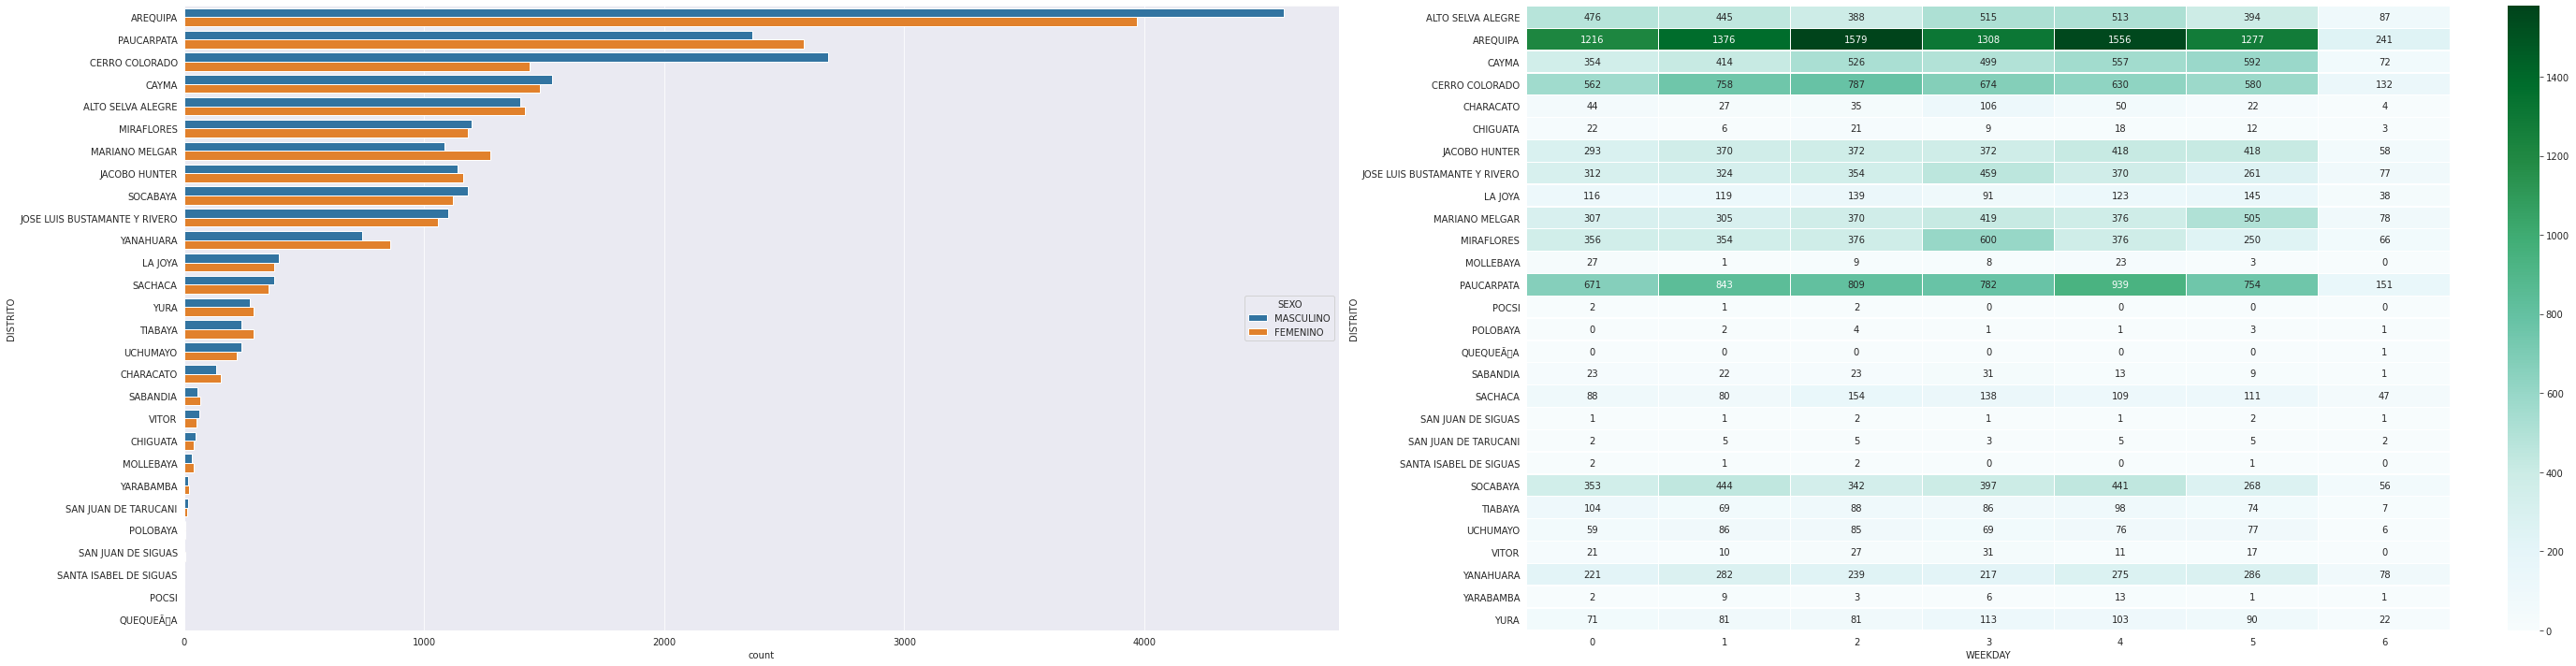

In [51]:
pd_arequipa_pro_crosstab = pd.crosstab(df_arequipa_pro["DISTRITO"], df_arequipa_pro["WEEKDAY"])

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_pro, y='DISTRITO', order = df_arequipa_pro['DISTRITO'].value_counts().index, hue = 'SEXO', ax = ax1)
sns.heatmap(pd_arequipa_pro_crosstab, cmap="BuGn", linewidths=0.3, annot=True, fmt="d", ax = ax2)
fig.tight_layout()
plt.savefig('image_17.png')
plt.show()

In [52]:
df_arequipa_pro

ï»¿FECHA_CORTE  ... WEEKDAY
0            20201209  ...       6
1            20201209  ...       6
2            20201209  ...       6
3            20201209  ...       6
4            20201209  ...       6
...               ...  ...     ...
40374        20201209  ...       2
40375        20201209  ...       2
40376        20201209  ...       2
40377        20201209  ...       2
40378        20201209  ...       2

[40379 rows x 10 columns]

# Análisis por etapas y edad de las personas

In [53]:
df_arequipa_pro['ETAPA'] = df_arequipa_pro['EDAD'].apply(lambda x: 
                              'INFANCIA(0-6)' if x <= 6 
                              else 'NIÑEZ(7-12)' if x <= 12 
                              else 'ADOLESCENCIA(13-20)' if x <= 20
                              else 'JUVENTUD(21-25)' if x <= 25
                              #else 'ADULTEZ_JOVEN' if x <= 40
                              #else 'ADULTEZ_INTERMEDIA' if x <= 50
                              #else 'ADULTEZ_TARDIA' if x <= 60 
                              else 'ADULTEZ(26-60)' if x <= 60 
                              else 'ANCIANIDAD(60+)') 

In [54]:
df_etapas = df_arequipa_pro.groupby(['ETAPA', 'FECHA_RESULTADO']).size().reset_index().pivot(columns='ETAPA', index='FECHA_RESULTADO', values=0)
df_etapas.fillna(0, inplace=True)
df_etapas = df_etapas[['INFANCIA(0-6)', 'NIÑEZ(7-12)', 'ADOLESCENCIA(13-20)', 'JUVENTUD(21-25)', 'ADULTEZ(26-60)', 'ANCIANIDAD(60+)']]
df_etapas

ETAPA            INFANCIA(0-6)  NIÑEZ(7-12)  ...  ADULTEZ(26-60)  ANCIANIDAD(60+)
FECHA_RESULTADO                              ...                                 
2020-03-29                 0.0          1.0  ...             2.0              2.0
2020-03-30                 0.0          0.0  ...             2.0              3.0
2020-03-31                 0.0          0.0  ...             3.0              0.0
2020-04-02                 0.0          0.0  ...             1.0              4.0
2020-04-04                 0.0          1.0  ...            10.0              1.0
...                        ...          ...  ...             ...              ...
2020-12-04                 0.0          0.0  ...            28.0              6.0
2020-12-05                 0.0          2.0  ...            18.0              4.0
2020-12-07                 0.0          1.0  ...            17.0              6.0
2020-12-08                 0.0          0.0  ...             2.0              0.0
2020-12-09                 1.0          2.0  ...            29.0             22.0

[252 rows x 6 columns]

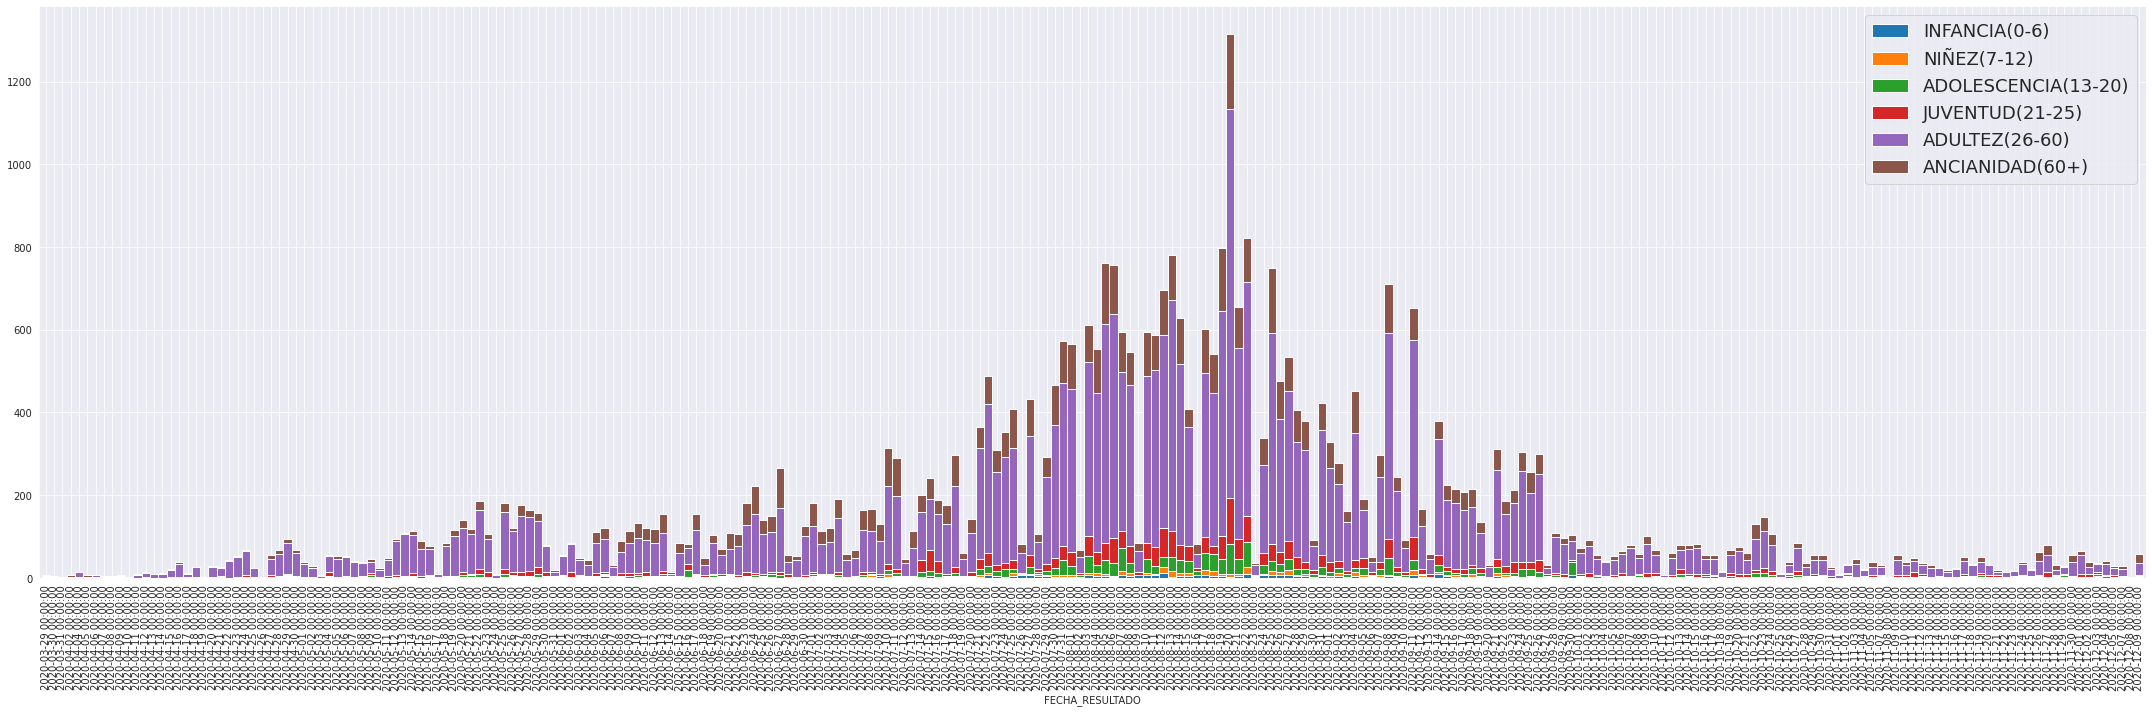

In [55]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

df_etapas.plot(kind='bar', stacked=True, width=1, ax=ax1)
ax1.legend(fontsize=18)
fig.tight_layout()
plt.savefig('image_18.png')
plt.savefig('MINSA_EdadFranjas.pdf')
plt.show()

In [56]:
df_plot = df_etapas.copy()
df_plot['SUM'] = df_plot.sum(axis=1)

df_plot['INFANCIA(0-6)'] = df_plot['INFANCIA(0-6)'] / df_plot['SUM']
df_plot['NIÑEZ(7-12)'] = df_plot['NIÑEZ(7-12)'] / df_plot['SUM']
df_plot['ADOLESCENCIA(13-20)'] = df_plot['ADOLESCENCIA(13-20)'] / df_plot['SUM']
#df_plot['ADULTEZ_INTERMEDIA'] = df_plot['ADULTEZ_INTERMEDIA'] / df_plot['SUM']
#df_plot['ADULTEZ_JOVEN'] = df_plot['ADULTEZ_JOVEN'] / df_plot['SUM']
#df_plot['ADULTEZ_TARDIA'] = df_plot['ADULTEZ_TARDIA'] / df_plot['SUM']
df_plot['JUVENTUD(21-25)'] = df_plot['JUVENTUD(21-25)'] / df_plot['SUM']
df_plot['ADULTEZ(26-60)'] = df_plot['ADULTEZ(26-60)'] / df_plot['SUM']
df_plot['ANCIANIDAD(60+)'] = df_plot['ANCIANIDAD(60+)'] / df_plot['SUM']
del df_plot['SUM']
df_plot

ETAPA            INFANCIA(0-6)  NIÑEZ(7-12)  ...  ADULTEZ(26-60)  ANCIANIDAD(60+)
FECHA_RESULTADO                              ...                                 
2020-03-29            0.000000     0.166667  ...        0.333333         0.333333
2020-03-30            0.000000     0.000000  ...        0.400000         0.600000
2020-03-31            0.000000     0.000000  ...        1.000000         0.000000
2020-04-02            0.000000     0.000000  ...        0.166667         0.666667
2020-04-04            0.000000     0.071429  ...        0.714286         0.071429
...                        ...          ...  ...             ...              ...
2020-12-04            0.000000     0.000000  ...        0.700000         0.150000
2020-12-05            0.000000     0.071429  ...        0.642857         0.142857
2020-12-07            0.000000     0.035714  ...        0.607143         0.214286
2020-12-08            0.000000     0.000000  ...        1.000000         0.000000
2020-12-09            0.017241     0.034483  ...        0.500000         0.379310

[252 rows x 6 columns]

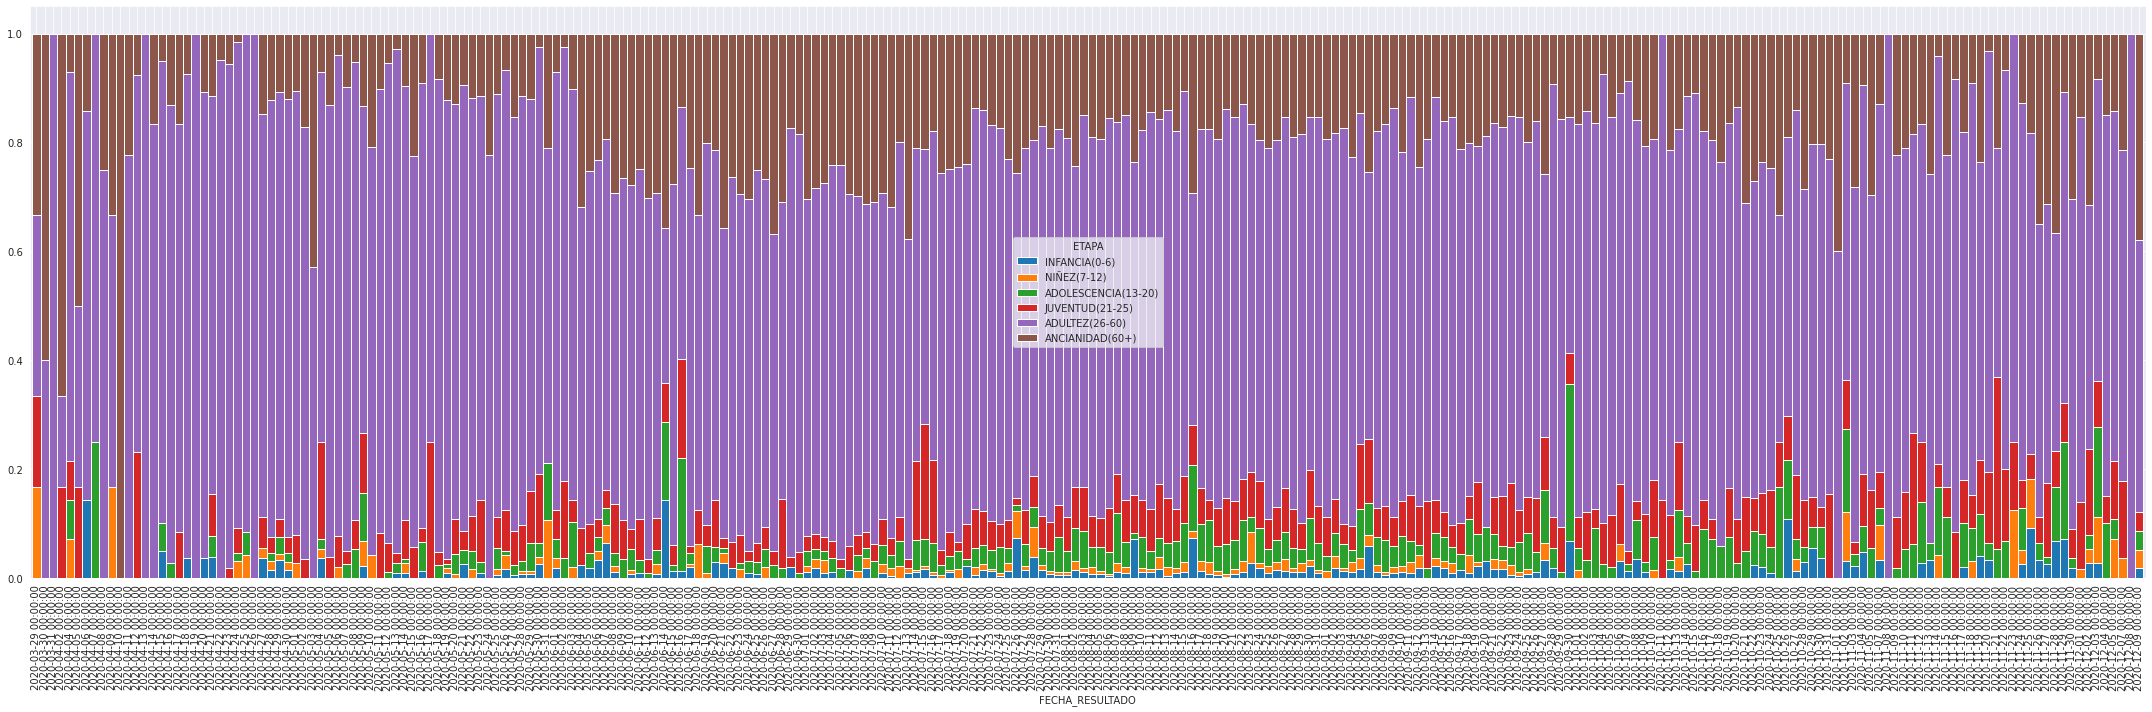

In [57]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

df_plot.plot(kind='bar', stacked=True, width=1, ax=ax1)
fig.tight_layout()
plt.savefig('image_19.png')
plt.show()

In [58]:
df_edad = df_arequipa_pro.EDAD
#df_edad.replace([0], np.nan, inplace=True)
display(df_edad.value_counts().sort_index().shape)
df_edad.describe()

(105,)

count    40379.000000
mean        44.353946
std         17.261095
min          0.000000
25%         32.000000
50%         43.000000
75%         56.000000
max        106.000000
Name: EDAD, dtype: float64

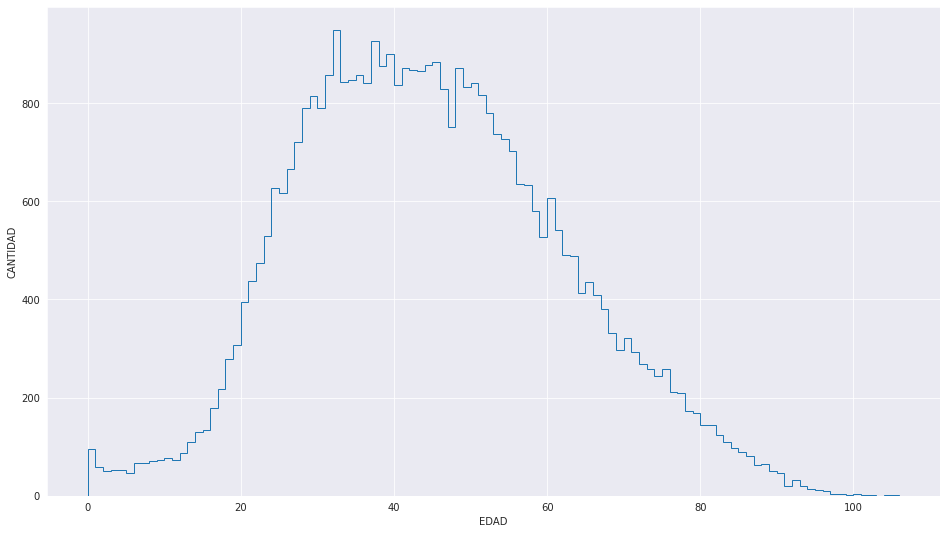

In [59]:
plt.figure(figsize=(16,9))
plt.hist(df_edad.dropna(), bins=106, histtype='step')
plt.xlabel('EDAD')
plt.ylabel('CANTIDAD')
plt.show()

In [60]:
is_masculine = df_arequipa_pro.SEXO == 'MASCULINO'
is_PCR = df_arequipa_pro.METODODX == 'PCR'
edad_sex_masculine = df_edad[is_masculine]
edad_sex_femenine = df_edad[~is_masculine]
print('Promedio de Edad Hombres: ', edad_sex_masculine.mean())
print('Promedio de Edad Mujeres: ',edad_sex_femenine.mean())

edad_sex_masculine_pcr = df_edad[is_masculine & is_PCR]
edad_sex_femenine_pcr = df_edad[~is_masculine & is_PCR]
print('Promedio de Edad Hombres - PCR: ',edad_sex_masculine_pcr.mean())
print('Promedio de Edad Mujeres - PCR: ',edad_sex_femenine_pcr.mean())

Promedio de Edad Hombres:  44.760752045160984
Promedio de Edad Mujeres:  43.91733415485726
Promedio de Edad Hombres - PCR:  47.93663216359505
Promedio de Edad Mujeres - PCR:  49.50086956521739


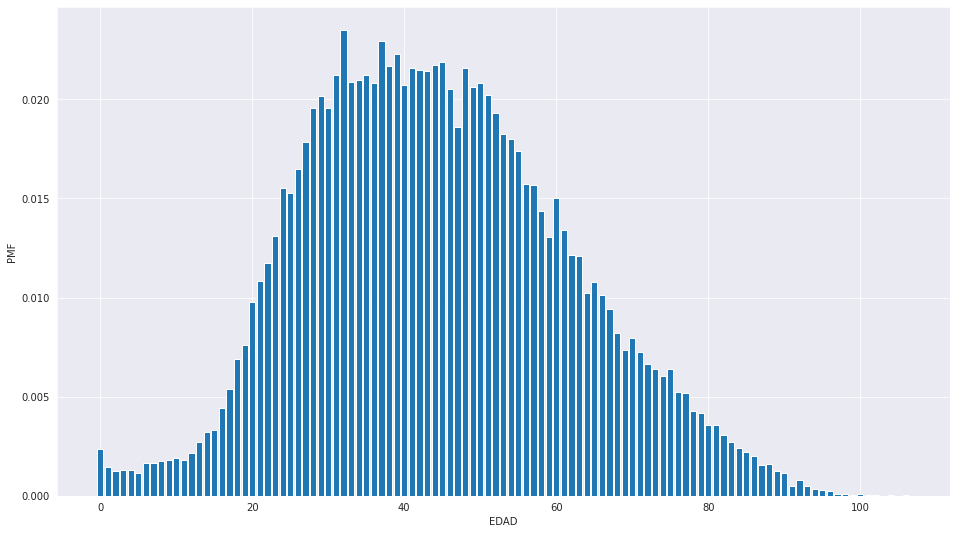

In [61]:
pmf_age_result = Pmf.from_seq(df_edad)
# Plot the PMF
plt.figure(figsize=(16,9))
pmf_age_result.bar()

# Label the axes
plt.xlabel('EDAD')
plt.ylabel('PMF')
plt.show()

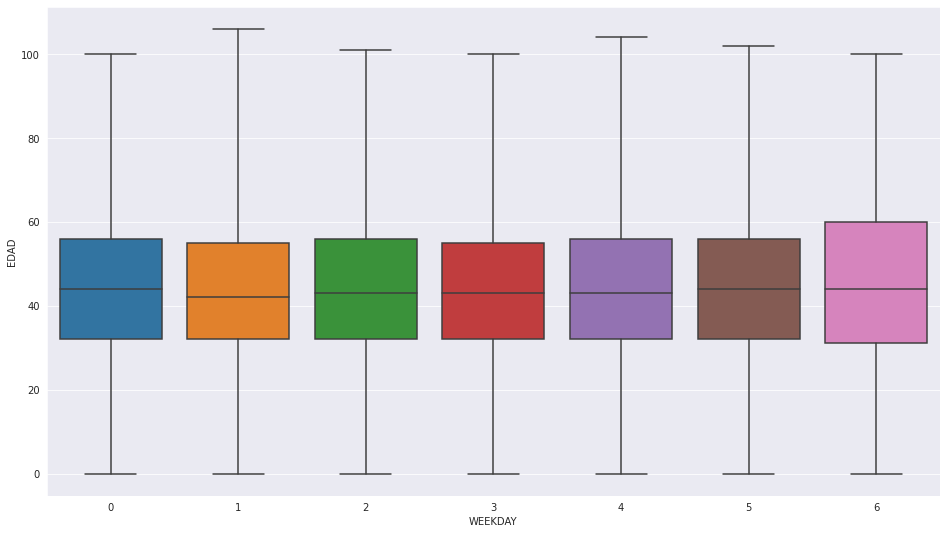

In [62]:
plt.figure(figsize=(16,9))
sns.boxplot(data = df_arequipa_pro, x='WEEKDAY', y='EDAD', whis=10)
#plt.yscale('log')
plt.show()

# SINADEF

In [92]:
datos_sinadef_raw.sort_values('FECHA').tail()

Nº TIPO SEGURO  ... DEBIDO A (CAUSA F) CAUSA F (CIE-X)
528333  528334         SIS  ...       SIN REGISTRO    SIN REGISTRO
528332  528333     ESSALUD  ...       SIN REGISTRO    SIN REGISTRO
528331  528332     ESSALUD  ...       SIN REGISTRO    SIN REGISTRO
528327  528328         SIS  ...       SIN REGISTRO    SIN REGISTRO
528177  528178     ESSALUD  ...       SIN REGISTRO    SIN REGISTRO

[5 rows x 31 columns]

In [93]:
datos_sinadef_raw['SEMANA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.week
#datos_sinadef_raw['DIAANUAL'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.dayofyear
datos_sinadef_raw['MESDIA'] = pd.to_datetime(datos_sinadef_raw['FECHA']).dt.strftime('%m-%d')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [94]:
datos_sinadef_raw.query('SEMANA == 49').query('AÑO == 2020').sort_values('FECHA')
#datos_sinadef_raw.sort_values('FECHA')

Nº  TIPO SEGURO       SEXO  ... CAUSA F (CIE-X) SEMANA MESDIA
519846  519847          SIS  MASCULINO  ...    SIN REGISTRO     49  11-30
523243  523244      ESSALUD  MASCULINO  ...    SIN REGISTRO     49  11-30
523242  523243          SIS   FEMENINO  ...    SIN REGISTRO     49  11-30
523240  523241      ESSALUD  MASCULINO  ...    SIN REGISTRO     49  11-30
523239  523240          SIS  MASCULINO  ...    SIN REGISTRO     49  11-30
...        ...          ...        ...  ...             ...    ...    ...
527317  527318        OTROS   FEMENINO  ...    SIN REGISTRO     49  12-06
527318  527319     PRIVADOS   FEMENINO  ...    SIN REGISTRO     49  12-06
527319  527320          SIS  MASCULINO  ...    SIN REGISTRO     49  12-06
527881  527882      ESSALUD  MASCULINO  ...    SIN REGISTRO     49  12-06
526798  526799  SANIDAD PNP  MASCULINO  ...    SIN REGISTRO     49  12-06

[2659 rows x 33 columns]

In [95]:
datos_sinadef_semana = datos_sinadef_raw.groupby(['SEMANA', 'AÑO'])['Nº'].count()
datos_sinadef_semana = datos_sinadef_semana.to_frame().reset_index()
datos_sinadef_semana = datos_sinadef_semana[datos_sinadef_semana['SEMANA'] <= semana_sinadef ]
datos_sinadef_semana.tail()

SEMANA   AÑO    Nº
191      48  2020  2633
192      49  2017  1868
193      49  2018  2147
194      49  2019  2251
195      49  2020  2659

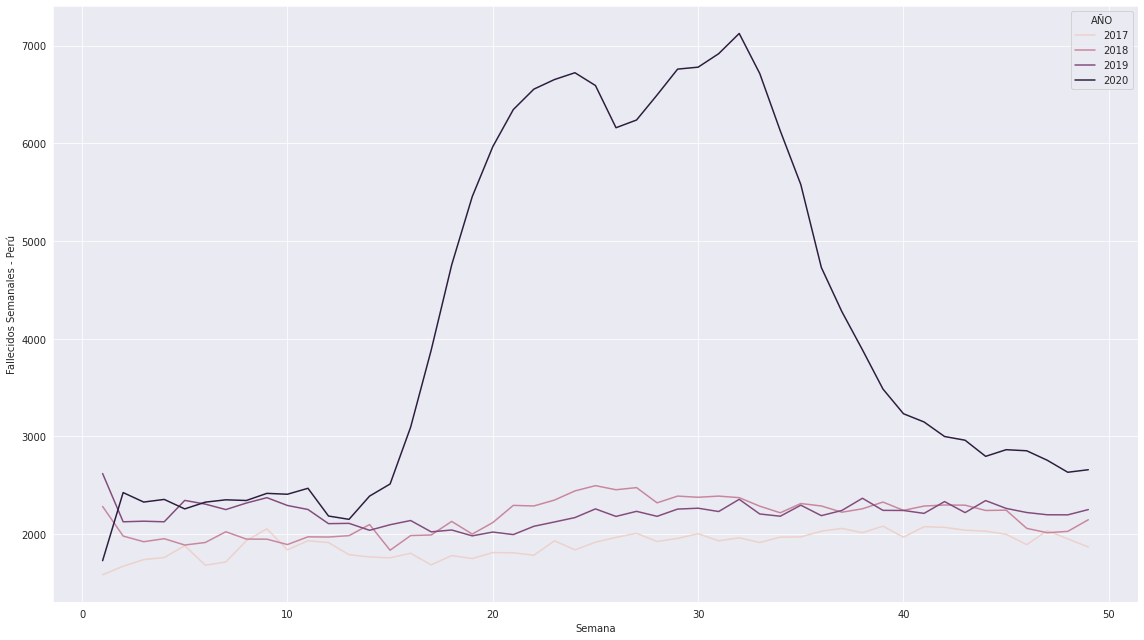

In [96]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_semana, x = 'SEMANA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Perú')
fig.tight_layout()
plt.savefig('image_20.png')
plt.show()

In [97]:
#datos_sinadef_dia = datos_sinadef_raw.groupby(['DIAANUAL', 'AÑO'])['Nº'].count()
datos_sinadef_dia = datos_sinadef_raw.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_dia = datos_sinadef_dia.to_frame().reset_index()
#datos_sinadef_dia = datos_sinadef_dia[datos_sinadef_dia['DIAANUAL'] <= 222]
datos_sinadef_dia = datos_sinadef_dia[datos_sinadef_dia['MESDIA'] <= dia_sinadef]
datos_sinadef_dia = datos_sinadef_dia[datos_sinadef_dia['MESDIA'] != '02-29']
datos_sinadef_dia

MESDIA   AÑO   Nº
0     01-01  2017  270
1     01-01  2018  321
2     01-01  2019  344
3     01-01  2020  378
4     01-02  2017  238
...     ...   ...  ...
1368  12-08  2020  359
1369  12-09  2017  264
1370  12-09  2018  303
1371  12-09  2019  306
1372  12-09  2020  371

[1372 rows x 3 columns]

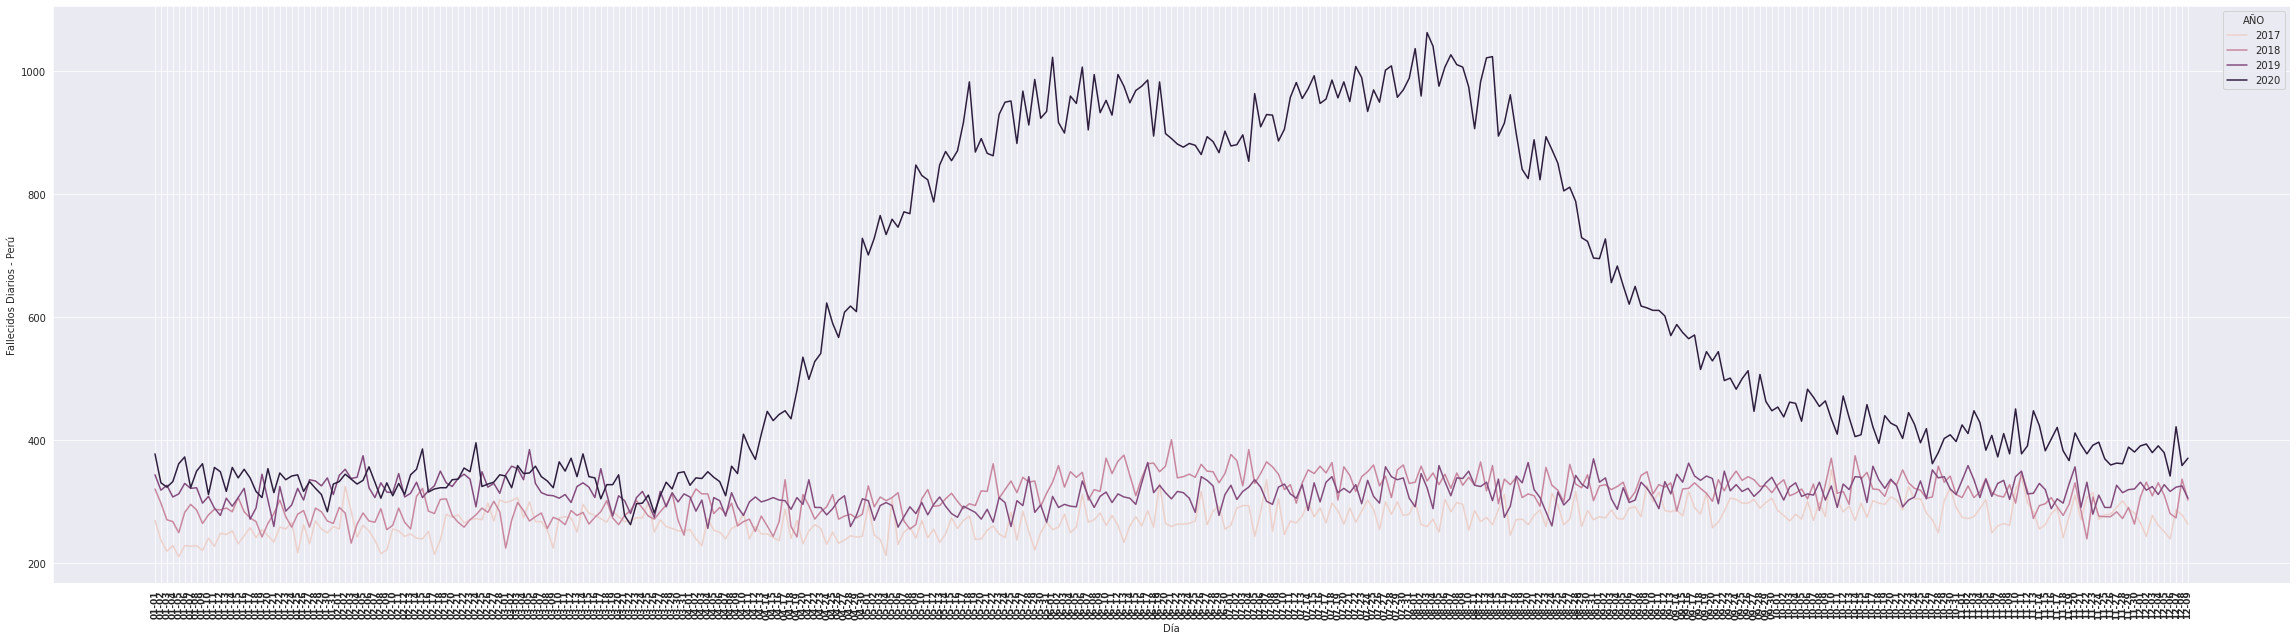

In [98]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(32, 9))

sns.lineplot(data=datos_sinadef_dia, x = 'MESDIA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Día')
plt.ylabel('Fallecidos Diarios - Perú')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
fig.tight_layout()
#plt.savefig('image_20.png')
plt.show()

In [99]:
datos_sinadef_raw.tail()

Nº TIPO SEGURO       SEXO  ... CAUSA F (CIE-X) SEMANA MESDIA
528988  528989     ESSALUD   FEMENINO  ...    SIN REGISTRO     49  12-01
528989  528990         SIS  MASCULINO  ...    SIN REGISTRO     49  12-03
528990  528991         SIS  MASCULINO  ...    SIN REGISTRO     49  12-03
528991  528992         SIS  MASCULINO  ...    SIN REGISTRO     50  12-09
528992  528993         SIS   FEMENINO  ...    SIN REGISTRO     49  12-02

[5 rows x 33 columns]

In [108]:
#datos_sinadef_departamentos = datos_sinadef_raw[(datos_sinadef_raw['FECHA'] <= '2020-08-14') & (datos_sinadef_raw['FECHA'] >= '2017-01-01')]
#datos_sinadef_departamentos = datos_sinadef_departamentos[datos_sinadef_departamentos['FECHA'] <= '2020-08-13']
datos_sinadef_departamentos = datos_sinadef_raw[datos_sinadef_raw['SEMANA'] <= semana_sinadef]
#datos_sinadef_departamentos = datos_sinadef_departamentos[datos_sinadef_departamentos['MESDIA'] <= '08-13']
#datos_sinadef_departamentos = datos_sinadef_departamentos[datos_sinadef_departamentos['MESDIA'] != '02-29' ]
datos_sinadef_departamentos = datos_sinadef_departamentos.groupby(['DEPARTAMENTO DOMICILIO', 'AÑO', 'SEMANA'])['Nº'].count()
#datos_sinadef_departamentos = datos_sinadef_departamentos.groupby(['DEPARTAMENTO DOMICILIO', 'SEMANA'])['Nº', 'Nº', 'Nº'].count()
datos_sinadef_departamentos = datos_sinadef_departamentos.to_frame()
datos_sinadef_departamentos.columns = ['real']
#datos_sinadef_departamentos['-1'] = datos_sinadef_dia['-1'] - 1
#datos_sinadef_departamentos['+1'] = datos_sinadef_dia['+1'] + 1
datos_sinadef_departamentos

real
DEPARTAMENTO DOMICILIO AÑO  SEMANA      
AMAZONAS               2017 1         11
                            2         13
                            3         16
                            4          9
                            5         17
...                                  ...
UCAYALI                2020 45        51
                            46        47
                            47        37
                            48        34
                            49        44

[5281 rows x 1 columns]

In [109]:
def plot_sinadef_departamentos(result, ax, state_name):
    ax.set_title(f"{state_name}")

    #index = pd.to_datetime(result['real'].index.get_level_values('SEMANA'))
    index = result['real'].index.get_level_values('SEMANA')
    
    sns.lineplot(data=result, x = index , y = 'real', hue=result['real'].index.get_level_values('AÑO'), ax=ax)
    #sns.lineplot(data=result, x = index , y = 'real', ax=ax)

def plot_rt_states():
    N_COLS = 2
    N_ROWS = int(np.ceil(len(datos_sinadef_raw['DEPARTAMENTO DOMICILIO'].unique()) / N_COLS))

    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(24, N_ROWS*3), dpi=90)
    
    # loop for several states
    for i, (state_name, result) in enumerate(datos_sinadef_departamentos.groupby('DEPARTAMENTO DOMICILIO')):
        plot_sinadef_departamentos(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')
    plt.savefig('image_24.png')
    plt.savefig('SINADEF_COVID_Regiones_01.pdf')

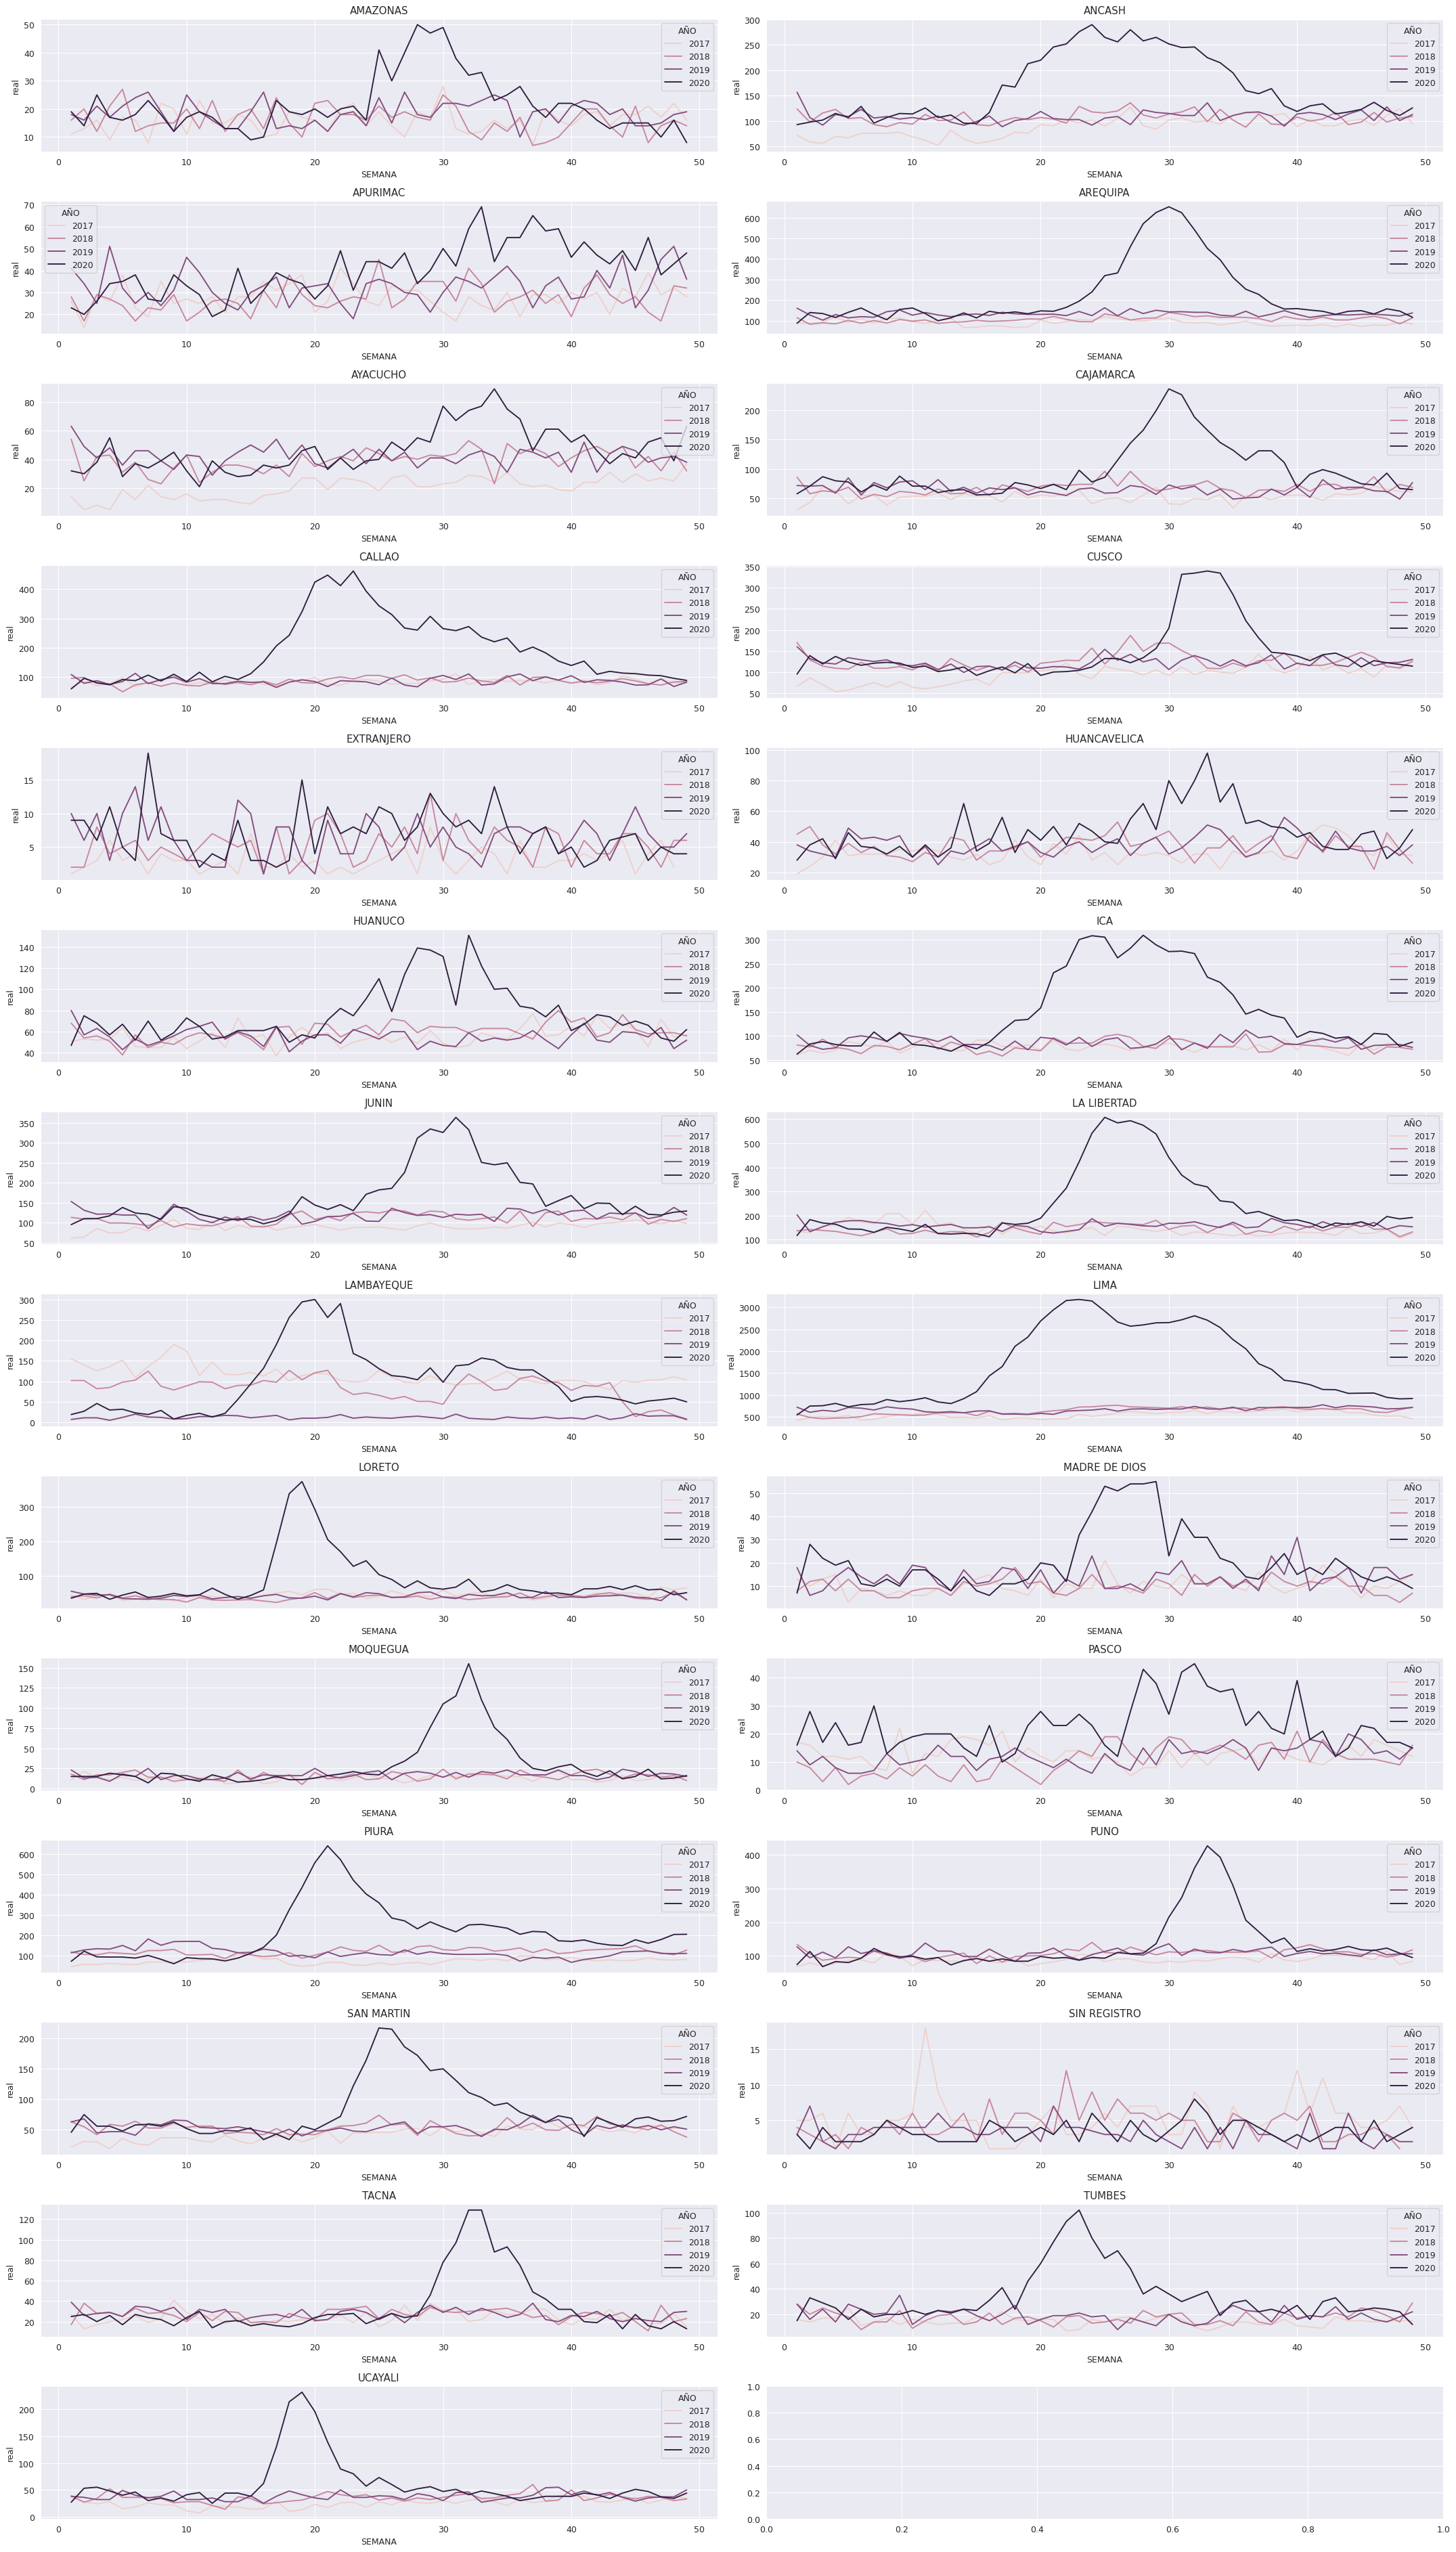

In [110]:
plot_rt_states()

In [111]:
datos_sinadef_no_violenta = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]
datos_sinadef_arequipa = datos_sinadef_no_violenta[datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA']
datos_sinadef_arequipa['DIASEMANA'] = pd.to_datetime(datos_sinadef_arequipa['FECHA']).dt.weekday
#datos_sinadef_arequipa['DIAANUAL'] = pd.to_datetime(datos_sinadef_arequipa['FECHA']).dt.dayofyear
datos_sinadef_arequipa = datos_sinadef_arequipa.reset_index(drop=True)
datos_sinadef_arequipa.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Nº TIPO SEGURO       SEXO  ... SEMANA MESDIA DIASEMANA
26334  528892     ESSALUD   FEMENINO  ...     49  12-04         4
26335  528918         SIS   FEMENINO  ...     49  12-04         4
26336  528919    PRIVADOS  MASCULINO  ...     49  12-04         4
26337  528937     ESSALUD  MASCULINO  ...     49  12-03         3
26338  528946     ESSALUD   FEMENINO  ...     49  12-03         3

[5 rows x 34 columns]

In [112]:
datos_sinadef_arequipa_semana = datos_sinadef_arequipa.groupby(['SEMANA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana.to_frame().reset_index()
datos_sinadef_arequipa_semana = datos_sinadef_arequipa_semana[datos_sinadef_arequipa_semana['SEMANA'] <= semana_sinadef ]
datos_sinadef_arequipa_semana.tail()

SEMANA   AÑO   Nº
191      48  2020  136
192      49  2017   73
193      49  2018  106
194      49  2019  127
195      49  2020  111

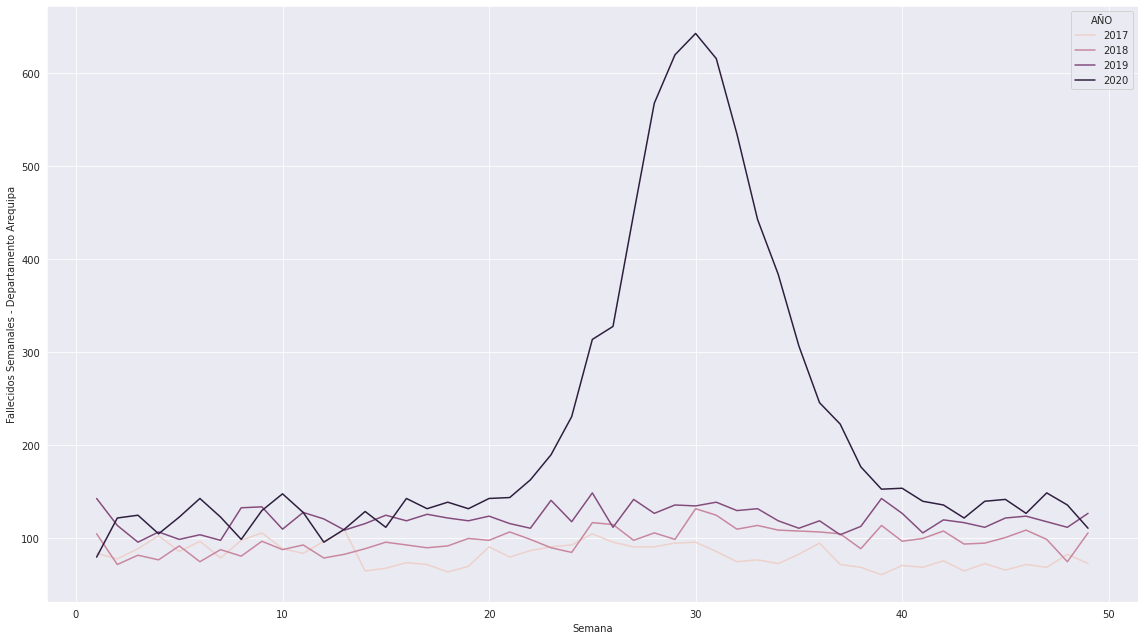

In [113]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana, x = 'SEMANA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')
fig.tight_layout()
plt.savefig('image_21.png')
plt.show()

In [114]:
#datos_sinadef_arequipa_2020 = datos_sinadef_arequipa[datos_sinadef_arequipa['FECHA'] >= '2020-03-29']
datos_sinadef_arequipa_2020 = datos_sinadef_arequipa[datos_sinadef_arequipa['FECHA'] >= '2020-05-25']
#datos_sinadef_arequipa_2020 = datos_sinadef_arequipa[datos_sinadef_arequipa['EDAD'] != 'SIN REGISTRO']

from datetime import datetime
datetime_str = '2020-03-29 00:00:00'
datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

datos_sinadef_arequipa_2020['DIA'] = (pd.to_datetime(datos_sinadef_arequipa_2020['FECHA']) - datetime_object).dt.days

datos_sinadef_arequipa_2020['DIA'] = datos_sinadef_arequipa_2020['DIA'].astype('int')
datos_sinadef_arequipa_2020.sort_values('FECHA')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Nº TIPO SEGURO       SEXO EDAD  ... SEMANA MESDIA DIASEMANA  DIA
2110    40999    IGNORADO  MASCULINO   52  ...     22  05-25         0   57
2267    46857         SIS   FEMENINO   86  ...     22  05-25         0   57
2269    46864         SIS   FEMENINO   32  ...     22  05-25         0   57
2270    46891         SIS  MASCULINO   68  ...     22  05-25         0   57
2271    46917     ESSALUD  MASCULINO   78  ...     22  05-25         0   57
...       ...         ...        ...  ...  ...    ...    ...       ...  ...
26299  528144     ESSALUD  MASCULINO   65  ...     50  12-10         3  256
26298  528130     ESSALUD  MASCULINO  102  ...     50  12-10         3  256
26297  528058         SIS   FEMENINO   42  ...     50  12-10         3  256
26310  528388     ESSALUD   FEMENINO   55  ...     50  12-10         3  256
26302  528262     ESSALUD   FEMENINO   97  ...     50  12-10         3  256

[8013 rows x 35 columns]

135.85149132659427 47.25397604389383


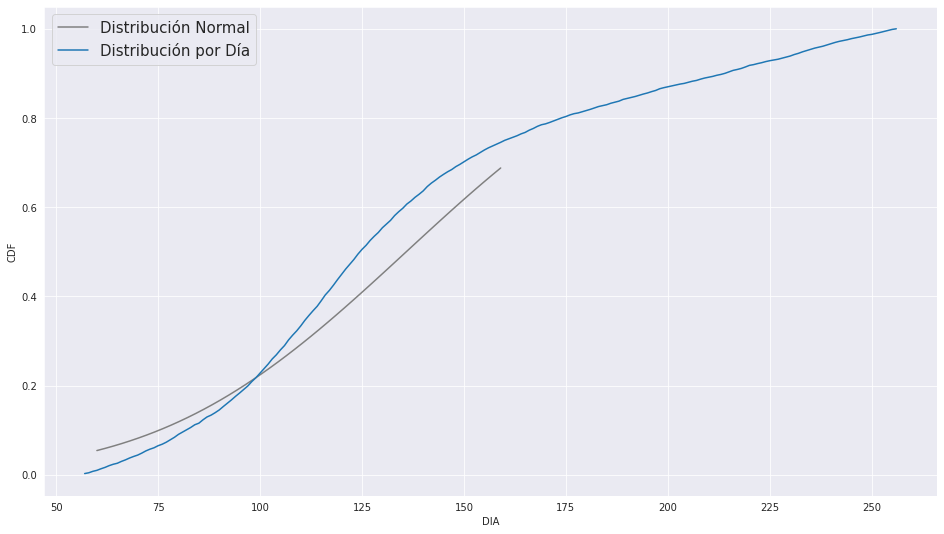

In [115]:
mean = datos_sinadef_arequipa_2020['DIA'].mean()
std = datos_sinadef_arequipa_2020['DIA'].std()

print(mean, std)

# Make a norm object
from scipy.stats import norm
dist = norm(mean, std)

# Evaluate the model CDF
#xs = np.linspace(0, 143)
xs = np.linspace(60, 159)
ys = dist.cdf(xs)

plt.figure(figsize=(16,9))

# Plot the model CDF
plt.plot(xs, ys, color='gray', label='Distribución Normal')

# Create and plot the Cdf of log_income
Cdf.from_seq(datos_sinadef_arequipa_2020['DIA']).plot(label='Distribución por Día')

# Label the axes
plt.xlabel('DIA')
plt.ylabel('CDF')
plt.legend(fontsize=15)
fig.tight_layout()
plt.show()

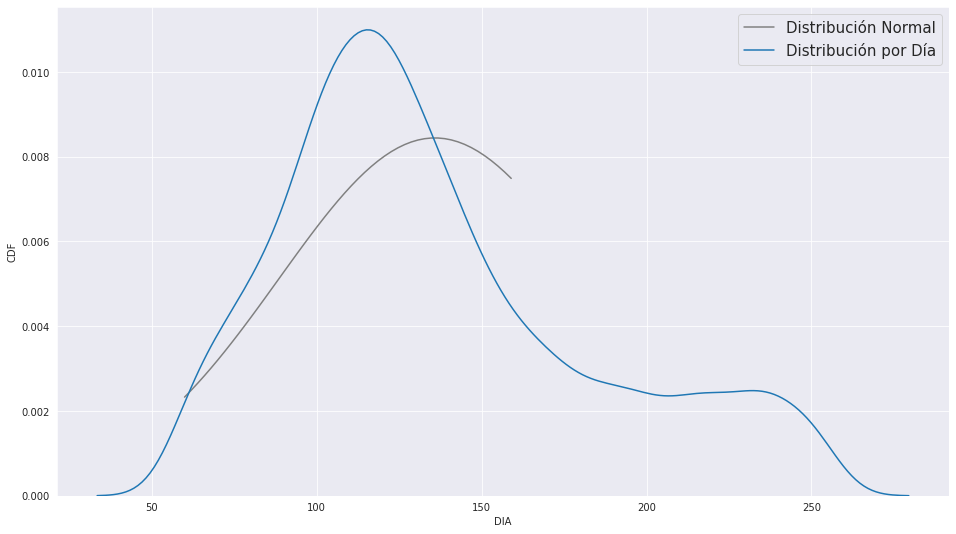

In [116]:
# Evaluate the normal PDF
#xs = np.linspace(0, 143)
xs = np.linspace(60, 159)
ys = dist.pdf(xs)

plt.figure(figsize=(16,9))

# Plot the model PDF
plt.plot(xs, ys, color='gray', label='Distribución Normal')

# Plot the data KDE
sns.kdeplot(datos_sinadef_arequipa_2020['DIA'], label='Distribución por Día')
    
# Label the axes
plt.xlabel('DIA')
plt.ylabel('CDF')
plt.legend(fontsize=15)
fig.tight_layout()
plt.show()

In [117]:
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa.groupby(['DIAANUAL', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia = datos_sinadef_arequipa.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia.to_frame().reset_index()
#datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['DIAANUAL'] <= 222 ]
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['MESDIA'] <= dia_sinadef ]
datos_sinadef_arequipa_dia = datos_sinadef_arequipa_dia[datos_sinadef_arequipa_dia['MESDIA'] != '02-29' ]
datos_sinadef_arequipa_dia

MESDIA   AÑO  Nº
0     01-01  2017  16
1     01-01  2018   8
2     01-01  2019  19
3     01-01  2020  15
4     01-02  2017  12
...     ...   ...  ..
1368  12-08  2020  19
1369  12-09  2017   8
1370  12-09  2018  15
1371  12-09  2019  11
1372  12-09  2020  17

[1372 rows x 3 columns]

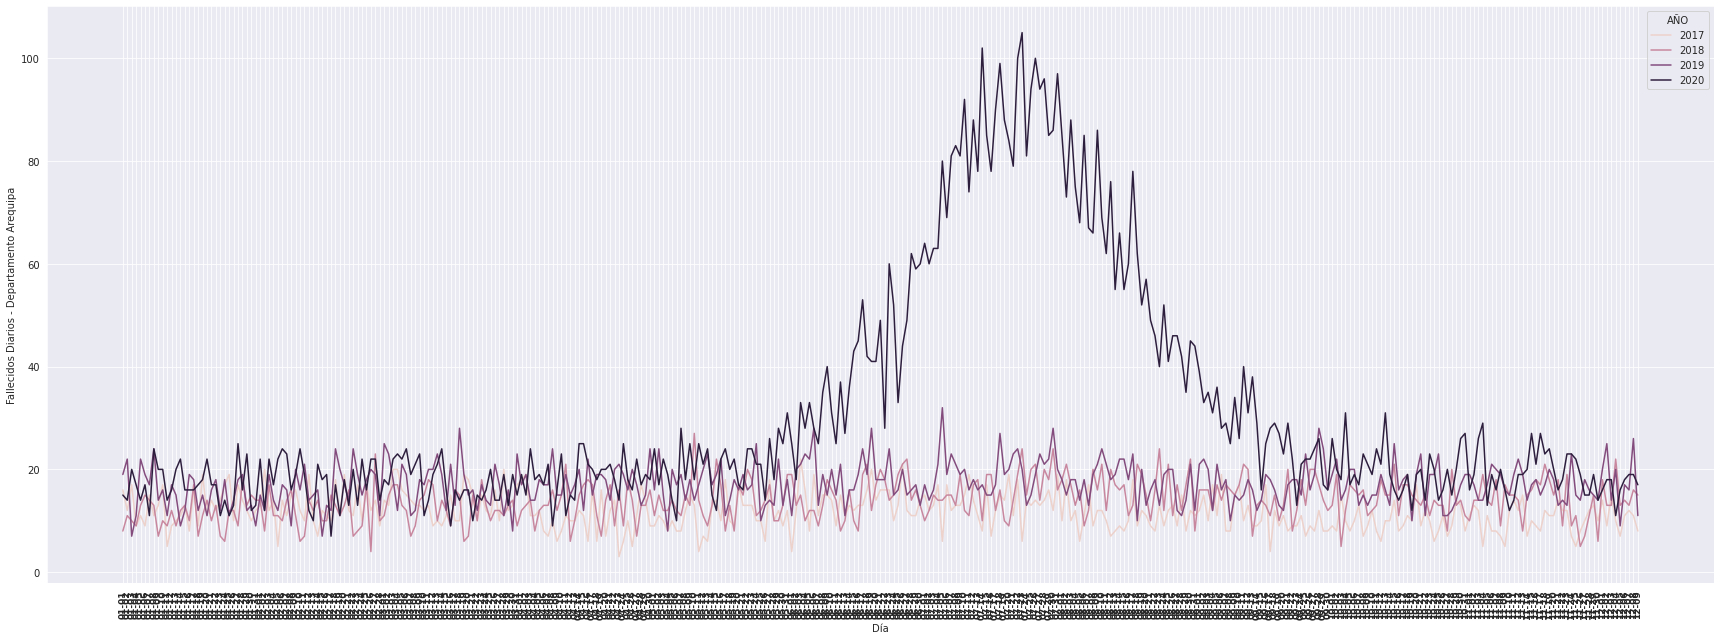

In [118]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))

sns.lineplot(data=datos_sinadef_arequipa_dia, x = 'MESDIA', y = 'Nº', hue='AÑO', ax=ax1)

plt.xlabel('Día')
plt.ylabel('Fallecidos Diarios - Departamento Arequipa')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
fig.tight_layout()
plt.savefig('image_25.png')
plt.show()

In [119]:
datos_arequipa_semana = datos_arequipa.groupby(['week', 'year'])['fallecidos_diarios'].sum()
datos_arequipa_semana = datos_arequipa_semana.to_frame().reset_index()
datos_arequipa_semana = datos_arequipa_semana[datos_arequipa_semana['week'] <= semana_sinadef ]

datos_arequipa_semana

week  year  fallecidos_diarios
0     18  2020                   4
1     19  2020                  10
2     20  2020                   7
3     21  2020                  10
4     22  2020                  20
5     23  2020                  18
6     24  2020                  48
7     25  2020                  83
8     26  2020                  79
9     27  2020                 113
10    28  2020                  83
11    29  2020                 212
12    30  2020                 151
13    31  2020                 137
14    32  2020                 194
15    33  2020                 163
16    34  2020                  86
17    35  2020                 263
18    36  2020                  82
19    37  2020                 171
20    38  2020                  65
21    39  2020                  38
22    40  2020                  32
23    41  2020                  70
24    42  2020                  21
25    43  2020                  49
26    44  2020                  10
27    45  2020                  10
28    46  2020                  22
29    47  2020                  18
30    48  2020                  11
31    49  2020                  10

In [120]:
datos_sinadef_arequipa_covid = datos_sinadef_arequipa[datos_sinadef_arequipa['CAUSA A (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA B (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA C (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA D (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA E (CIE-X)'].str.contains("U07") | 
                                                        datos_sinadef_arequipa['CAUSA F (CIE-X)'].str.contains("U07") |
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA A)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA B)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA C)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA D)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA E)'].str.contains("CORONAVIRUS") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("COVID") | 
                                                        datos_sinadef_arequipa['DEBIDO A (CAUSA F)'].str.contains("CORONAVIRUS")
                                                       ]

#display(df_sinadef_raw_arequipa_covid)

datos_sinadef_arequipa_covid['week'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.week
datos_sinadef_arequipa_covid['year'] = pd.to_datetime(datos_sinadef_arequipa_covid['FECHA']).dt.year
datos_sinadef_arequipa_covid = datos_sinadef_arequipa_covid.reset_index(drop=True)

datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_covid.groupby(['week', 'year'])['Nº'].count()
datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid.to_frame().reset_index()
datos_sinadef_arequipa_semana_covid = datos_sinadef_arequipa_semana_covid[(datos_sinadef_arequipa_semana_covid['week'] >= 18) & (datos_sinadef_arequipa_semana_covid['week'] <= semana_sinadef)]

datos_sinadef_arequipa_semana_covid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


week  year   Nº
4     18  2020   10
5     19  2020   18
6     20  2020   14
7     21  2020   26
8     22  2020   54
9     23  2020   56
10    24  2020   89
11    25  2020  145
12    26  2020  165
13    27  2020  229
14    28  2020  280
15    29  2020  326
16    30  2020  346
17    31  2020  343
18    32  2020  302
19    33  2020  255
20    34  2020  213
21    35  2020  170
22    36  2020  115
23    37  2020  103
24    38  2020   70
25    39  2020   50
26    40  2020   36
27    41  2020   41
28    42  2020   27
29    43  2020   18
30    44  2020   18
31    45  2020   24
32    46  2020   22
33    47  2020   17
34    48  2020   23
35    49  2020   17

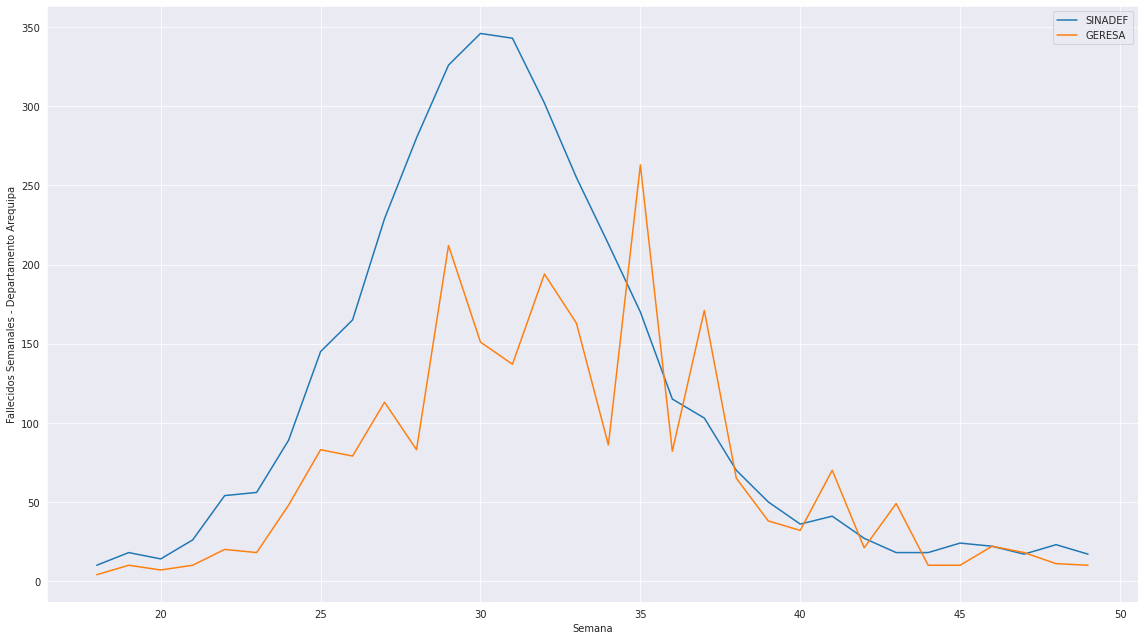

In [121]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.lineplot(data=datos_sinadef_arequipa_semana_covid, x = 'week', y = 'Nº', label='SINADEF', ax=ax1)
sns.lineplot(data=datos_arequipa_semana, x = 'week', y = 'fallecidos_diarios', label='GERESA', ax=ax1)

plt.xlabel('Semana')
plt.ylabel('Fallecidos Semanales - Departamento Arequipa')
fig.tight_layout()
plt.savefig('image_22.png')
plt.savefig('Fallecidos_COVID_SINADEF-GERESA.pdf')
plt.show()

In [122]:
datos_arequipa_dia = datos_arequipa.groupby(['mesdia', 'year'])['fallecidos_diarios'].sum()
datos_arequipa_dia = datos_arequipa_dia.to_frame().reset_index()
datos_arequipa_dia = datos_arequipa_dia[datos_arequipa_dia['mesdia'] <= dia_sinadef ]
datos_arequipa_dia = datos_arequipa_dia[(datos_arequipa_dia['mesdia'] != '05-09')]
datos_arequipa_dia = datos_arequipa_dia[(datos_arequipa_dia['mesdia'] != '05-17')]
datos_arequipa_dia = datos_arequipa_dia.reset_index(drop=True)

datos_arequipa_dia.tail()

mesdia  year  fallecidos_diarios
216  12-05  2020                   0
217  12-06  2020                   1
218  12-07  2020                   0
219  12-08  2020                   3
220  12-09  2020                   1

In [123]:
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_covid.groupby(['MESDIA', 'AÑO'])['Nº'].count()
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid.to_frame().reset_index()
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid[(datos_sinadef_arequipa_dia_covid['MESDIA'] >= '05-01') & (datos_sinadef_arequipa_dia_covid['MESDIA'] <= dia_sinadef)]
datos_sinadef_arequipa_dia_covid = datos_sinadef_arequipa_dia_covid.reset_index(drop=True)

datos_sinadef_arequipa_dia_covid.tail()

MESDIA   AÑO  Nº
212  12-05  2020   1
213  12-06  2020   4
214  12-07  2020   2
215  12-08  2020   2
216  12-09  2020   2

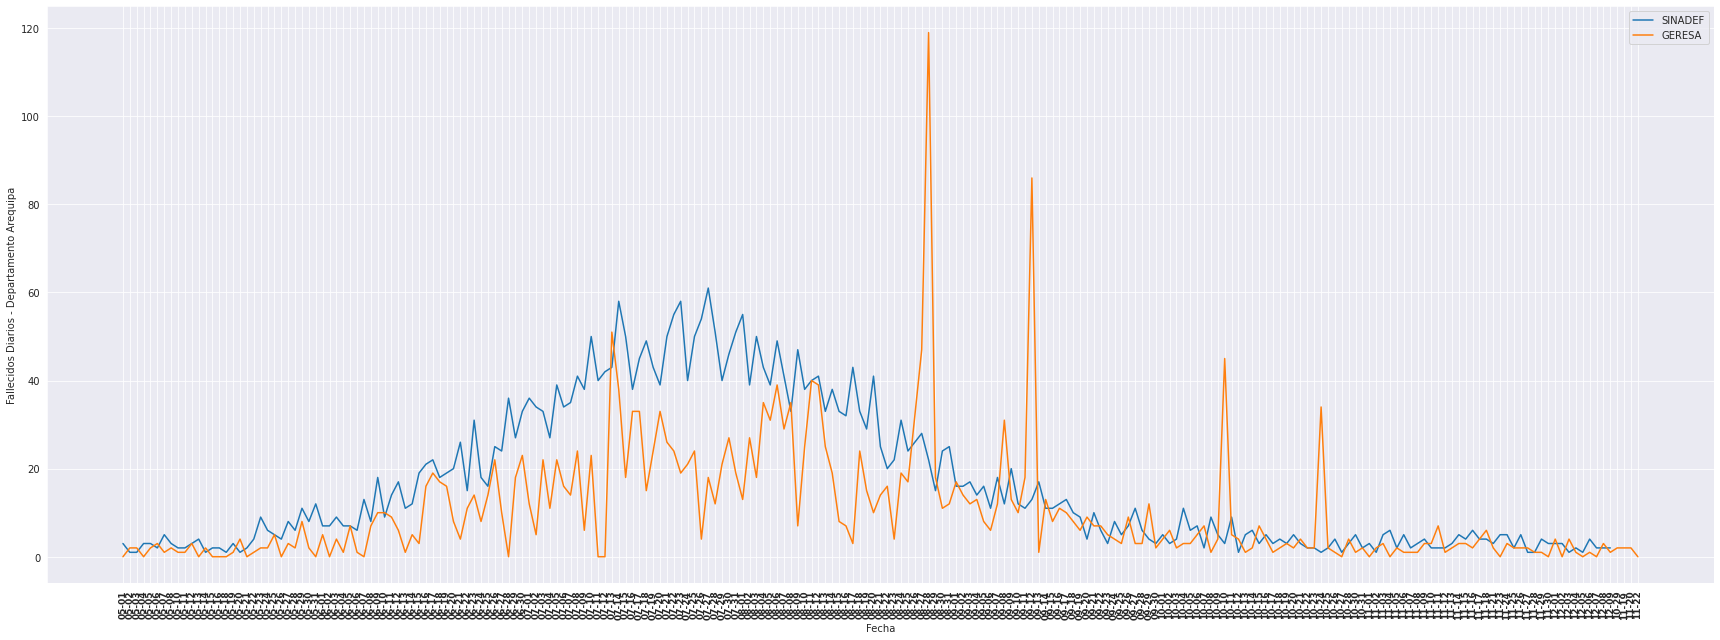

In [124]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
 
sns.lineplot(data=datos_sinadef_arequipa_dia_covid, x = 'MESDIA', y = 'Nº', label='SINADEF', ax=ax1)
sns.lineplot(data=datos_arequipa_dia, x = 'mesdia', y = 'fallecidos_diarios', label='GERESA', ax=ax1)
 
plt.xlabel('Fecha')
plt.ylabel('Fallecidos Diarios - Departamento Arequipa')
plt.xticks(rotation=90, fontsize=9, fontweight='bold')
fig.tight_layout()
#plt.savefig('image_22.png')
plt.savefig('Fallecidos_COVID_SINADEF-GERESA_diario.pdf')
plt.show()

## Clustering

Reference: https://www.kaggle.com/maksimeren/covid-19-literature-clustering

### Initialize

In [125]:
# Download the spacy bio parser
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
    !pip install stop-words

#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step
import string

from stop_words import get_stop_words

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [126]:
stop_words = get_stop_words('spanish')
punctuations = string.punctuation

# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

### Load Data

In [127]:
datos_sinadef_no_violenta = datos_sinadef_raw[(datos_sinadef_raw['MUERTE VIOLENTA'] == 'SIN REGISTRO')]

In [128]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_no_violenta[(datos_sinadef_no_violenta['FECHA'] >= '2020-01-01') & \
                                                                     (datos_sinadef_no_violenta['DEPARTAMENTO DOMICILIO'] == 'AREQUIPA')]

### Pre-processing

In [129]:
datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample.replace('SIN REGISTRO', ' ')

datos_sinadef_arequipa_clustering_sample = datos_sinadef_arequipa_clustering_sample[['DEBIDO A (CAUSA A)',
                                                                                     'CAUSA A (CIE-X)',
                                                                                     'DEBIDO A (CAUSA B)',
                                                                                     'CAUSA B (CIE-X)',
                                                                                     'DEBIDO A (CAUSA C)',
                                                                                     'CAUSA C (CIE-X)',
                                                                                     'DEBIDO A (CAUSA D)',
                                                                                     'CAUSA D (CIE-X)',
                                                                                     'DEBIDO A (CAUSA E)',
                                                                                     'CAUSA E (CIE-X)',
                                                                                     'DEBIDO A (CAUSA F)',
                                                                                     'CAUSA F (CIE-X)']]

datos_sinadef_arequipa_clustering_sample['all_features'] =  datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA A)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA A (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA B)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA B (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA C)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA C (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA D)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA D (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA E)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA E (CIE-X)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['DEBIDO A (CAUSA F)'] + ' ' + \
                                                            datos_sinadef_arequipa_clustering_sample['CAUSA F (CIE-X)']

datos_sinadef_arequipa_clustering_sample

DEBIDO A (CAUSA A)  ...                                       all_features
52                          TRAUMATISMO ENCEFALO CRANEANO  ...  TRAUMATISMO ENCEFALO CRANEANO S069 AHOGAMIENTO...
62                                  NEOPLASIA DE PANCREAS  ...        NEOPLASIA DE PANCREAS                      
171     IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...  ...  IMPRECISABLE POR AVANZADO ESTADO DE DESCOMPOSI...
218                                        CHOQUE SEPTICO  ...  CHOQUE SEPTICO R572 BRONCONEUMONIA J180 ENFERM...
224                            INSUFICIENCIA RESPIRATORIA  ...  INSUFICIENCIA RESPIRATORIA   ENFERMEDAD DE MEM...
...                                                   ...  ...                                                ...
528891                                FALLA MULTIORGANICA  ...  FALLA MULTIORGANICA   PROGRESION DE ENFERMEDAD...
528917                                FALLA MULTIORGANICA  ...   FALLA MULTIORGANICA   SENECTUD                  
528918                         INSUFICIENCIA RESPIRATORIA  ...  INSUFICIENCIA RESPIRATORIA J960 COVID 19 U072 ...
528936                  INSUFICIENCIA RESPIRATORIA SEVERA  ...  INSUFICIENCIA RESPIRATORIA SEVERA J960 FALLA M...
528945                             EDEMA CEREBRAL MALIGNO  ...  EDEMA CEREBRAL MALIGNO G936 MENINGIOMA VENTRIC...

[10619 rows x 13 columns]

### Clean

In [130]:
datos_sinadef_arequipa_clustering_sample["processed_text"] = datos_sinadef_arequipa_clustering_sample['all_features'].progress_apply(spacy_tokenizer)

100%|██████████| 10619/10619 [00:47<00:00, 223.87it/s]


### Vectorize

In [131]:
text = datos_sinadef_arequipa_clustering_sample['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(10619, 4096)

### PCA

In [132]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10619, 1411)

### Elbow Method

In [133]:
# run kmeans with many different k
"""
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow_departamento_arequipa_2020.png')
plt.show()
"""

"\ndistortions = []\nK = range(2, 50)\nfor k in K:\n    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)\n    k_means.fit(X_reduced)\n    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])\n    print('Found distortion for {} clusters'.format(k))\n\nX_line = [K[0], K[-1]]\nY_line = [distortions[0], distortions[-1]]\n\n# Plot the elbow\nplt.plot(K, distortions, 'b-')\nplt.plot(X_line, Y_line, 'r')\nplt.xlabel('k')\nplt.ylabel('Distortion')\nplt.title('The Elbow Method showing the optimal k')\nplt.savefig('elbow_departamento_arequipa_2020.png')\nplt.show()\n"

### K-means over K calculated

In [134]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
datos_sinadef_arequipa_clustering_sample['y'] = y_pred

### TSNE Method

In [135]:
tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10619 samples in 9.915s...
[t-SNE] Computed neighbors for 10619 samples in 1056.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10619
[t-SNE] Computed conditional probabilities for sample 2000 / 10619
[t-SNE] Computed conditional probabilities for sample 3000 / 10619
[t-SNE] Computed conditional probabilities for sample 4000 / 10619
[t-SNE] Computed conditional probabilities for sample 5000 / 10619
[t-SNE] Computed conditional probabilities for sample 6000 / 10619
[t-SNE] Computed conditional probabilities for sample 7000 / 10619
[t-SNE] Computed conditional probabilities for sample 8000 / 10619
[t-SNE] Computed conditional probabilities for sample 9000 / 10619
[t-SNE] Computed conditional probabilities for sample 10000 / 10619
[t-SNE] Computed conditional probabilities for sample 10619 / 10619
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.470718
[t-SNE]

### Plot Clusters

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


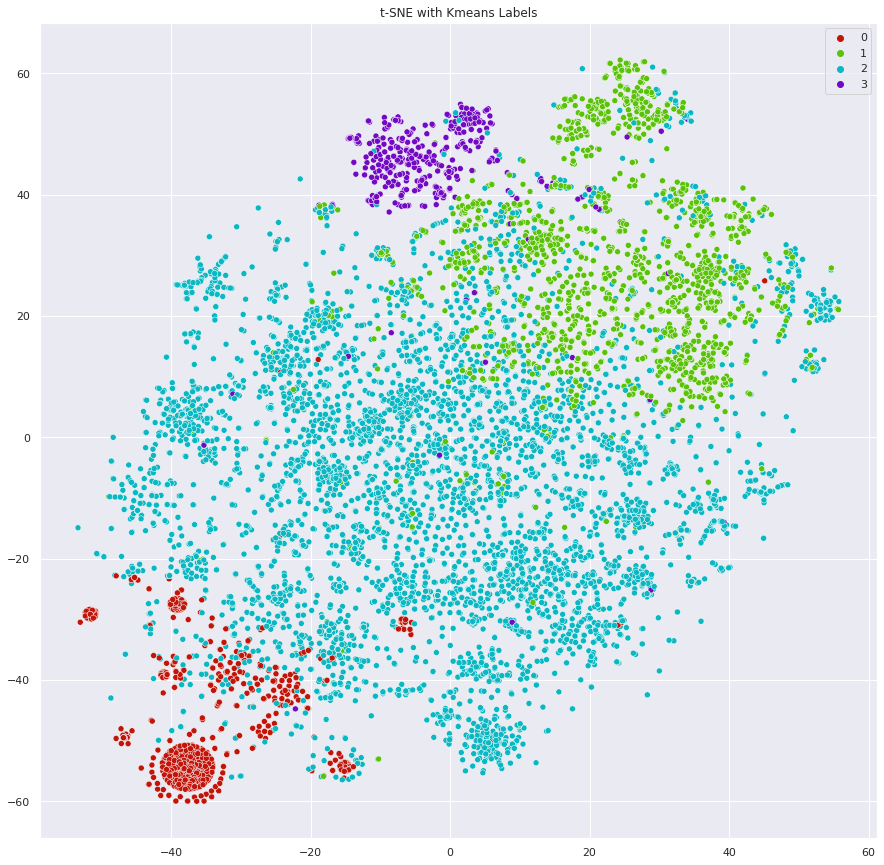

In [136]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("image_23.png")
plt.show()

### Topic Modeling

In [137]:
vectorizers = []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words=stop_words, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['a', 'al', 'algo', 'algunas', 'algunos', 'ante',
                            'antes', 'como', 'con', 'contra', 'cual', 'cuando',
                            'de', 'del', 'desde', 'donde', 'durante', 'e', 'el',
                            'ella', 'ellas', 'ellos', 'en', 'entre', 'era',
                            'erais', 'eran', 'eras', 'eres', 'es', ...],
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [138]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(datos_sinadef_arequipa_clustering_sample.loc[datos_sinadef_arequipa_clustering_sample['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
        
len(vectorized_data)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 'estuvi', 'hab', 'habr', 'hubi', 'ramos', 'semos', 'ser', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 'estuvi', 'hab', 'habr', 'hubi', 'ramos', 'semos', 'ser', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'est', 

4

In [139]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 10

lda_models = []
for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [140]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

len(clusters_lda_data[0])

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3


1086

In [141]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

display(all_keywords[0][:10])
len(all_keywords)

['falla',
 'multiorganica',
 'senilidad',
 'diabetes',
 'insuficiencia',
 'mellitus',
 'respiratoria',
 'cardiopatia',
 'arterial',
 'hipertension']

4

In [142]:
f=open('topicos.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

### Verifying Topics

In [143]:
ver_topico = 1
df = datos_sinadef_arequipa_clustering_sample[datos_sinadef_arequipa_clustering_sample['y'] == ver_topico]
display(df)

df.to_csv('df.csv')

df['processed_text'].to_csv('palabras_cluster_' + str(ver_topico) + '.txt', header=False, index=False)

from collections import Counter
results = Counter()
df['processed_text'].str.lower().str.split().apply(results.update)
print(results)

DEBIDO A (CAUSA A)  ...  y
413           INSUFICIENCIA RESPIRATORIA  ...  1
3202    INSUFICIENCIA RESPIRATORIA AGUDA  ...  1
6287    INSUFICIENCIA RESPIRATORIA AGUDA  ...  1
7815    INSUFICIENCIA RESPIRATORIA AGUDA  ...  1
8325          INSUFICIENCIA RESPIRATORIA  ...  1
...                                  ...  ... ..
528050   COVID-19 VIRUS NO IDENTIFICADO   ...  1
528057  INSUFICIENCIA RESPIRATORIA AGUDA  ...  1
528387                           COVID19  ...  1
528721        INSUFICIENCIA RESPIRATORIA  ...  1
528918        INSUFICIENCIA RESPIRATORIA  ...  1

[2682 rows x 15 columns]

Counter({'respiratoria': 2583, 'insuficiencia': 2323, 'covid': 1993, 'neumonia': 1726, 'j960': 1593, '19': 1570, 'u071': 1461, 'aguda': 1384, 'u072': 872, 'virus': 678, 'identificado': 654, 'j80x': 512, 'viral': 419, 'severa': 396, 'j969': 367, 'infeccion': 323, 'j189': 317, 'dificultad': 311, 'sindrome': 298, 'j129': 296, 'covid-19': 282, 'arterial': 230, 'atipica': 227, 'i10x': 219, 'hipertension': 216, 'adulto': 199, 'coronavirus': 194, 'diabetes': 181, 'covid19': 181, 'mellitus': 178, 'especificada': 171, 'j128': 170, 'falla': 166, 'j22x': 161, 'obesidad': 143, 'caso': 142, 'sospechoso': 135, 'infección': 119, 'neumonía': 107, 'e669': 106, 'multiorganica': 106, 'renal': 104, 'shock': 97, 'confirmado': 95, 'enfermedad': 85, 'respiratorio': 78, 'r579': 70, 'síndrome': 68, 'b972': 65, 'a419': 61, 'sepsis': 57, 'e119': 56, 'j159': 55, 'pulmonar': 55, 'j180': 55, 'septico': 54, 'j168': 51, 'n179': 50, '2': 48, 'r651': 45, 'probable': 42, 'r572': 41, 'bilateral': 40, 'choque': 39, 'croni

![](https://drive.google.com/uc?export=view&id=1mT00AP58ek6SKbZpsW3bXZjlVO-5W56T)


In [144]:
from google.colab import files
for i in range(1,26):
    files.download('image_' + str(i) + '.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Varios

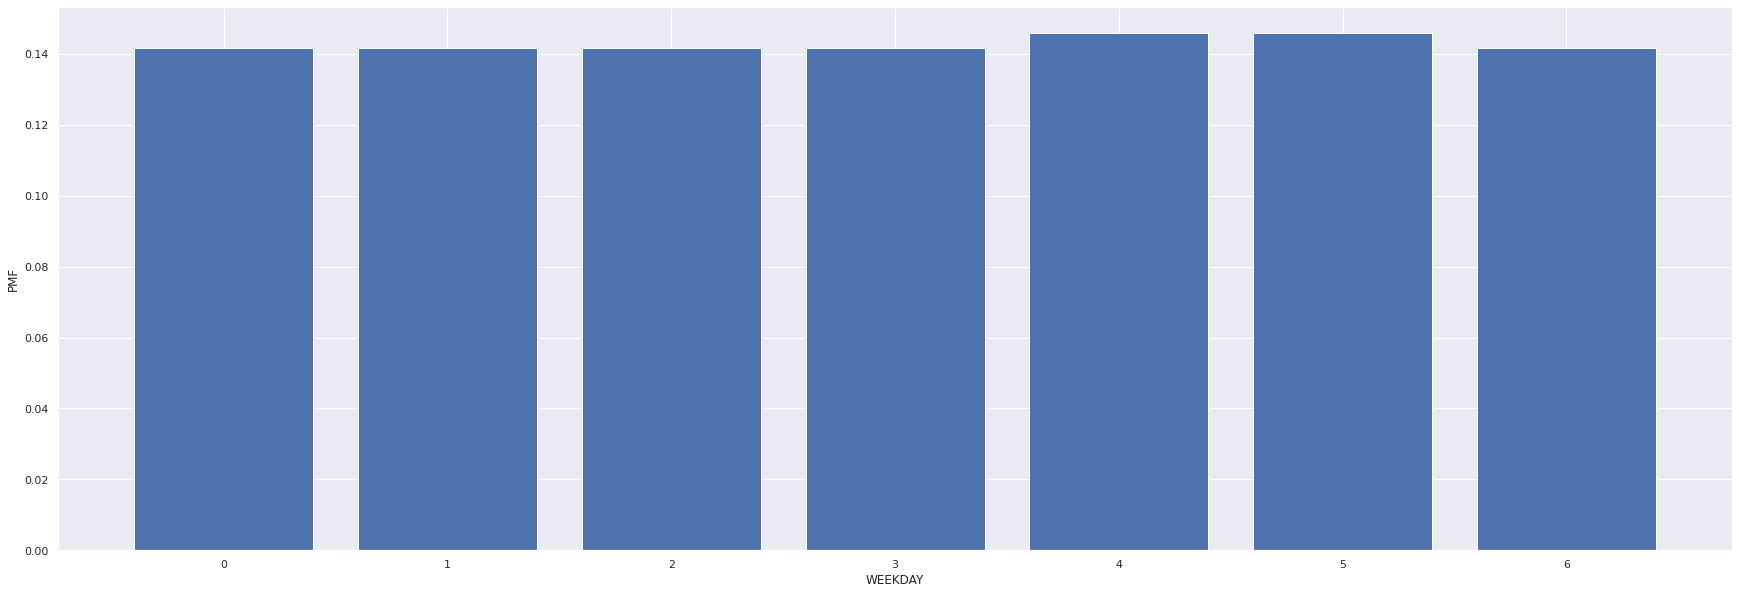

In [145]:
metododx = datos_arequipa['weekday']
plt.figure(figsize=(30,10))
Pmf.from_seq(metododx).bar()

plt.xlabel('WEEKDAY')
plt.ylabel('PMF')
plt.show()

In [146]:
datos_arequipa.tail()

0           total_muestras  casos_positivos  ...  mesdia  activos
date                                         ...                 
2020-12-08         1027730           145172  ...   12-08     3572
2020-12-09         1029030           145207  ...   12-09     3409
2020-12-10         1033562           145505  ...   12-10     3507
2020-12-11         1037631           145709  ...   12-11     3524
2020-12-12         1042534           145958  ...   12-12     3566

[5 rows x 29 columns]

In [147]:
datos_arequipa.describe()

0      total_muestras  casos_positivos  ...  positividad       activos
count    2.260000e+02       226.000000  ...   226.000000    226.000000
mean     5.170149e+05     75930.460177  ...    11.190265  10921.637168
std      3.467519e+05     56772.419406  ...     6.667606   9483.874443
min      1.420800e+04       655.000000  ...     0.000000    557.000000
25%      1.634255e+05     11122.000000  ...     6.000000   3429.750000
50%      5.427760e+05     86853.000000  ...     9.000000   6126.000000
75%      8.436378e+05    133465.750000  ...    15.750000  18859.750000
max      1.042534e+06    145958.000000  ...    31.000000  30029.000000

[8 rows x 28 columns]

In [148]:
datos_arequipa.corr()

0                                 total_muestras  ...   activos
0                                                 ...          
total_muestras                          1.000000  ...  0.094956
casos_positivos                         0.991587  ...  0.135617
casos_negativos                         0.999684  ...  0.087517
espera_resultado                        0.633858  ... -0.195753
defunciones                             0.991187  ...  0.177292
recuperados                             0.983844  ... -0.035070
hospitalizados_positivos                0.203634  ...  0.853307
hospitalizados_sospechosos             -0.260287  ...  0.668272
uci_positivos                           0.306145  ...  0.045335
uci_sospechosos                        -0.514421  ...  0.301497
trauma_shock                            0.593369  ...  0.168850
defunciones_minsa                       0.987867  ...  0.164532
defunciones_essalud                     0.981226  ...  0.212909
defunciones_clinicas                    0.971906  ...  0.055007
defunciones_domicilio                   0.954617  ... -0.041040
defunciones_sanidades                   0.819469  ... -0.199659
dia                                     0.992836  ...  0.058989
weekday                                -0.000344  ...  0.017158
week                                    0.992267  ...  0.058430
year                                         NaN  ...       NaN
muestras_diarias                        0.081455  ...  0.734220
confirmados_diarios                    -0.047035  ...  0.862059
fallecidos_diarios                     -0.115438  ...  0.540586
recuperados_diarios                     0.211594  ...  0.843308
hospitalizados_positivos_diarios       -0.059558  ... -0.020743
uci_positivos_diarios                  -0.017842  ... -0.022329
positividad                            -0.089478  ...  0.892263
activos                                 0.094956  ...  1.000000

[28 rows x 28 columns]

In [149]:
datos_arequipa['WEEKDAY'] = datos_arequipa.index.weekday

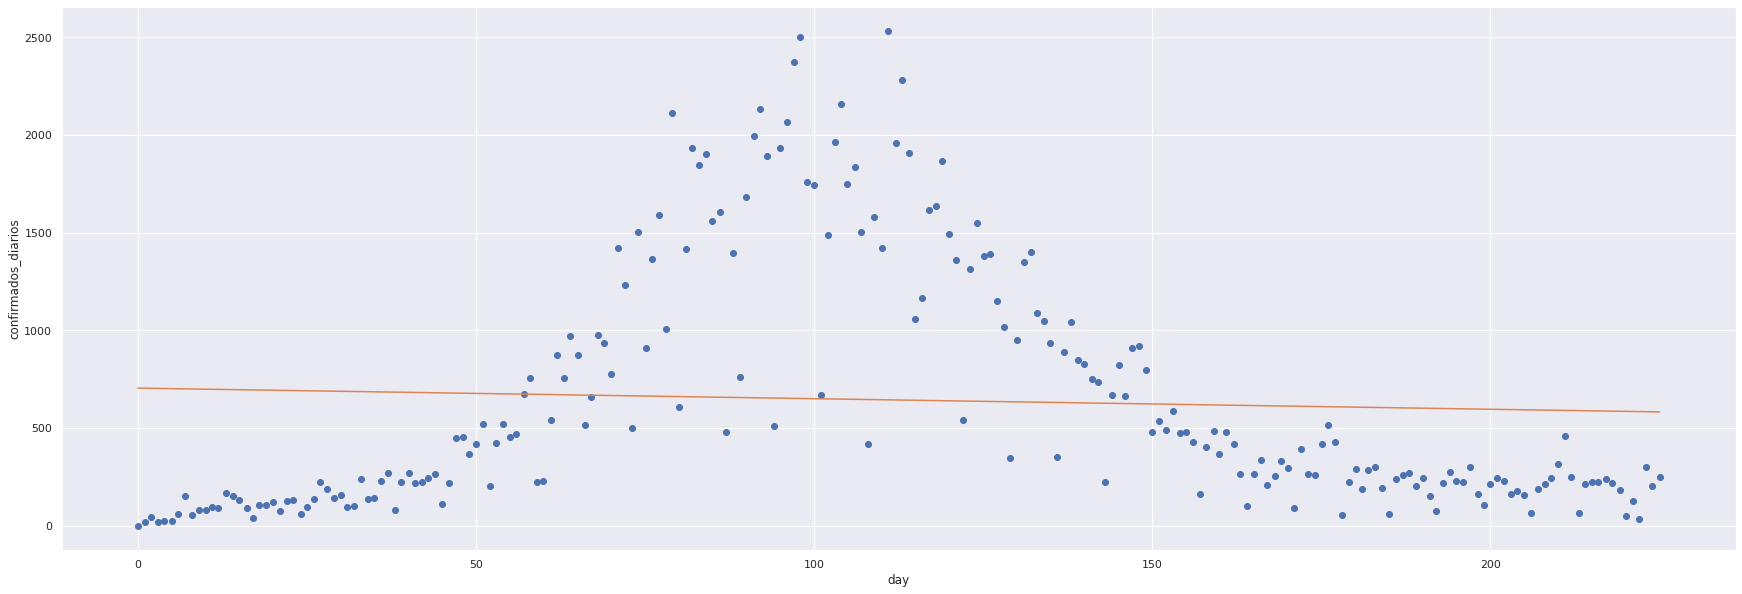

In [150]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['confirmados_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('confirmados_diarios')
plt.show()

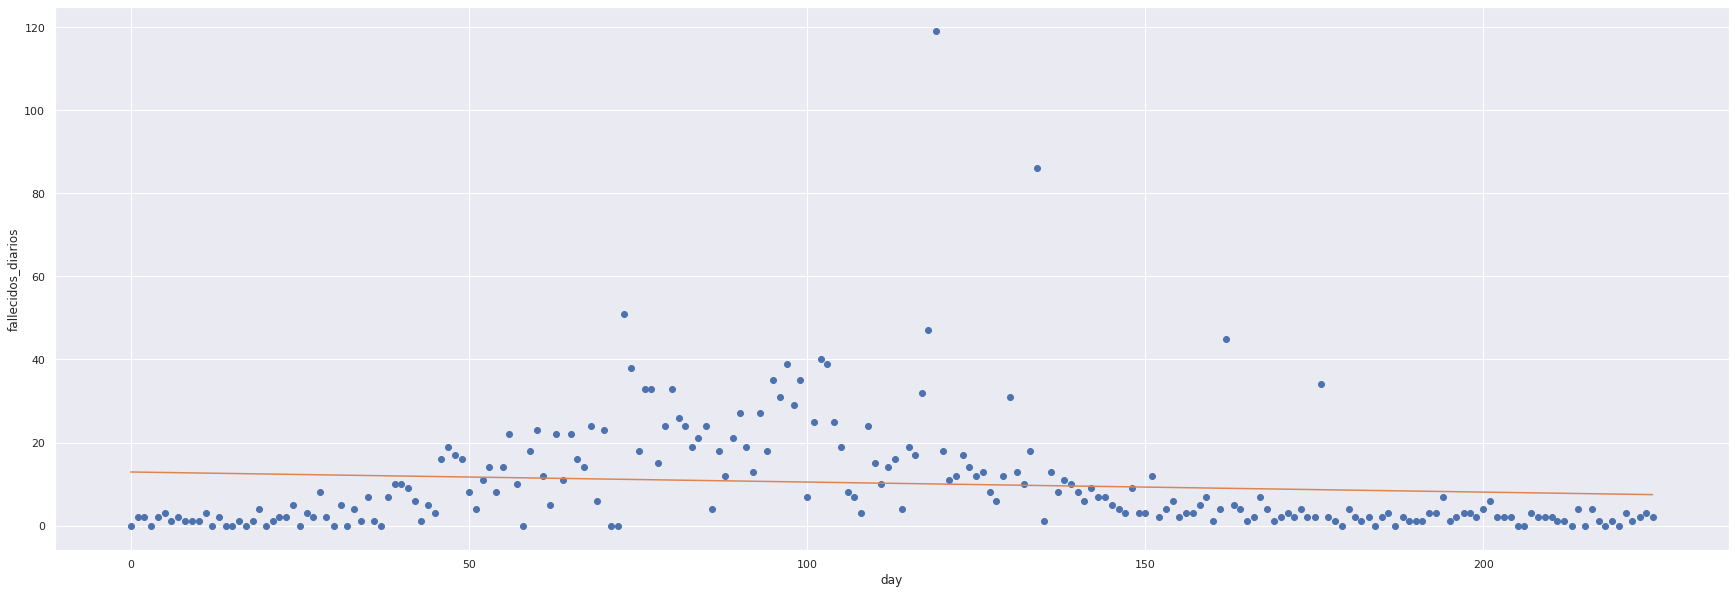

In [151]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('fallecidos_diarios')
plt.show()

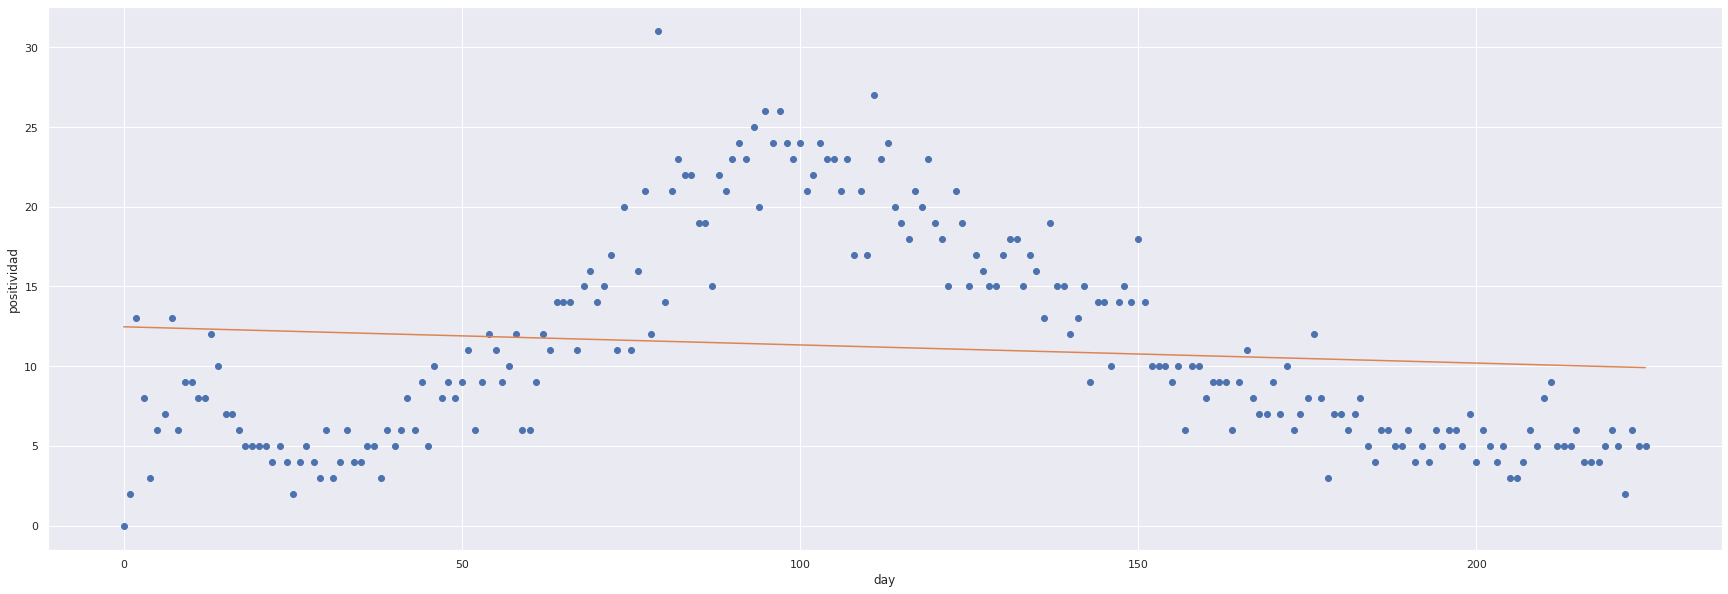

In [152]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['positividad']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('positividad')
plt.show()

In [153]:
import statsmodels.formula.api as smf

results = smf.ols('positividad ~ dia', data=datos_arequipa).fit()
results.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Intercept    12.470625
dia          -0.011381
dtype: float64

Cada dia la linea de regresion aumenta un 0.01

In [154]:
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2
datos_arequipa['dia3'] = datos_arequipa['dia'] ** 3

model = smf.ols('positividad ~ dia + dia2 + dia3', data=datos_arequipa)

results = model.fit()
results.params

Intercept   -0.386590
dia          0.382045
dia2        -0.002400
dia3         0.000003
dtype: float64

In [155]:
df = pd.DataFrame()
df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2
df['dia3'] = df['dia'] ** 3

pred12 = results.predict(df)

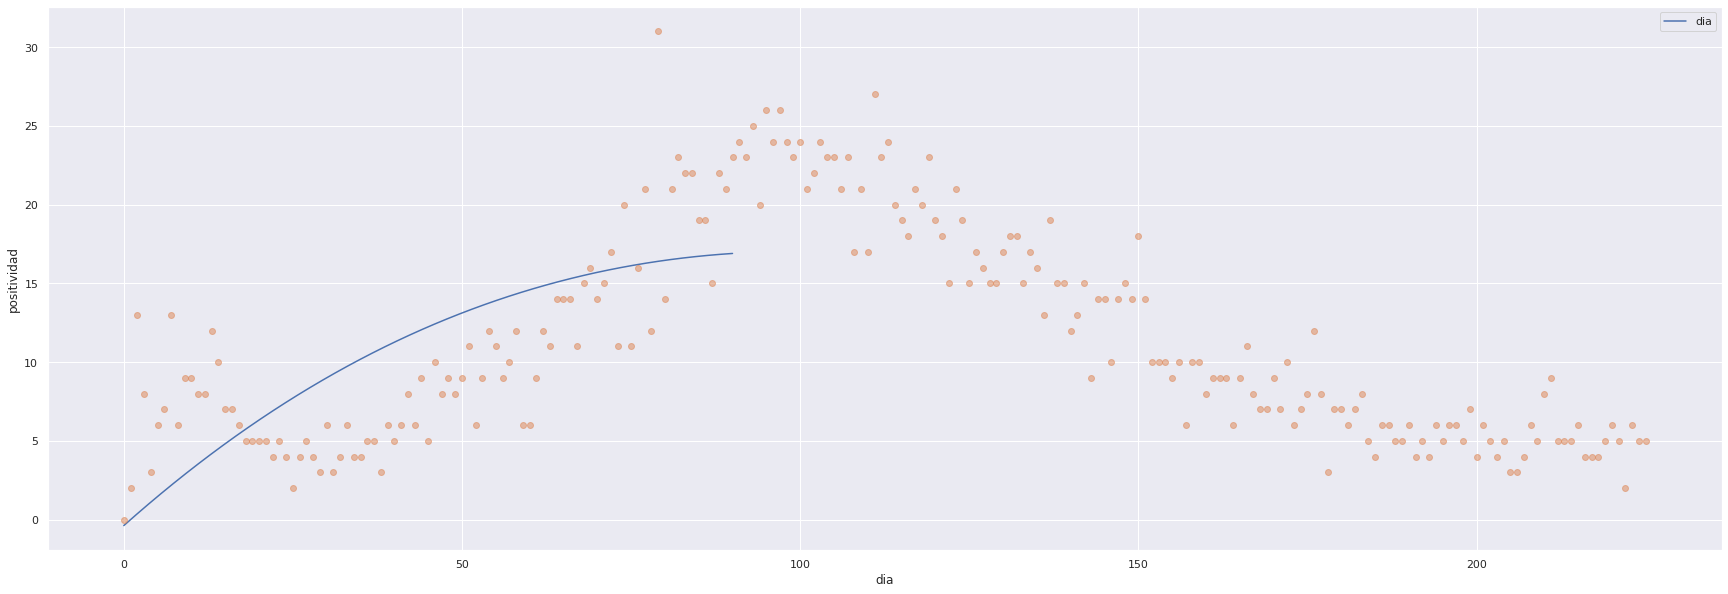

In [156]:
plt.figure(figsize=(30,10))
plt.plot(df['dia'], pred12, label='dia')
plt.plot(datos_arequipa['dia'], datos_arequipa['positividad'], 'o', alpha=0.5)

plt.xlabel('dia')
plt.ylabel('positividad')
plt.legend()
plt.show()

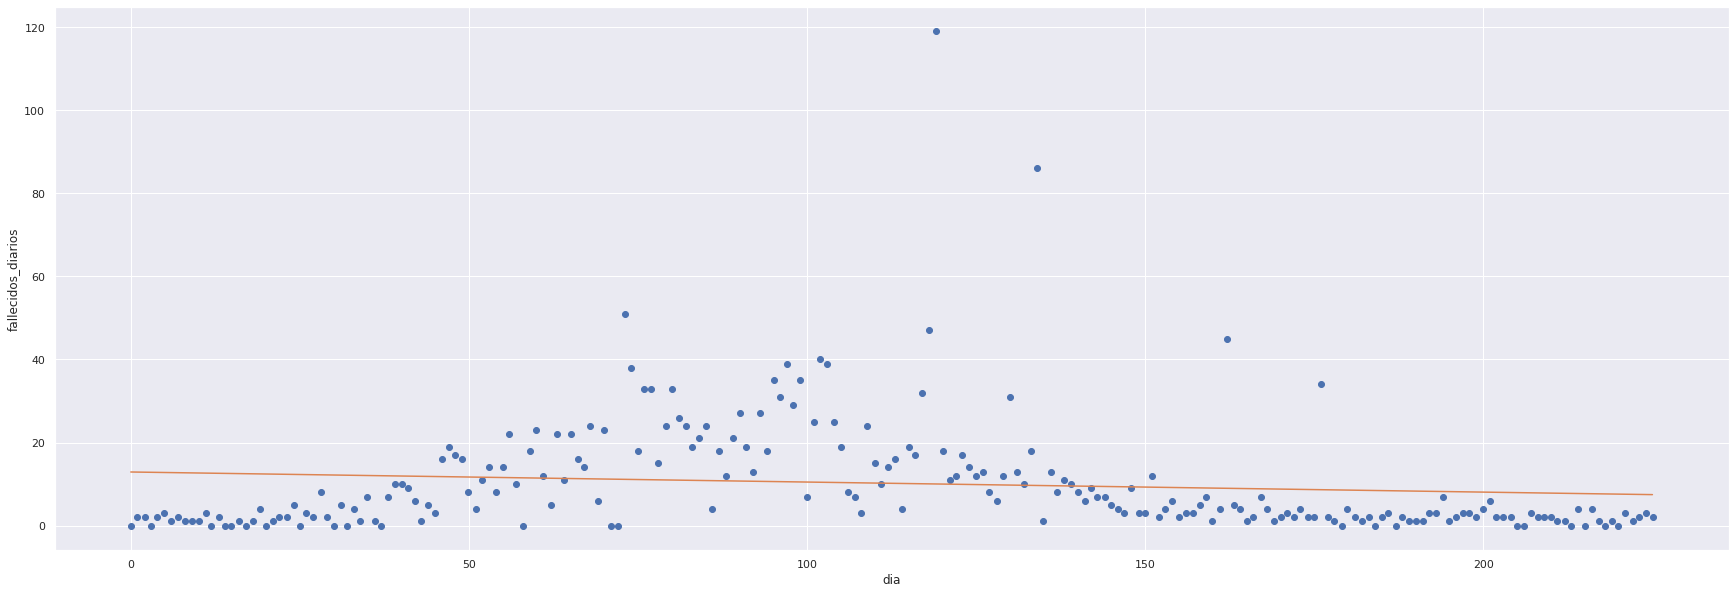

In [157]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('dia')
plt.ylabel('fallecidos_diarios')
plt.show()

In [158]:
results = smf.ols('fallecidos_diarios ~ dia + positividad', data=datos_arequipa).fit()
results.params

Intercept     -1.946326
dia           -0.010666
positividad    1.191007
dtype: float64

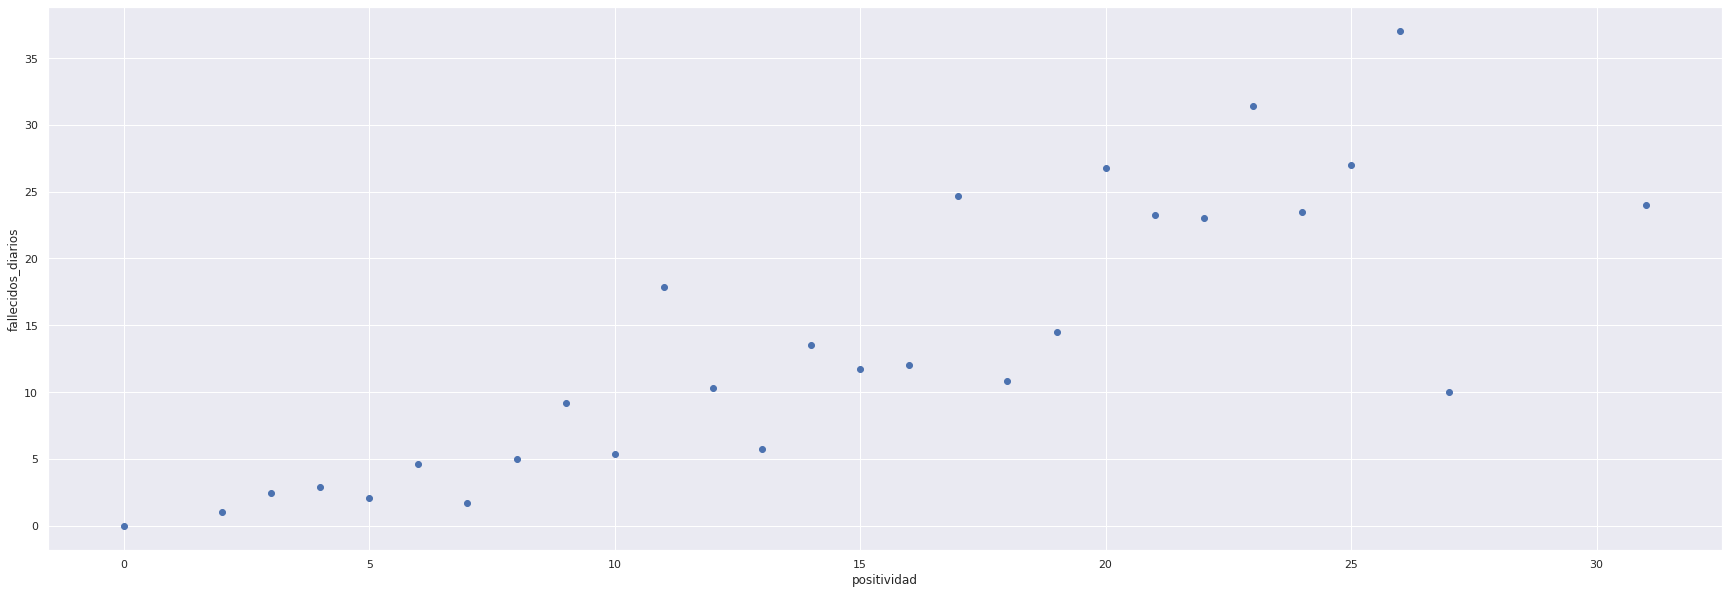

In [159]:
#grouped = datos_arequipa.groupby('dia')
grouped = datos_arequipa.groupby('positividad')
mean_positividad_by_weekday = grouped['fallecidos_diarios'].mean()
plt.figure(figsize=(30,10))
plt.plot(mean_positividad_by_weekday, 'o')

plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.show()

In [160]:
datos_arequipa['positividad2'] = datos_arequipa['positividad'] ** 2
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2

model = smf.ols('fallecidos_diarios ~ dia + dia2 + positividad + positividad2', data=datos_arequipa)
results = model.fit()
results.params

Intercept      -0.705059
dia             0.157081
dia2           -0.000762
positividad     0.144623
positividad2    0.026475
dtype: float64

In [161]:
df = pd.DataFrame()
df['positividad'] = np.linspace(0, 13)
df['positividad2'] = df['positividad'] ** 2

df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2

pred12 = results.predict(df)

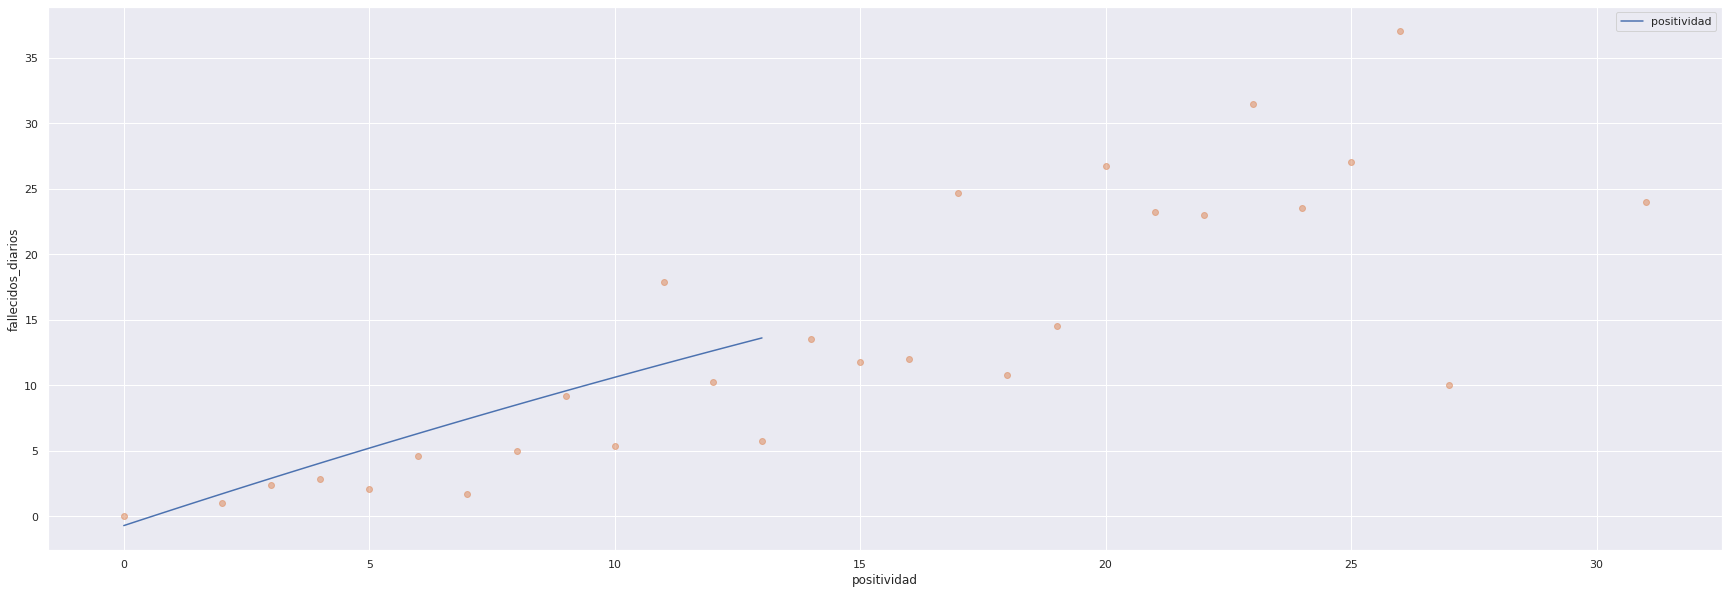

In [162]:
#plt.plot(df['dia'], pred12, label='dia')
plt.figure(figsize=(30,10))
plt.plot(df['positividad'], pred12, label='positividad')
plt.plot(mean_positividad_by_weekday, 'o', alpha=0.5)

#plt.xlabel('dia')
plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.legend()
plt.show()